## Portfolio Optimization with Gurobi: Case Studies Nonlinear Optimization 

In [1]:
from gurobipy import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from gurobi_helper_functions import *

%load_ext autoreload
%autoreload 2

First, we import the dataset of interest with pandas:

In [2]:
file = "E:\Studium TU München\Projektkurs NLO\scenarios\set_1\scen.csv"
data = pd.read_csv(file, index_col=0)
assets = data.columns

For further use in our optimization workflow, we compute standard moments of our assets (expectations, standard deviation):

In [3]:
# Calculate basic summary statistics for individual stocks
mean_returns = data.mean()
asset_volatility = data.std()

print(mean_returns)
print(asset_volatility)

US Gov Bonds HEUR, Market Value                        -0.002295
UK Gov Bonds HEUR, Market Value                        -0.009206
EMU Covered Bonds EUR, Market Value                     0.000482
EMU Corp Bonds 1-10 Years EUR, Market Value             0.002348
US Corp Bonds HEUR, Market Value                        0.002147
Equities Developed World EUR, Market Value              0.060005
Equities Emerging Markets EUR, Market Value             0.070008
Equities Developed World Small Cap EUR, Market Value    0.061943
REIT Developed World EUR, Market Value                  0.052077
German Direct Real Estate EUR, Market Value             0.035278
Commodities HEUR, Market Value                          0.040068
Absolute Return HEUR, Market Value                      0.018018
dtype: float64
US Gov Bonds HEUR, Market Value                         0.053659
UK Gov Bonds HEUR, Market Value                         0.067700
EMU Covered Bonds EUR, Market Value                     0.039290
EMU Corp B

Just as the variances for single assets (these are just the diagonal elements of the covariance matrix), we can define the conditional value at risk (CVaR) of single assets as the solution of the corresponding linear program with $x_i = 1$ for $i = 1,...,n$ where $n$ is the number of assets we consider. This is just the CVaR of a portfolio under the hypothesis that we invest our capital in a single asset $i$. We use a helper function to calculate these values.

In [4]:
beta = 0.95
asset_cvars = calculate_asset_cvars(data, beta=beta)

In [5]:
print(asset_cvars)

[0.10665471 0.14332404 0.08031413 0.07671922 0.12289444 0.2771156
 0.34597402 0.28974432 0.3772121  0.18645728 0.33455625 0.06640947]


Now we will define our model. To do this, we first add a variable for each asset in our list (indexed by the columns of our data frame) and then another variable $\alpha$ for modeling the Value at Risk. We follow the approach by Uryasev to formulate the problem as a linear program (see reference [10]).

In [6]:
# Create an empty model
m = Model('portfolio')

# Add a variable for each asset
x = pd.Series(m.addVars(assets, lb=0.0, ub=1.0, vtype=GRB.CONTINUOUS), index=assets)

#add variable for value at risk
alpha = m.addVar(vtype=GRB.CONTINUOUS, name = "alpha") 

m.update() 

Academic license - for non-commercial use only


Calling the Model.update() routine updates the model by adding variables and constraints defined since the last call of Model.update(). This is important, since attempting to use variables before adding them to the model may result in undefined behavior. 

In [7]:
num_scen = len(data.index) #number of scenarios
nu = 1 / ((1 - beta) * num_scen) #parameter in the objective function

After setting our confidence level, we will define our helper variables and constraints to use in the LP formulation of our problem (see [10], Example Section 1).

In [8]:
#Helper variables
z = m.addVars(num_scen, lb=0.0, vtype=GRB.CONTINUOUS, name="z")

m.update()

Finally, we define our objective function and our constraints using the Gurobi APIs. We use vectorized operations to save time (matrix multiplications instead of for loops).

### Constraints:

1. $\sum\limits_{i=1}^k x_i = 1$, where $k$ is the number of assets (this ensures that all capital is invested), 
2. $z_j \geq f(x,y_j) - \alpha$, $z_j \geq 0$, $j = 1,...,J$, where $J$ is the number of scenarios we have for our asset data.

In total, this lands us at $J + k + 1$ variables, where $J$ is the number of scenarios and k is the number of asset classes. Furthermore, we have $J + 1$ constraints from the dummy variables $z_j$ we used to formulate our LP.

In [9]:
### Constraints:
m.addConstr(x.sum() == 1, name='budget')

values = data.values
z_constraints = -values.dot(x) - np.repeat(LinExpr(alpha), num_scen)

#nonnegativity constraints on the z_i
m.addConstrs((z[i] >= z_constraints[i]) for i in range(num_scen))
m.update()

Lastly, we define our objective function as a sum of the value-at-risk variable and the dummy variables $z_j$ multiplied by the constant $\nu$ defined earlier. Since we want to minimize it, we use the corresponding option GRB.MINIMIZE:


In [10]:
#Linear approximation of the CVaR
cvar_approximation = alpha + nu * z.sum()

m.setObjective(cvar_approximation, GRB.MINIMIZE)
print(m)

<gurobi.Model Continuous instance portfolio: 50001 constrs, 50013 vars, Parameter changes: LogFile=gurobi.log, CSIdleTimeout=1800>


As one last check before running the simulation, we print the model and check if everything is correct. 

In [11]:
m.setParam('OutputFlag', 0)
m.optimize()

Through optimization we obtain the optimal $x_i$ for our investment portfolio. From this, the expected return of the optimal portfolio can then be calculated as $\mathbb{E}(R) = \sum\limits_{i=1}^n \mu_i x_i$, where $\mu_i$ is the mean return for asset $i$.

In [12]:
# Calculate expected return
expected_return = mean_returns.dot(x)

squared_portfolio_risk = data.cov().dot(x).dot(x)

#save portfolio in variable
unconstrained_optimal = np.array([v.x for v in x])

In [13]:
# Display minimum CVaR portfolio
print('Minimum CVaR Portfolio:\n')
for v in x:
    print('\t%s\t: %f' % (v.varname, v.x))

mincvar_volatility = np.sqrt(squared_portfolio_risk.getValue())
print('\nVolatility      = %g' % mincvar_volatility)
unconstrained_mincvar = cvar_approximation.getValue()
print('Conditional Value at Risk = %g' % unconstrained_mincvar)
unconstrained_mincvar_return = expected_return.getValue()
print('Expected Return = %g' % unconstrained_mincvar_return)

Minimum CVaR Portfolio:

	C0	: 0.086096
	C1	: 0.002508
	C2	: 0.247621
	C3	: 0.118059
	C4	: 0.000000
	C5	: 0.007583
	C6	: 0.000000
	C7	: 0.000000
	C8	: 0.000000
	C9	: 0.084356
	C10	: 0.012472
	C11	: 0.441304

Volatility      = 0.0278716
Conditional Value at Risk = 0.0466765
Expected Return = 0.0120579


### Step 2: Finding and plotting the Efficient Frontier

In the second step, we want to find the efficient frontier (as detailed e.g. in [5]) to visualize the relationship of expected return and associated risk.

To do so, we simply vary the expected return of our portfolio by adding a return constraint, i.e. requiring that our portfolio achieves a return of at least $R$. We start with the unconstrained expected return (i.e., the return of the simulation we just ran without any return constraint in effect).

In [14]:
# Add (redundant) target return constraint
target = m.addConstr(expected_return == unconstrained_mincvar_return, 'target')
m.update()

In [15]:
# Solve for efficient frontier by varying target return
portfolio_vals = np.zeros((12,100))
frontier = np.zeros(100)
return_values = np.zeros(100)
for i,r in enumerate(np.linspace(mean_returns.min(), mean_returns.max(), 100)):
    target.rhs = r
    m.update()
    m.optimize()
    portfolio_vals[:,i] = np.array([v.x for v in x])
    frontier[i] = cvar_approximation.getValue()
    return_values[i] = r

Finally, we plot the efficient frontier to see how steeply the risk increases when we require a certain return value. 

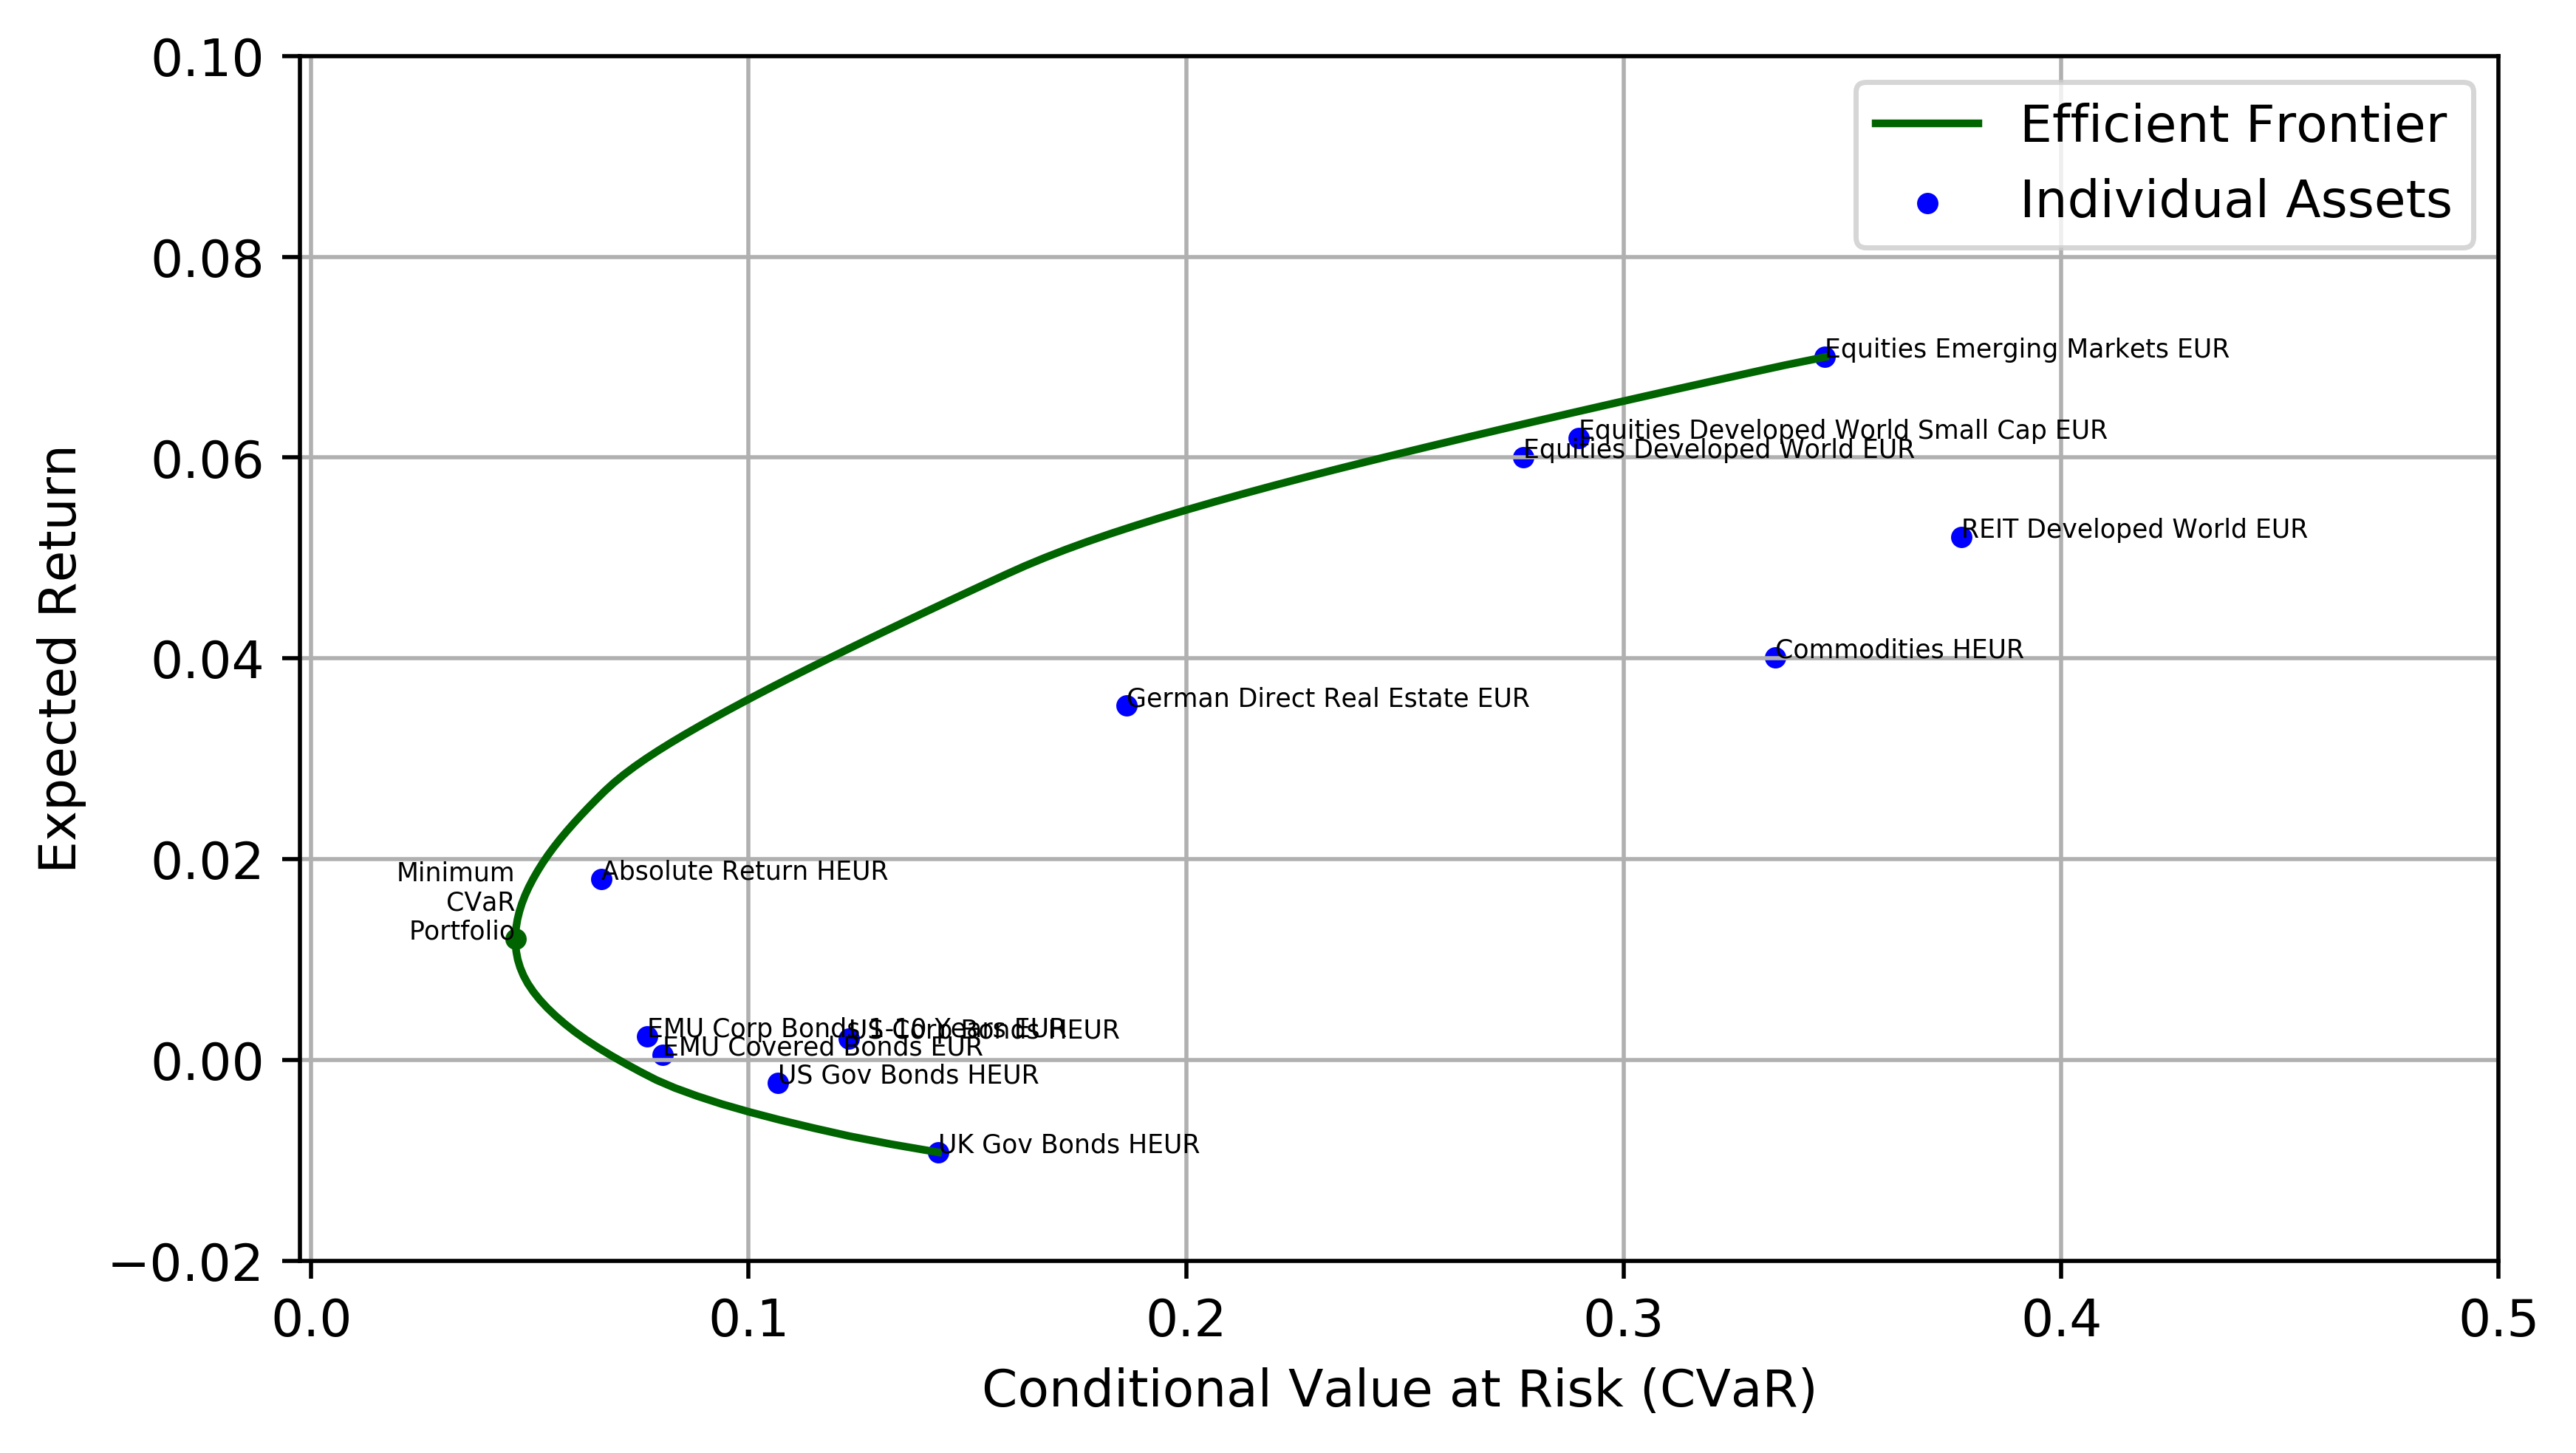

In [16]:
# Plot volatility versus expected return for individual stocks
my_dpi = 500
plt.figure(figsize=(3840/my_dpi, 2160/my_dpi), dpi=my_dpi)
ax = plt.gca()
ax.scatter(x=asset_cvars, y=mean_returns,
           color='Blue', label='Individual Assets', s=10)
for i, asset in enumerate(assets):
    asset_1 = asset.replace(', Market Value', '') #improve legibility
    ax.annotate(asset_1, (asset_cvars[i], mean_returns[i]),size=5)

# Plot volatility versus expected return for minimum risk portfolio
ax.scatter(x=unconstrained_mincvar, y=unconstrained_mincvar_return, color='DarkGreen', s=10)
ax.annotate('Minimum\nCVaR\nPortfolio', (unconstrained_mincvar, unconstrained_mincvar_return),
            horizontalalignment='right',size=5)

# Plot efficient frontier
ax.plot(frontier,return_values, color='DarkGreen', label='Efficient Frontier')

# Format and display the final plot
ax.axis([-0.0025, 0.5, -0.02, 0.1])
ax.set_xlabel('Conditional Value at Risk (CVaR)')
ax.set_ylabel('Expected Return')
ax.legend()
ax.grid()

plt.savefig('cvarfrontier.jpg', dpi=my_dpi)

In [17]:
betas = [0.9, 0.95, 0.99]
num_points = 100

frontiers = np.zeros((len(betas),num_points))
sq_cvar_frontiers = np.zeros((len(betas),num_points))
alloc_diffs = np.zeros((len(betas),num_points))
ex_frontier = None #container for holding portfolio values that are plotted
#Markowitz calculation
sqm, sq_portfolio = build_squared_risk_model(data)
sq_frontier, sq_return_values, sq_portfolio_vals = calculate_efficient_frontier(sqm, sq_portfolio, data, num_points=num_points)

for i,beta in enumerate(betas):
    cvar_model, portfolio_vec = build_cvar_model(data, beta)
    frontiers[i,:], return_values, cvar_portfolio_vals = calculate_efficient_frontier(cvar_model, portfolio_vec, data, num_points=100)
    if i == 1:
        ex_frontier = cvar_portfolio_vals
        
    #Calculate cvar values of squared-risk-optimal portfolios
    sq_cvar_frontiers[i,:] = calculate_portfolio_cvars(data,sq_portfolio_vals,beta=beta)
    
    #log differences in allocations
    alloc_diffs[i,:] = np.sum(np.abs(sq_portfolio_vals - cvar_portfolio_vals),axis=0)

We now plot how the allocation vectors change over the entire efficient frontier. As an arbitrary example, the value $\beta = 0.95$ is chosen. 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


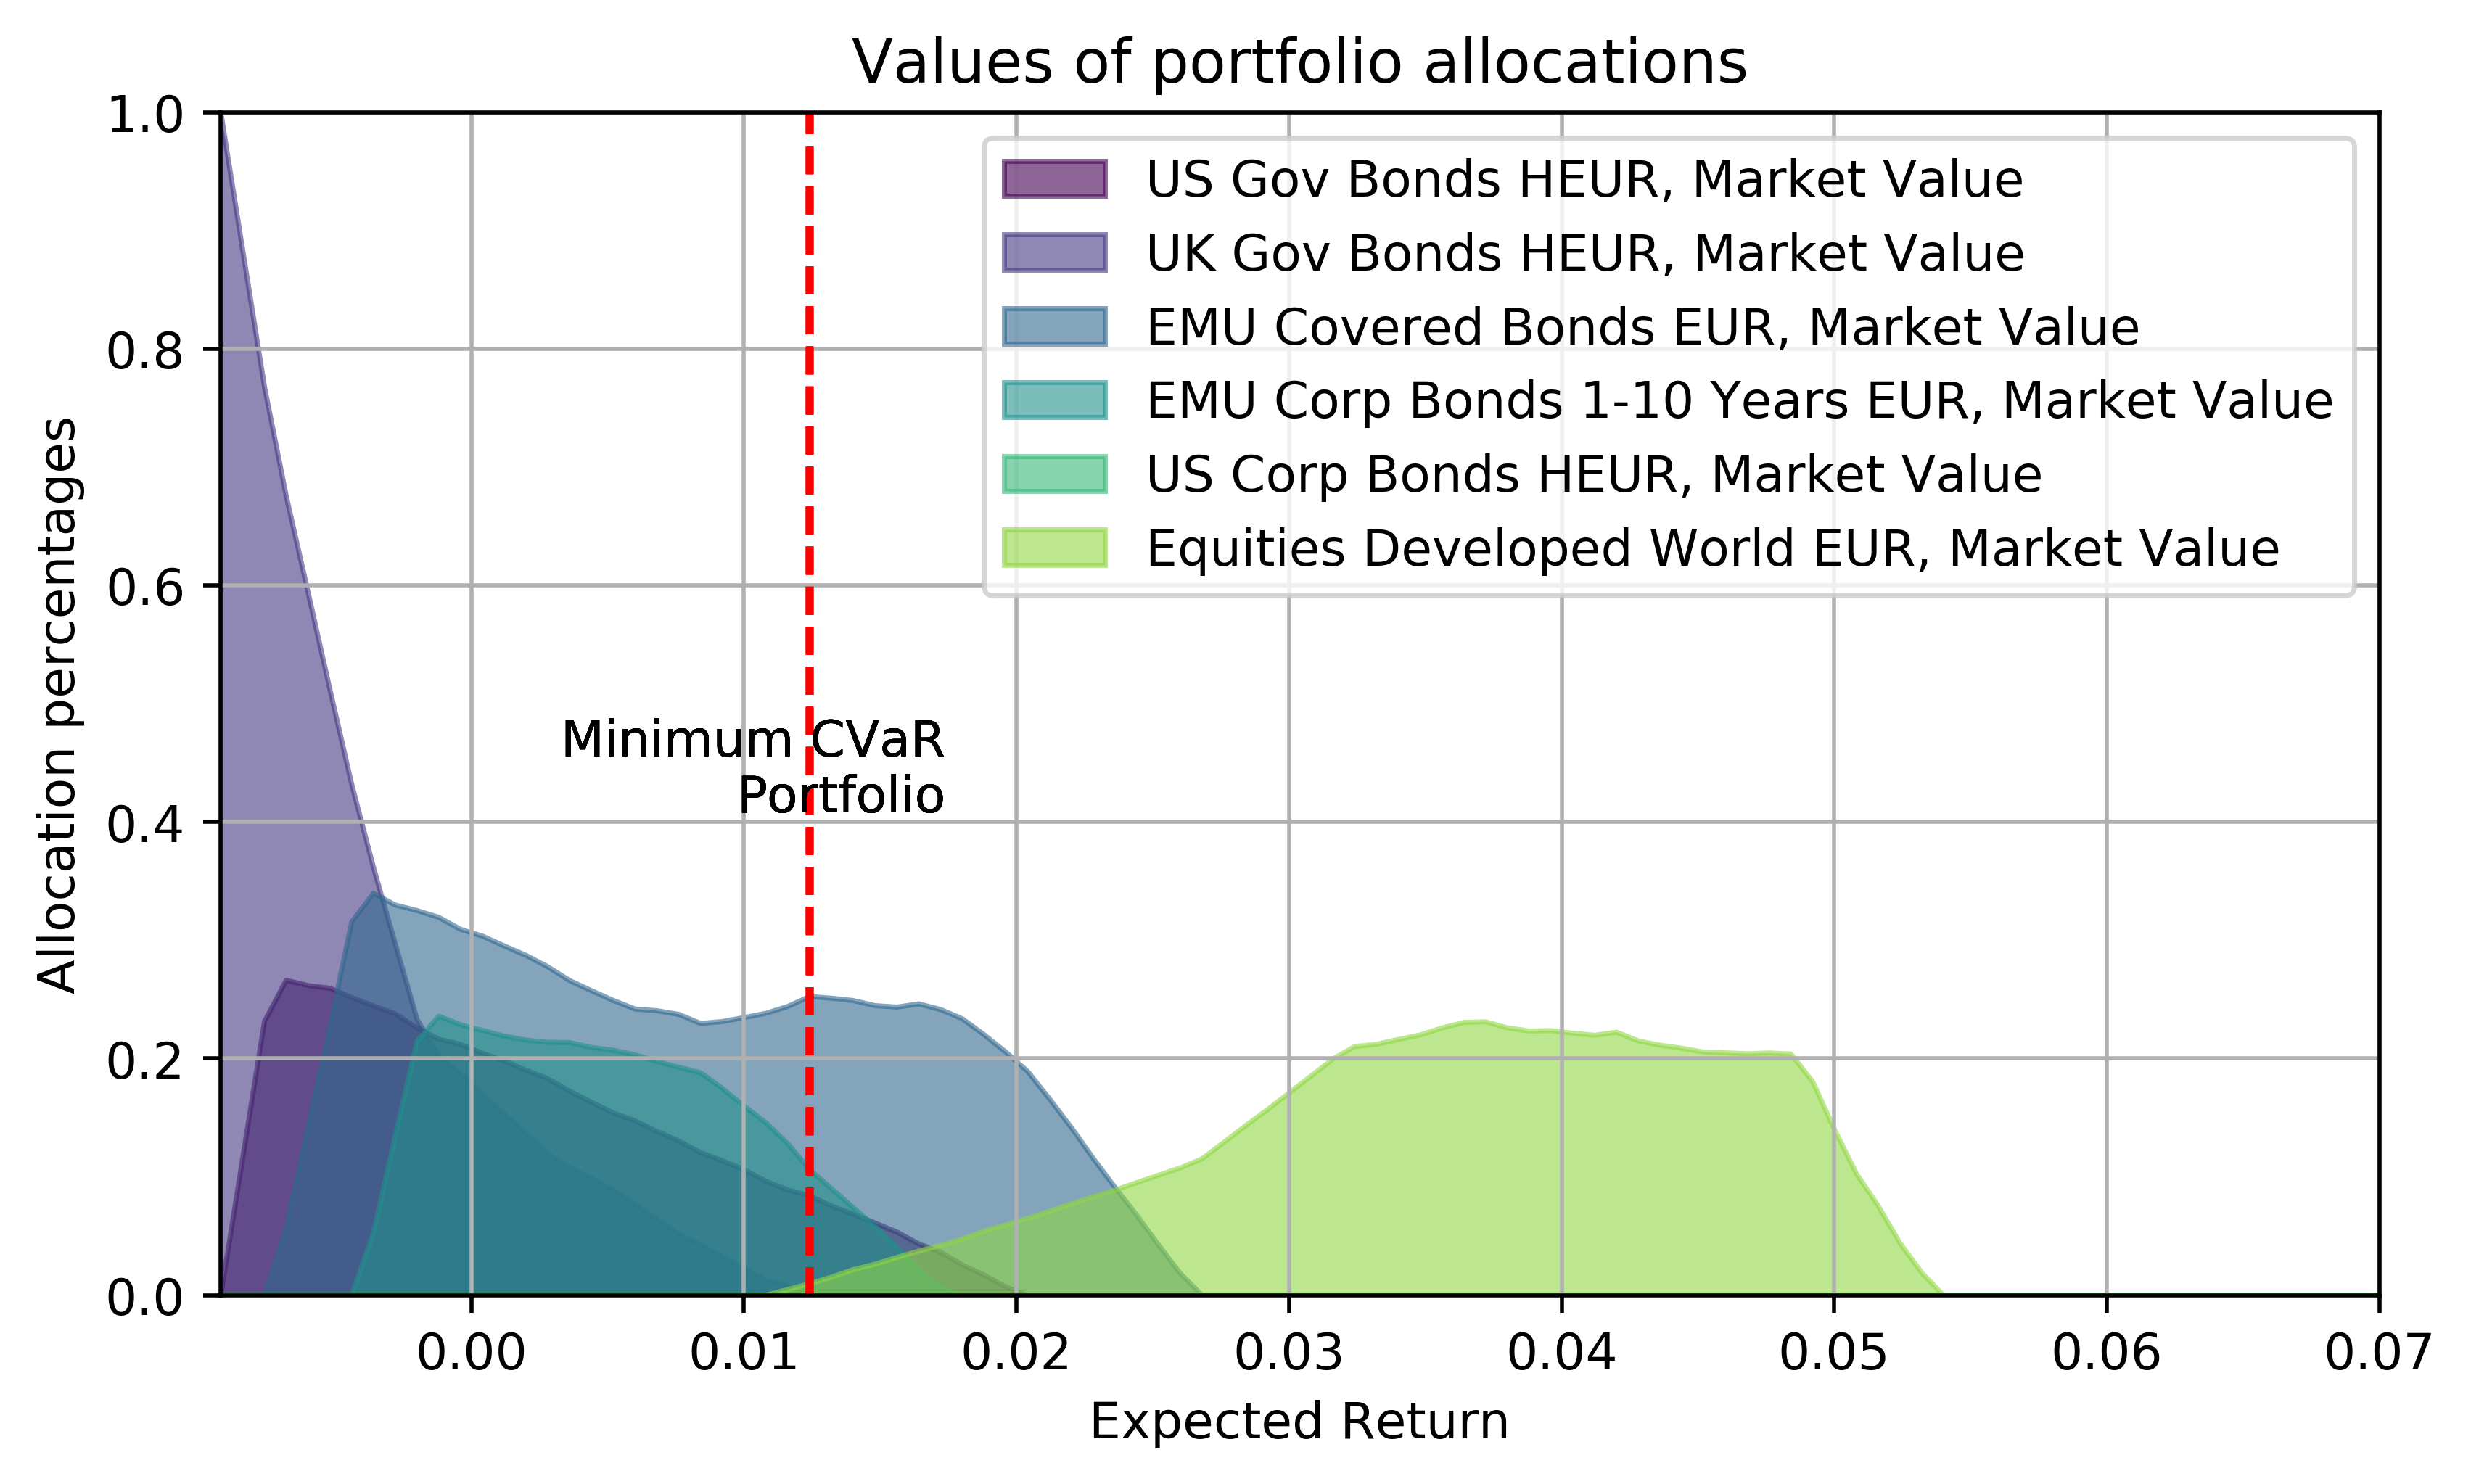

In [18]:
# Plot volatility versus expected return for individual stocks
my_dpi = 500
plt.figure(figsize=(3840/my_dpi, 2160/my_dpi), dpi=my_dpi)
ax = plt.gca()

Ncolors = ex_frontier.shape[0] 
colormap = plt.cm.viridis
Ncolors = min(colormap.N,Ncolors)
mapcolors = [colormap(int(x*colormap.N/Ncolors)) for x in range(Ncolors)]

for i in range(ex_frontier.shape[0] // 2):
    
    # Plot volatility versus expected return for minimum risk portfolio
    ax.axvline(x=sq_return_values[np.argmin(frontiers[1,:])], color='r', linestyle="--")
    ax.fill_between(sq_return_values,ex_frontier[i,:], label= assets[i], alpha=0.6, color=mapcolors[2*i])
    ax.annotate('Minimum CVaR\nPortfolio', (sq_return_values[np.argmin(frontiers[1,:])]+0.005, 0.4),verticalalignment='bottom',horizontalalignment="right")

# Format and display the final plot
ax.axis([np.min(sq_return_values), np.max(sq_return_values), 0.0, 1.0])
ax.set_xlabel('Expected Return')
ax.set_ylabel('Allocation percentages')
ax.set_title("Values of portfolio allocations")

ax.legend() #bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.
ax.grid()

plt.savefig('allocations_on_frontier1.jpg', dpi=my_dpi)

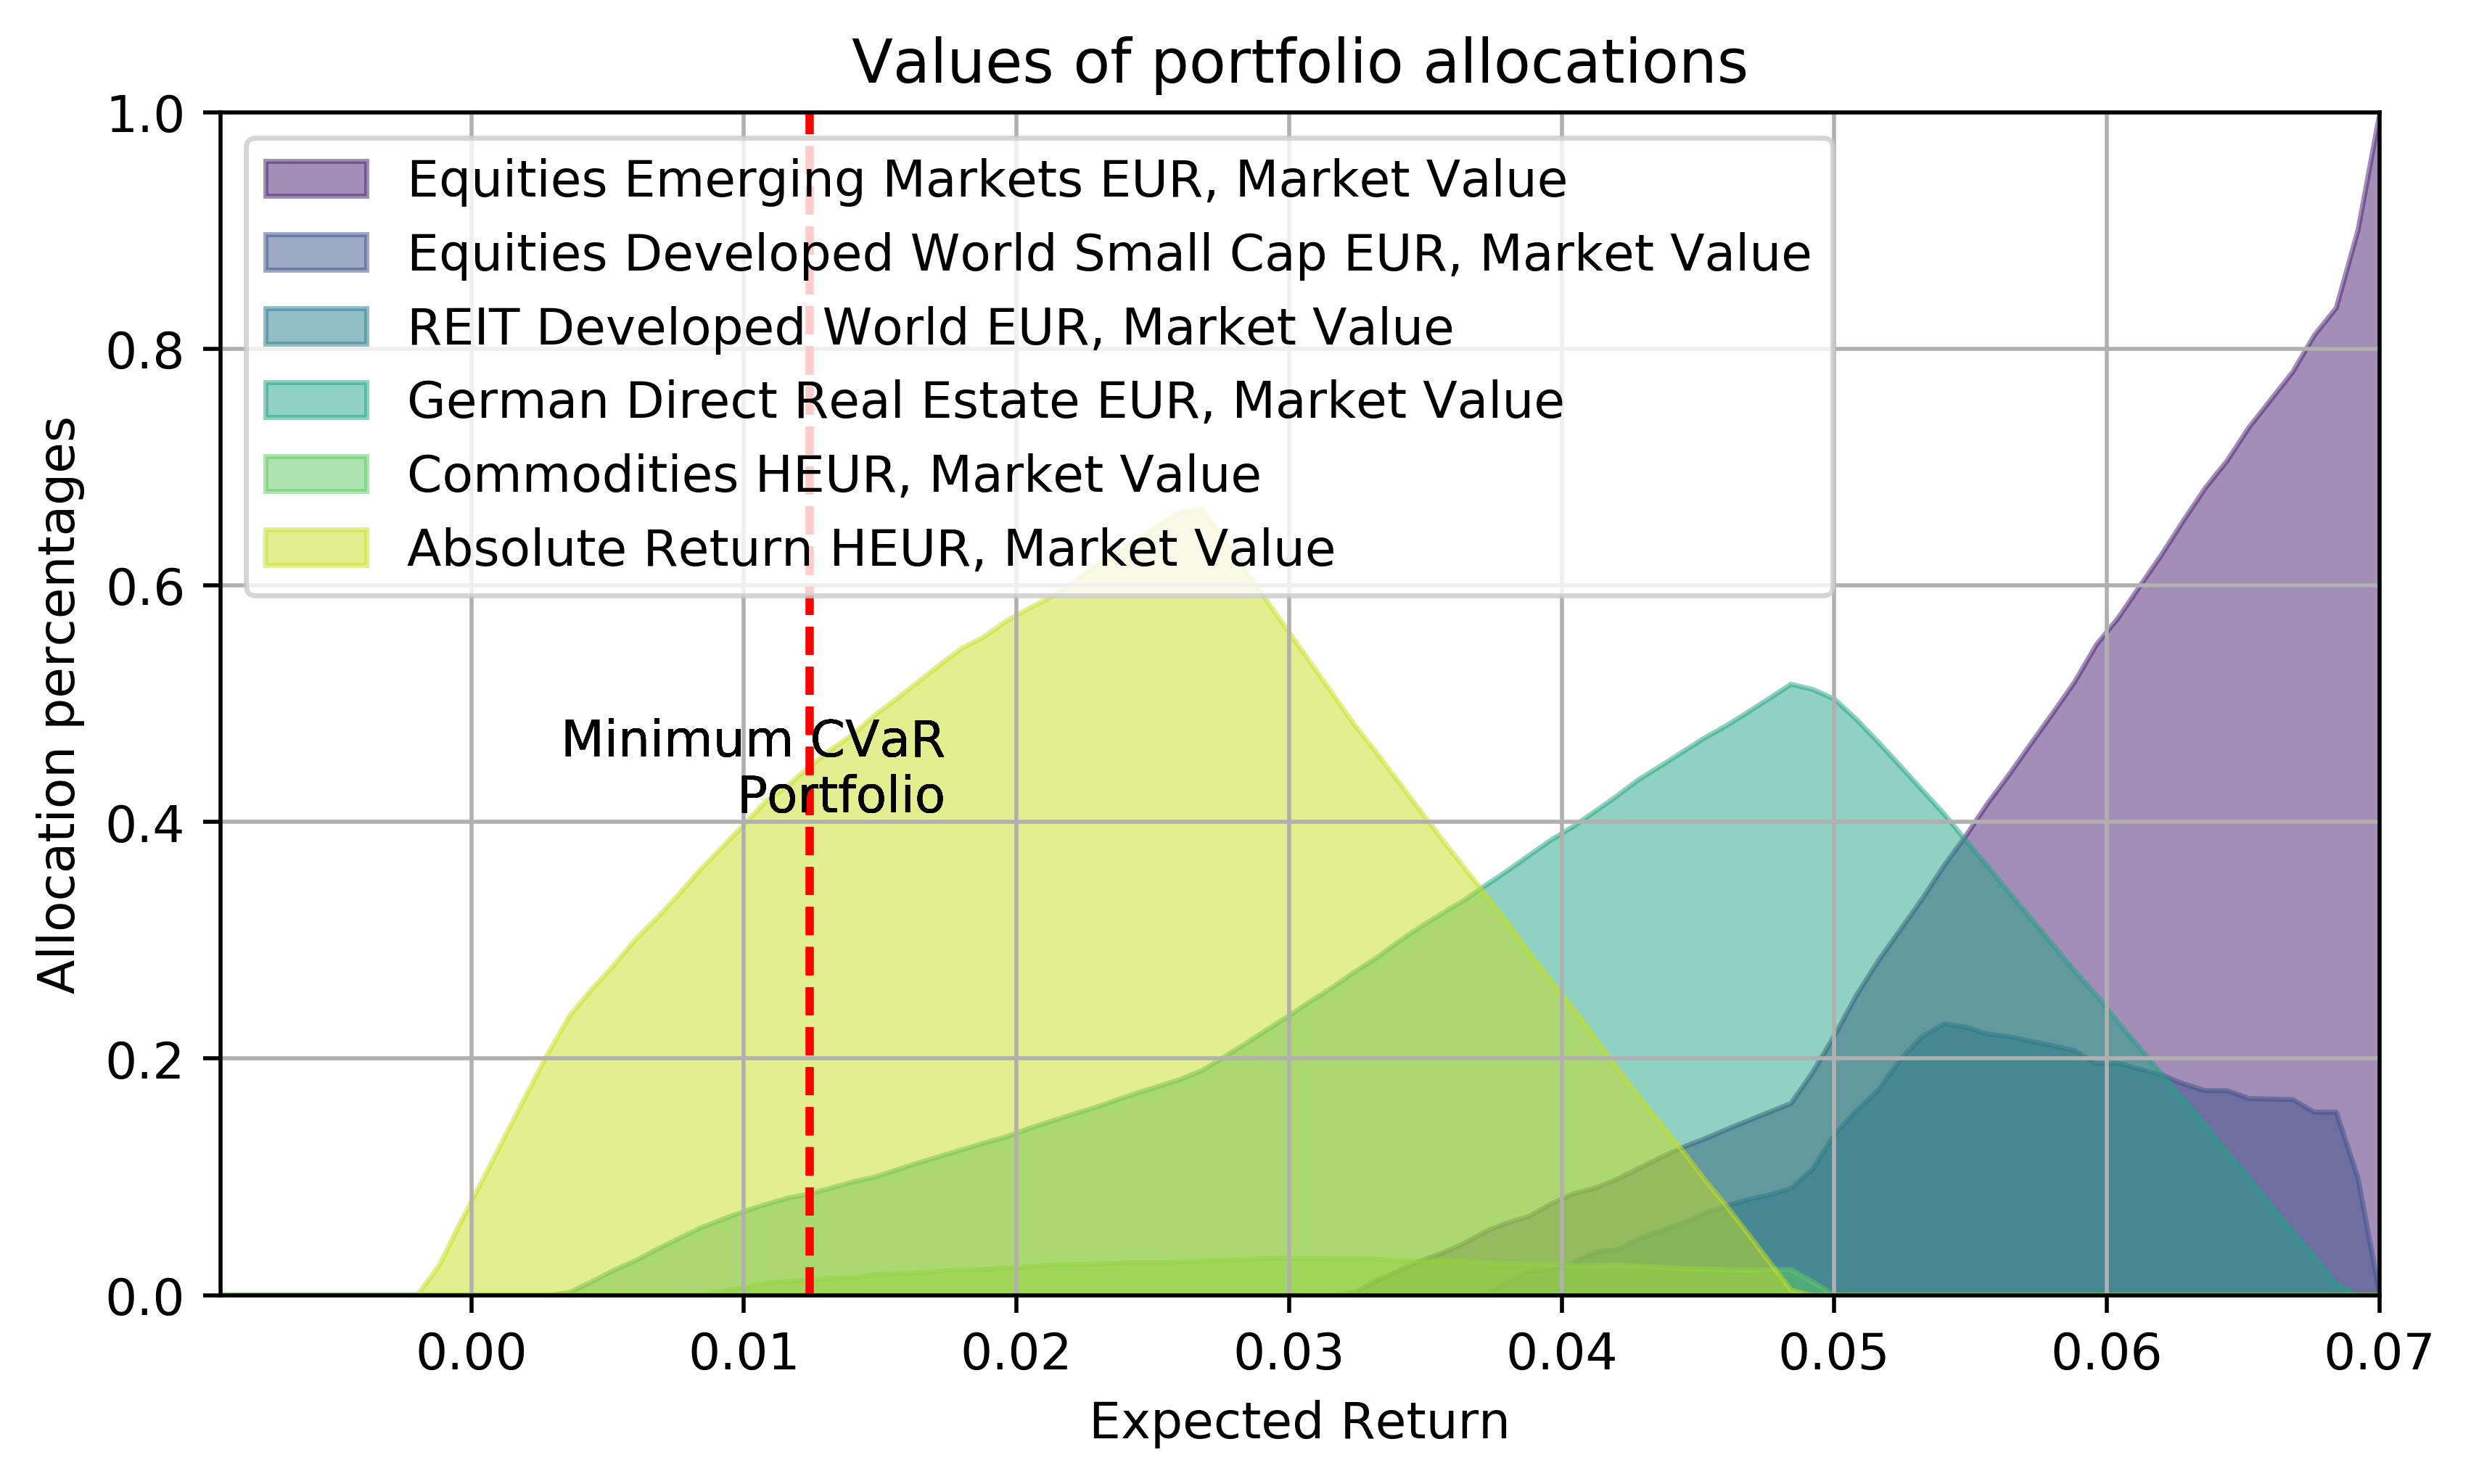

In [19]:
# Plot volatility versus expected return for individual stocks
my_dpi = 500
plt.figure(figsize=(3840/my_dpi, 2160/my_dpi), dpi=my_dpi)
ax = plt.gca()

Ncolors = ex_frontier.shape[0]
colormap = plt.cm.viridis
Ncolors = min(colormap.N,Ncolors)
mapcolors = [colormap(int(x*colormap.N/Ncolors)) for x in range(Ncolors)]

for i in range(ex_frontier.shape[0] // 2, ex_frontier.shape[0]):

    # Plot volatility versus expected return for minimum risk portfolio
    ax.axvline(x=sq_return_values[np.argmin(frontiers[1,:])], color='r', linestyle="--")
    ax.fill_between(sq_return_values,ex_frontier[i,:], label= assets[i], alpha=0.5, color=mapcolors[2*(i - ex_frontier.shape[0] // 2)+1])
    ax.annotate('Minimum CVaR\nPortfolio', (sq_return_values[np.argmin(frontiers[1,:])]+0.005, 0.4),verticalalignment='bottom',horizontalalignment="right")
        
# Format and display the final plot
ax.axis([np.min(sq_return_values), np.max(sq_return_values), 0.0, 1.0])
ax.set_xlabel('Expected Return')
ax.set_ylabel('Allocation percentages')
ax.set_title("Values of portfolio allocations")

ax.legend(loc='upper left')
ax.grid()

plt.savefig('allocations_on_frontier2.jpg', dpi=my_dpi)

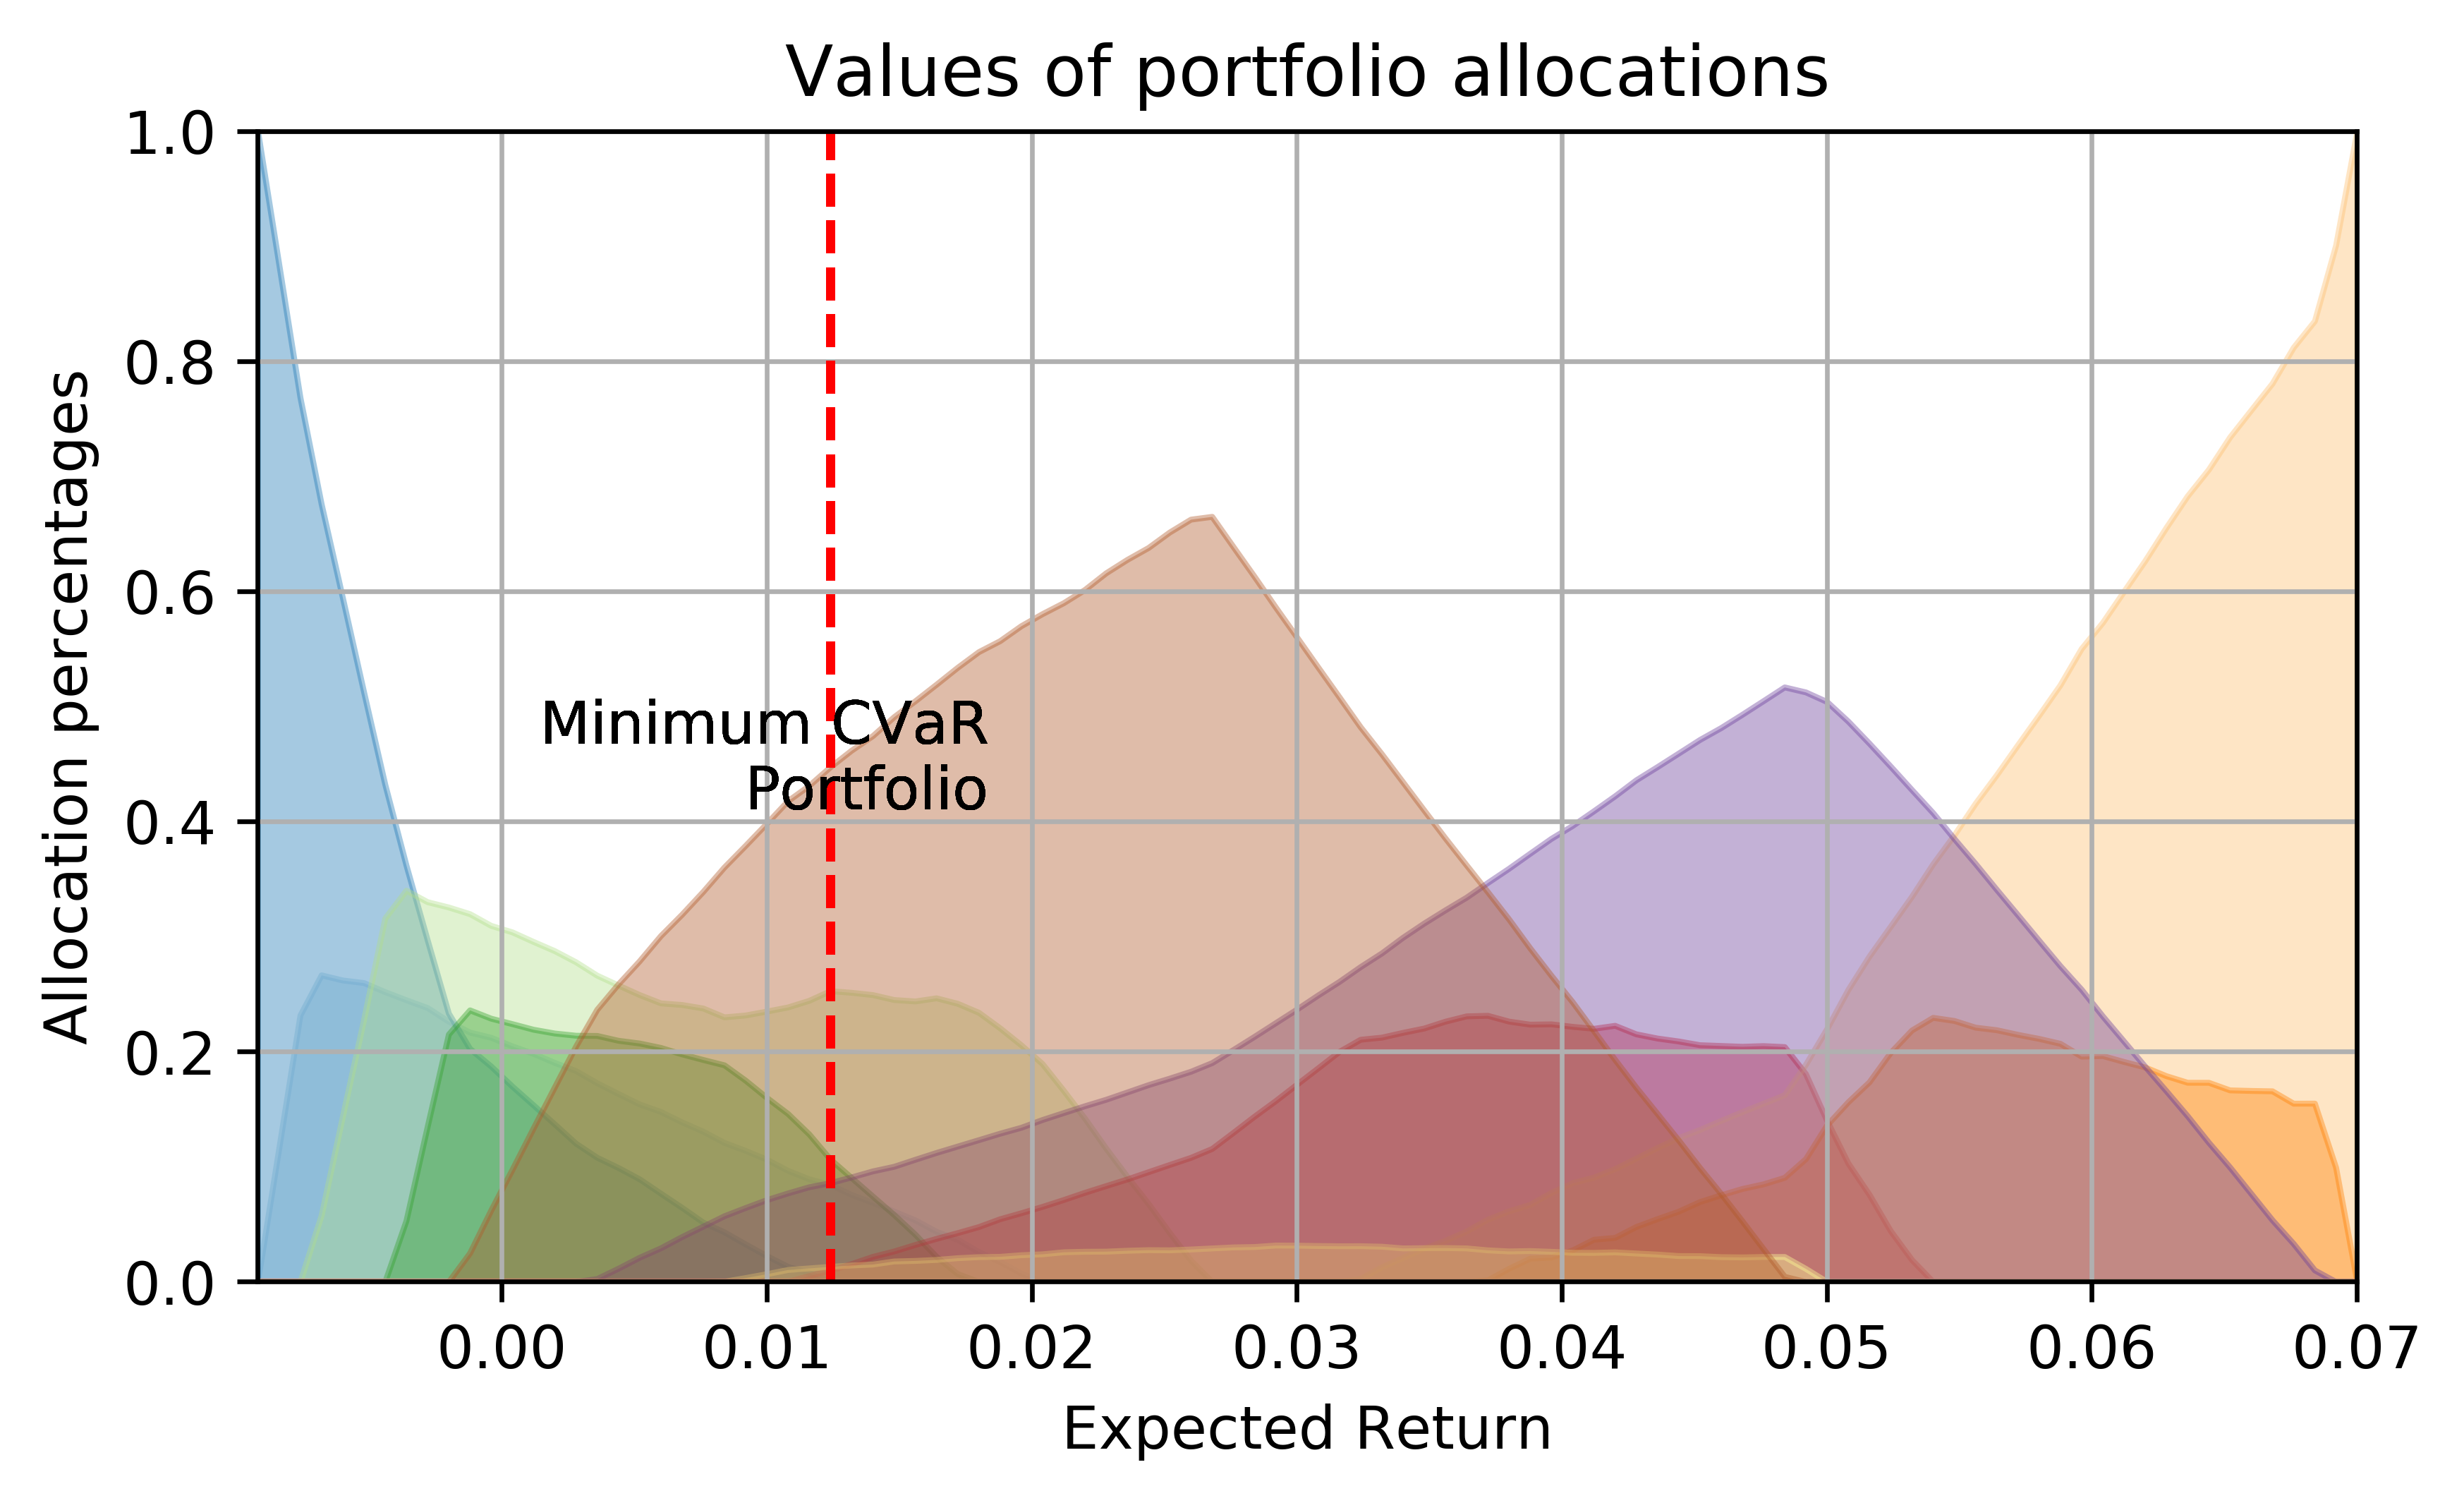

In [27]:
# Plot volatility versus expected return for individual stocks
my_dpi = 600
plt.figure(figsize=(3840/my_dpi, 2160/my_dpi), dpi=my_dpi)
ax = plt.gca()

Ncolors = ex_frontier.shape[0] 
colormap = plt.cm.Paired
Ncolors = min(colormap.N,Ncolors)
mapcolors = [colormap(int(x*colormap.N/Ncolors)) for x in range(Ncolors)]

for i in range(ex_frontier.shape[0]):
    
    # Plot volatility versus expected return for minimum risk portfolio
    ax.axvline(x=sq_return_values[np.argmin(frontiers[1,:])], color='r', linestyle="--")    
    ax.fill_between(sq_return_values,ex_frontier[i,:], label= assets[i], alpha=0.4, color=mapcolors[i])
    ax.annotate('Minimum CVaR\nPortfolio', (sq_return_values[np.argmin(frontiers[1,:])]+0.006, 0.4),verticalalignment='bottom',horizontalalignment="right")
        
# Format and display the final plot
ax.axis([np.min(sq_return_values), np.max(sq_return_values), 0.0, 1.0])
ax.set_xlabel('Expected Return')
ax.set_ylabel('Allocation percentages')
ax.set_title("Values of portfolio allocations")

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) 
ax.grid()

plt.savefig('allocations_on_frontier_all.jpg', dpi=my_dpi)

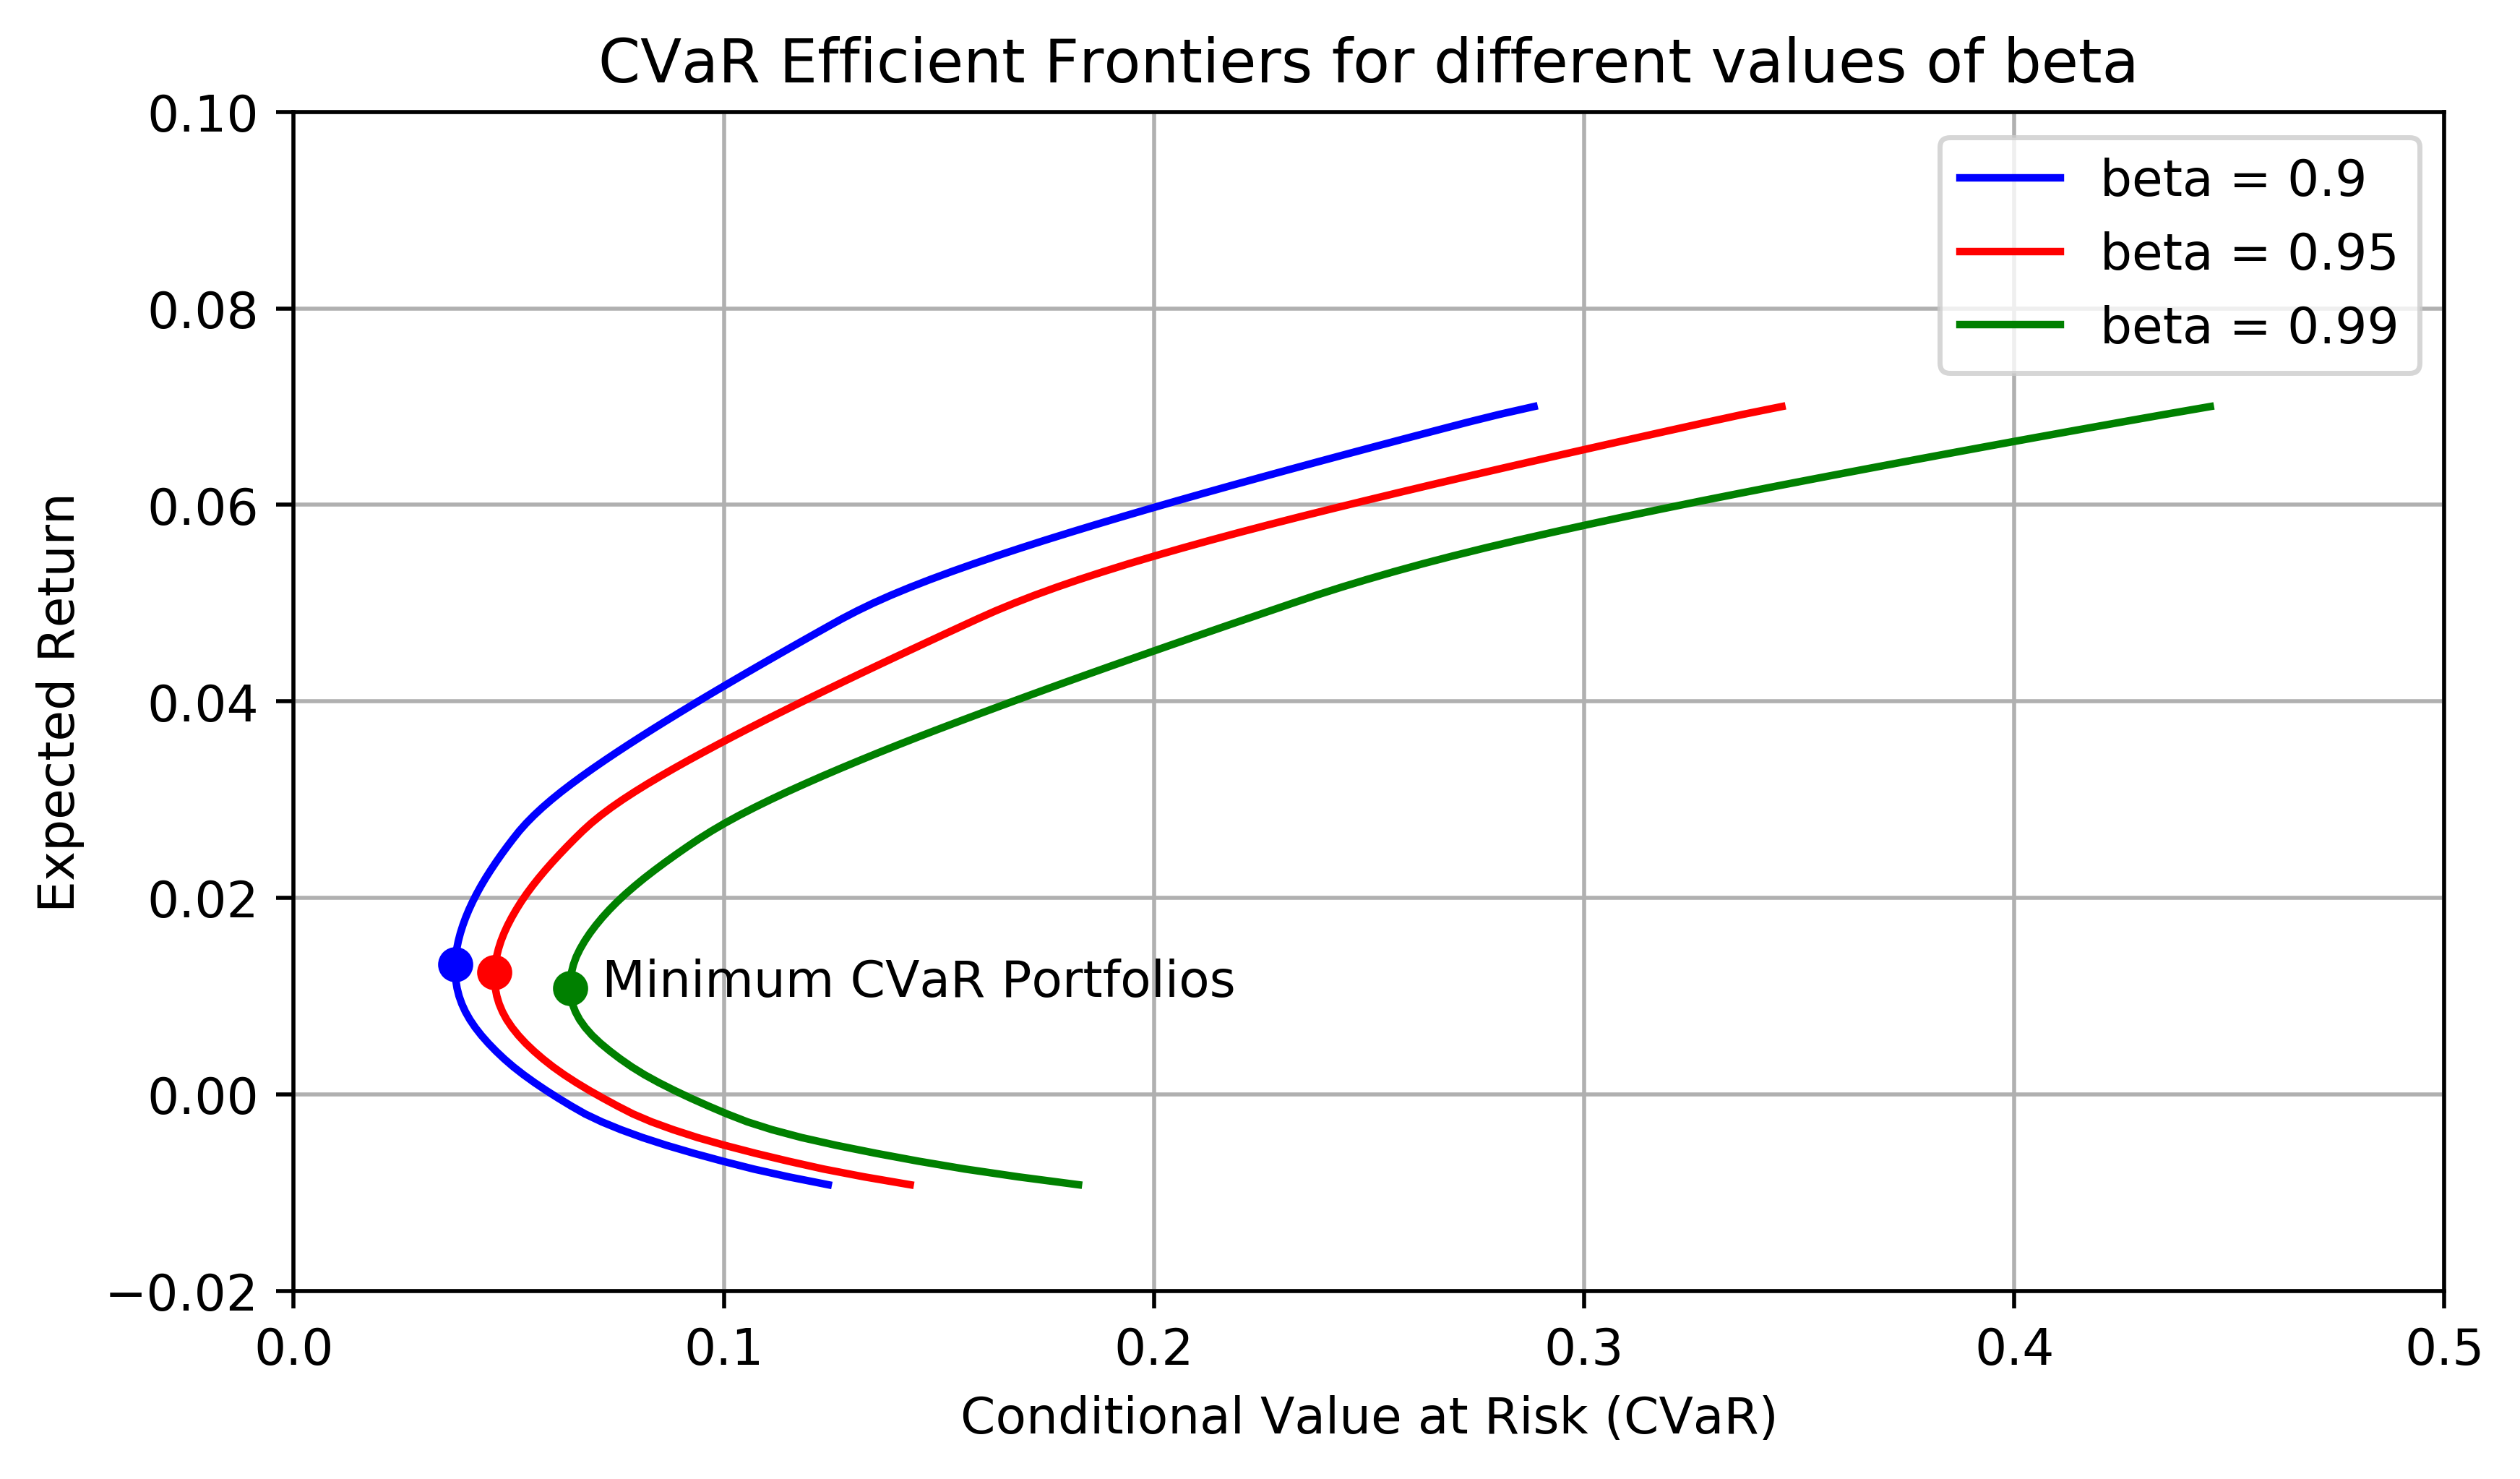

In [32]:
colors = ["blue","red","green"]

# Plot volatility versus expected return for individual stocks
my_dpi = 500
plt.figure(figsize=(3840/my_dpi, 2160/my_dpi), dpi=my_dpi)
ax = plt.gca()

for i,beta in enumerate(betas):
    # Plot volatility versus expected return for minimum risk portfolio
    ax.scatter(x=np.min(frontiers[i,:]), y=return_values[np.argmin(frontiers[i,:])], color=colors[i])
    ax.plot(frontiers[i,:],return_values, color=colors[i], label='beta = ' + str(beta))
    if i == 2:
        ax.annotate('Minimum CVaR Portfolios', (np.min(frontiers[i,:])+0.0075, 0.01),horizontalalignment='left')
        
# Format and display the final plot
ax.axis([0.0, 0.5, -0.02, 0.1])
ax.set_xlabel('Conditional Value at Risk (CVaR)')
ax.set_ylabel('Expected Return')
ax.set_title("CVaR Efficient Frontiers for different values of beta")
ax.legend()
ax.grid()

plt.savefig('betafrontiers.jpg', dpi=my_dpi)

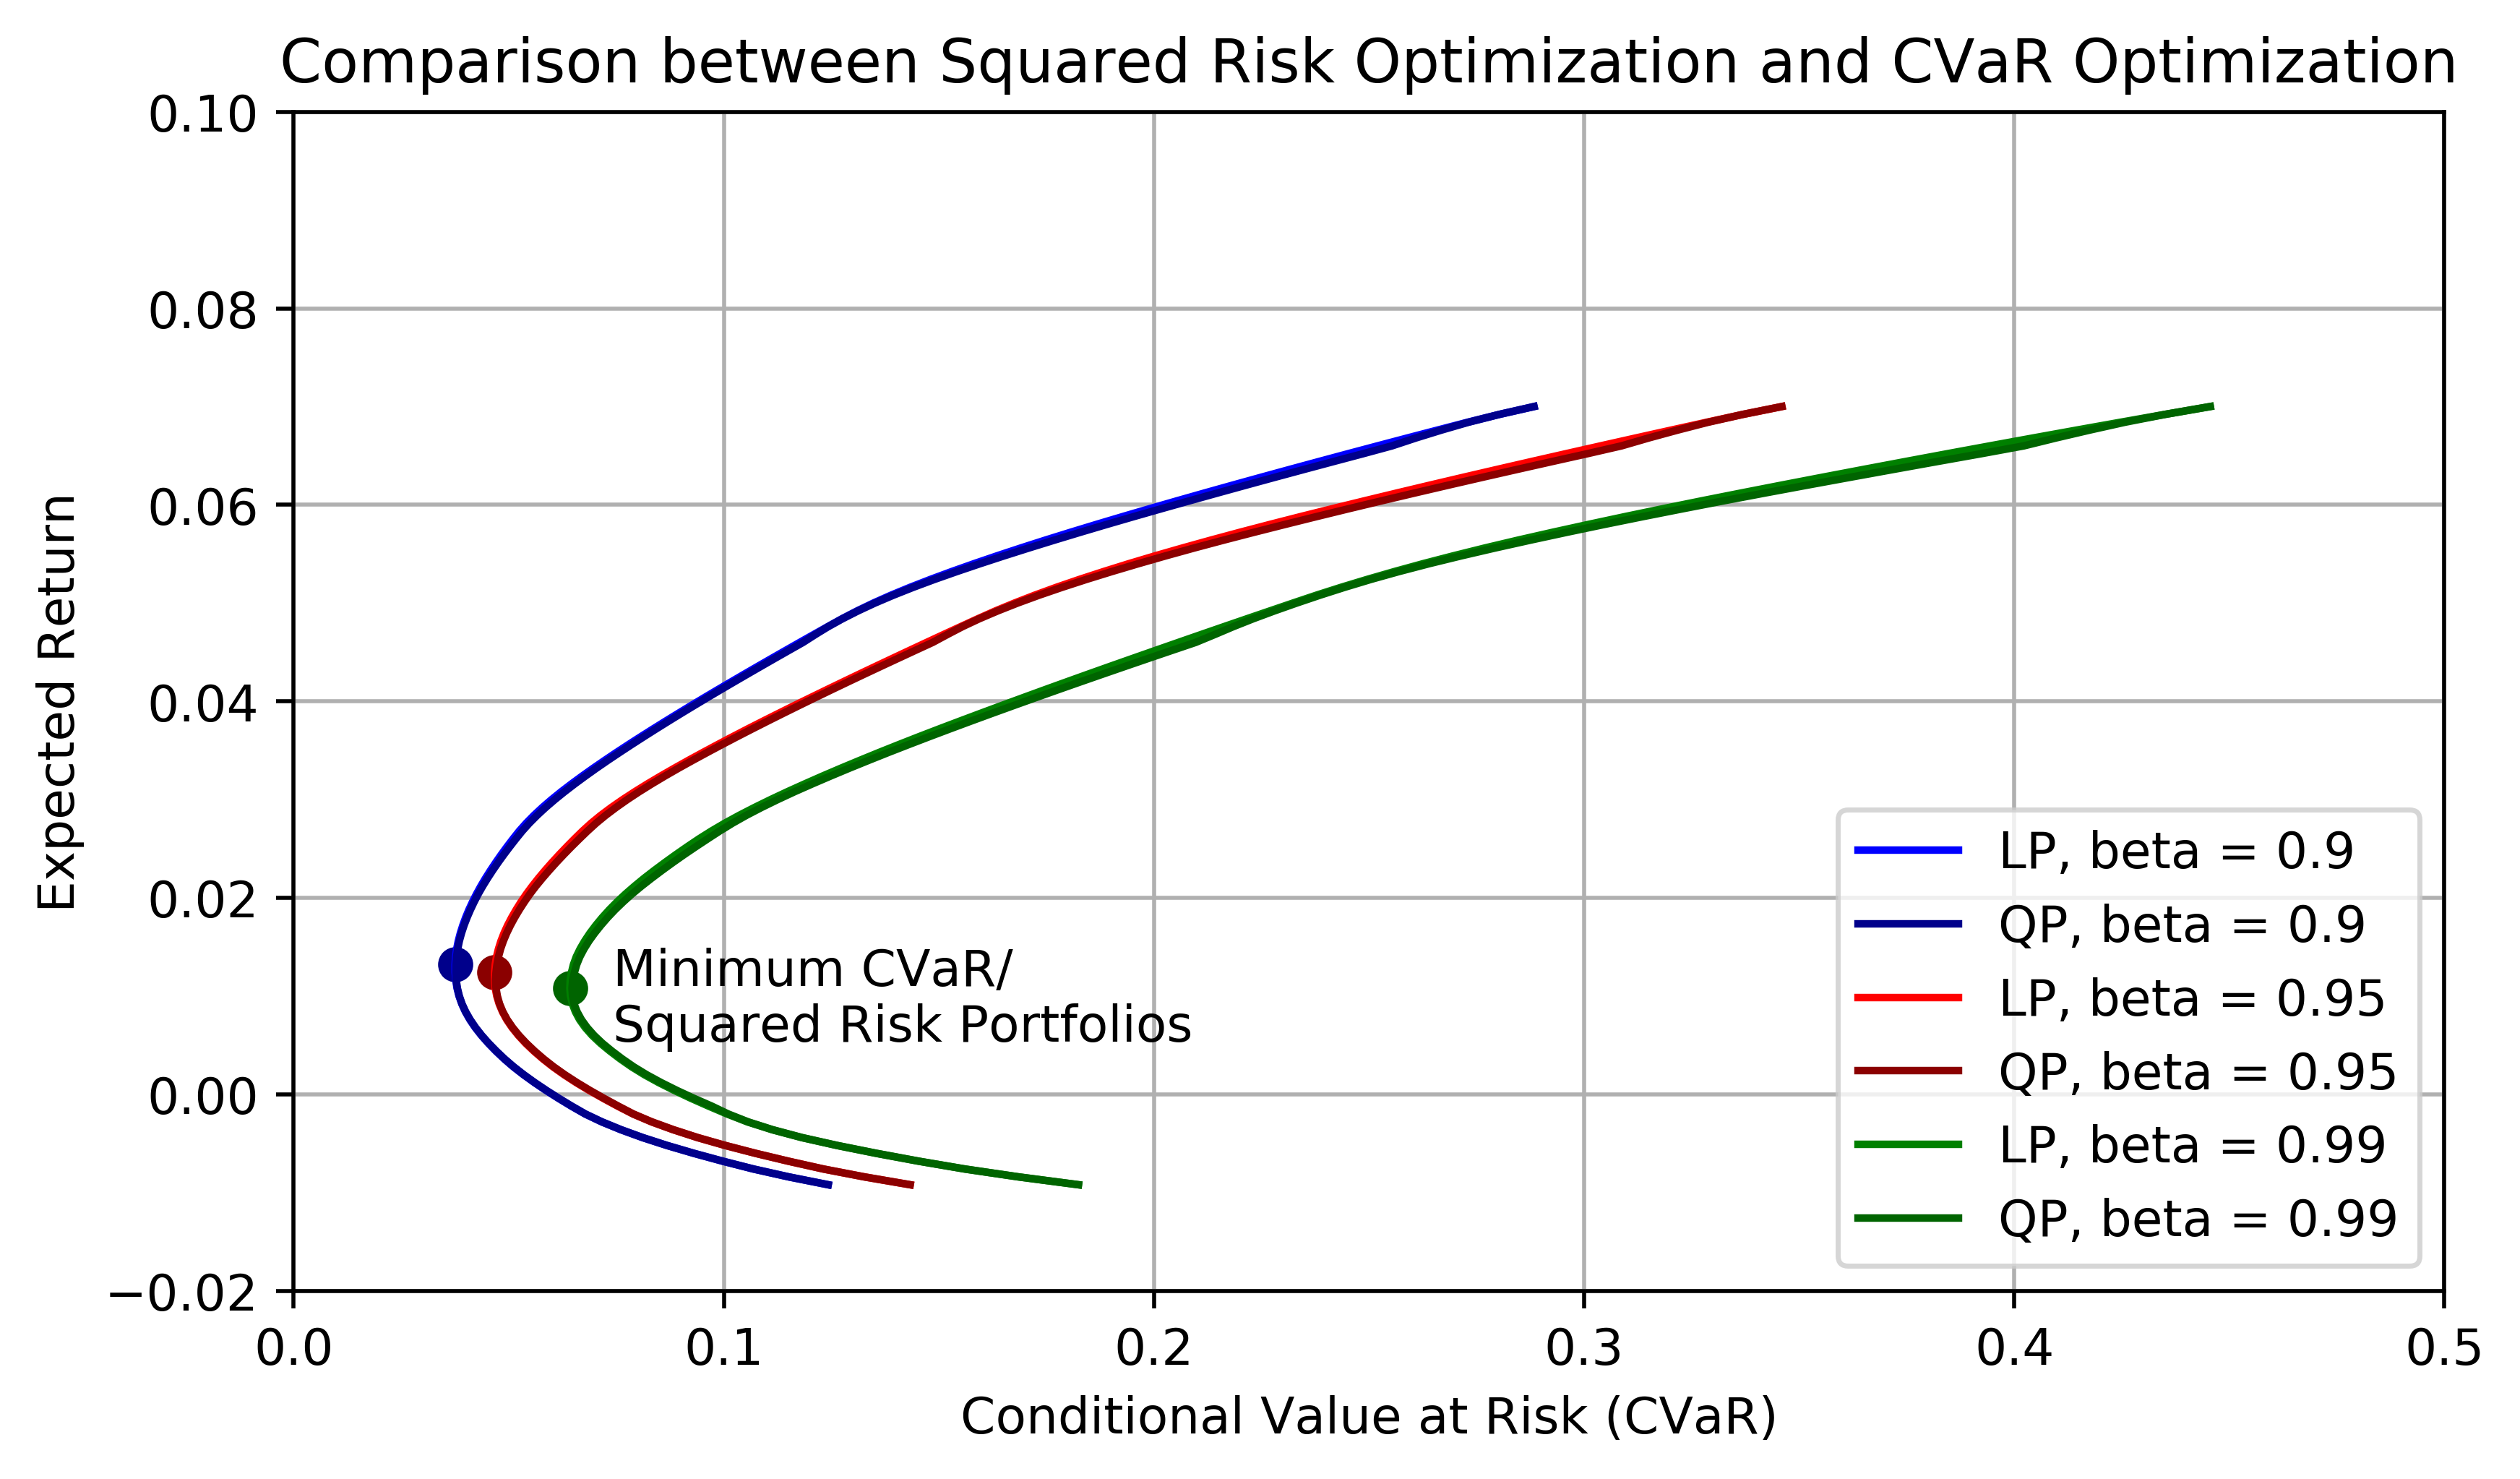

In [37]:
# Plot volatility versus expected return for individual stocks
my_dpi = 500
plt.figure(figsize=(3840/my_dpi, 2160/my_dpi), dpi=my_dpi)
ax = plt.gca()

colors = ["blue","red","green","DarkBlue","DarkRed","DarkGreen"]

for i,beta in enumerate(betas):
    # Plot volatility versus expected return for minimum risk portfolio
    ax.scatter(x=np.min(frontiers[i,:]), y=return_values[np.argmin(frontiers[i,:])], color=colors[i+3])
    #ax.scatter(x=sq_to_cvar[0], y=sq_return_values[0], color=colors[i+3])
    ax.plot(frontiers[i,:],return_values, color=colors[i], label='LP, beta = ' + str(beta))
    ax.plot(sq_cvar_frontiers[i,:],sq_return_values, color=colors[i+3], label='QP, beta = ' + str(beta))
    if i == 2:
        ax.annotate('Minimum CVaR/\nSquared Risk Portfolios', (np.min(frontiers[i,:])+0.01, 0.015),verticalalignment='top')

# Format and display the final plot
ax.axis([0.0, 0.5, -0.02, 0.1])
ax.set_xlabel('Conditional Value at Risk (CVaR)')
ax.set_ylabel('Expected Return')
ax.set_title("Comparison between Squared Risk Optimization and CVaR Optimization")
ax.legend()
ax.grid()

plt.savefig('markowitz_vs_cvar.jpg', dpi=my_dpi)        

Now we plot the absolute $L_1$ differences in the optimal portfolio allocations of the Markowitz model vs. the CVaR linear program solution. 

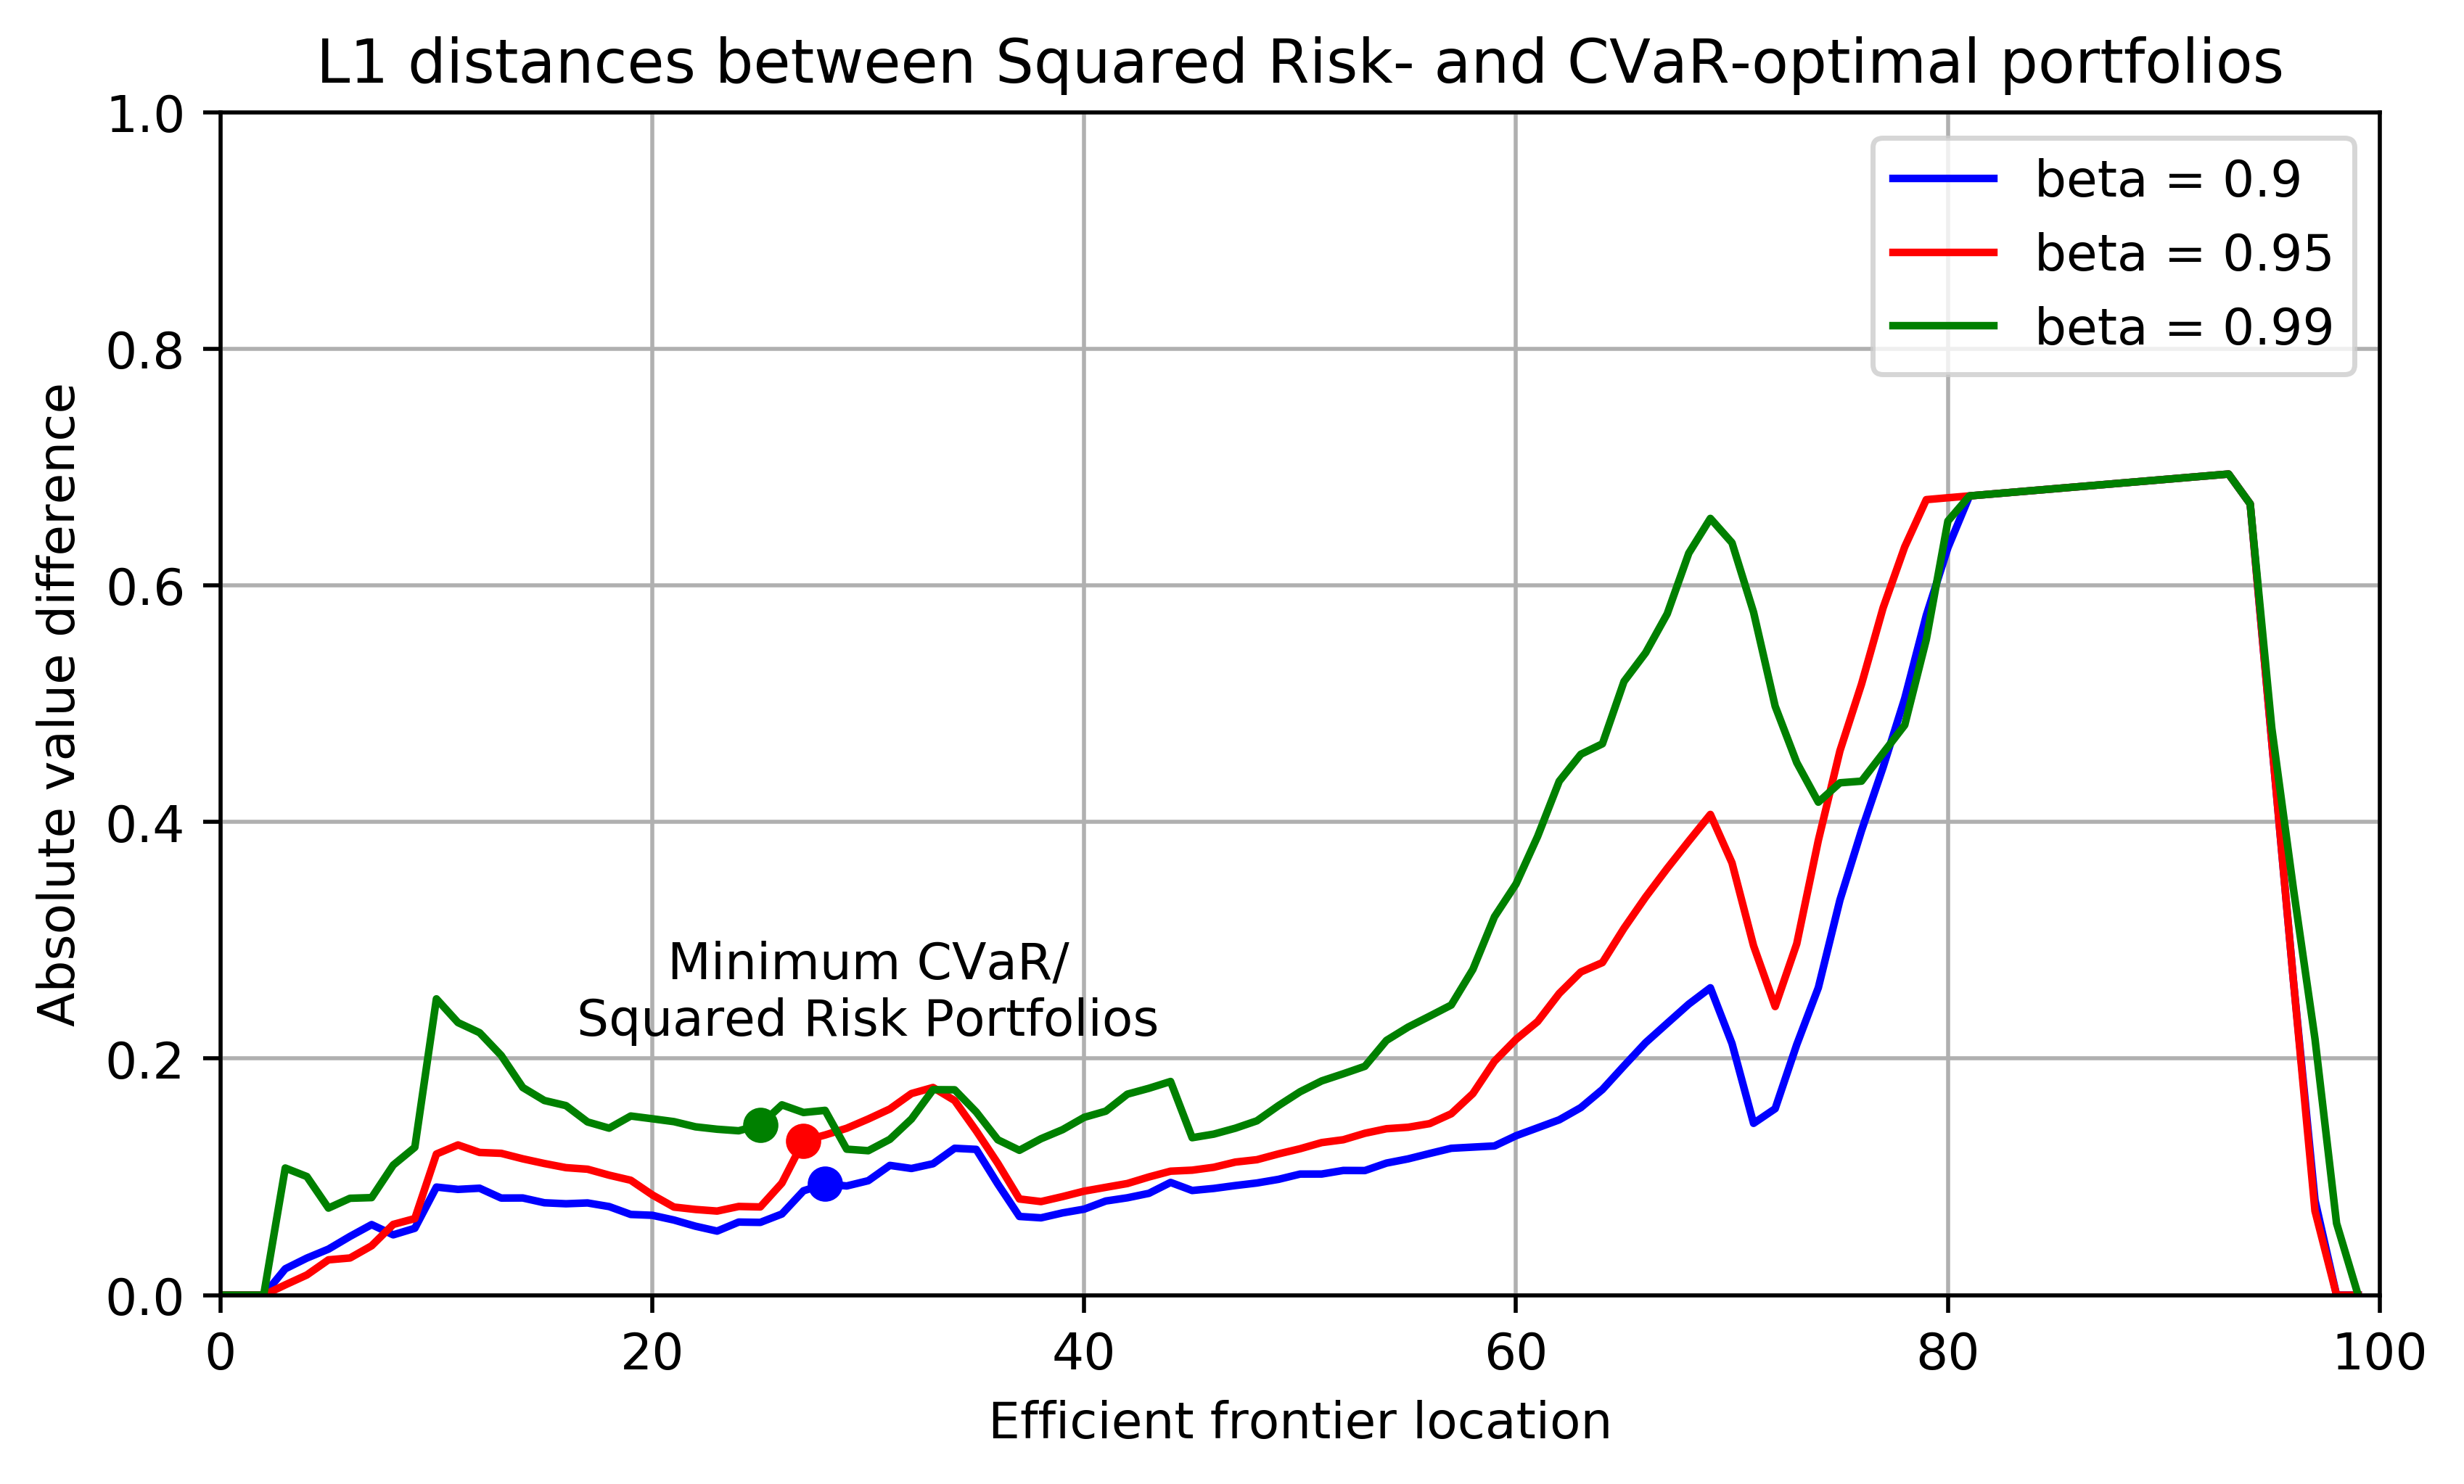

In [34]:
# Plot volatility versus expected return for individual stocks
my_dpi = 500
plt.figure(figsize=(3840/my_dpi, 2160/my_dpi), dpi=my_dpi)
ax = plt.gca()

colors = ["blue","red","green"]
for i,beta in enumerate(betas):

    # Plot volatility versus expected return for minimum risk portfolio
    ax.scatter(x=np.argmin(frontiers[i,:]), y=alloc_diffs[i,np.argmin(frontiers[i,:])], color=colors[i])
    ax.plot(np.arange(alloc_diffs.shape[1]),alloc_diffs[i,:], color=colors[i], label='beta = ' + str(beta))
    #ax.plot(sq_to_cvar,sq_return_values, color=colors[i+3], label='Markowitz, beta = ' + str(beta))
    if i == 0:
        ax.annotate('Minimum CVaR/\nSquared Risk Portfolios', (np.argmin(frontiers[i,:])+2, 0.3),verticalalignment='top',horizontalalignment="center")
        
# Format and display the final plot
ax.axis([0.0, 100, 0.0, 1.0])
ax.set_xlabel('Efficient frontier location')
ax.set_ylabel('Absolute value difference')
ax.set_title("L1 distances between Squared Risk- and CVaR-optimal portfolios")

ax.legend()
ax.grid()

plt.savefig('l1_allocation_diffs.jpg', dpi=my_dpi)

In [35]:
print("Summary statistics for L1 norm allocation differences:")
print("betas compared:", betas)
print("Mean:")
print(np.mean(alloc_diffs,axis=1))
print("5th percentile:")
print(np.quantile(alloc_diffs,0.05,axis=1))
print("10th percentile:")
print(np.quantile(alloc_diffs,0.1,axis=1))
print("25th percentile:")
print(np.quantile(alloc_diffs,0.25,axis=1))
print("Median:")
print(np.median(alloc_diffs,axis=1))
print("L1 distance at the optimal solution:")
print(np.array([alloc_diffs[i,j] for (i,j) in enumerate(np.argmin(frontiers,axis=1))]))

Summary statistics for L1 norm allocation differences:
betas compared: [0.9, 0.95, 0.99]
Mean:
[0.20974049 0.24708209 0.30496791]
5th percentile:
[0.02114421 0.00824834 0.0729457 ]
10th percentile:
[0.05382654 0.05798652 0.10968842]
25th percentile:
[0.07666066 0.0946331  0.14201208]
Median:
[0.10385365 0.13786332 0.18413517]
L1 distance at the optimal solution:
[0.09409433 0.13036997 0.14396503]


Here we see that while the CVaR values between the two models are actually very similar, the underlying portfolio allocations are not that similar to each other. On average, the $L_1$ distance is around 20 to 30 percent, depending on the value of $\beta$. For the optimal solution, we end up with a cumulative absolute value difference of 8 to 14 percent.

## Varying the number of samples $N$

We now investigate the quality of the solution if we use only a fraction of the data. As we will see in the performance analysis part, the runtime of the Linear Program scales superlinearly with $N$, so if we could get a solution that is close to the original solution in terms of its allocations, this could hugely improve the usability of this approach. 

In [36]:
beta = 0.95
num_points = 100

test_percentages = 0.1 * np.arange(1,10)
approx_diffs = np.zeros((len(test_percentages),num_points))
cvar_model, cvar_portfolio = build_cvar_model(data, beta=beta)
cvar_frontier, cvar_return_values, cvar_portfolio_vals = calculate_efficient_frontier(cvar_model, cvar_portfolio, data, num_points=num_points)

for i,frac in enumerate(test_percentages):
    incomplete_data = data.sample(frac=frac)
    cvar_model, cvar_portfolio = build_cvar_model(incomplete_data, beta=beta)
    approx_cvar_frontier, cvar_return_values, approx_cvar_portfolio_vals = calculate_efficient_frontier(cvar_model, cvar_portfolio, incomplete_data, num_points=num_points)
    
    #calculate L1 differences between Markowitz and CVaR
    approx_diffs[i,:] = np.sum(np.abs(cvar_portfolio_vals - approx_cvar_portfolio_vals),axis=0)

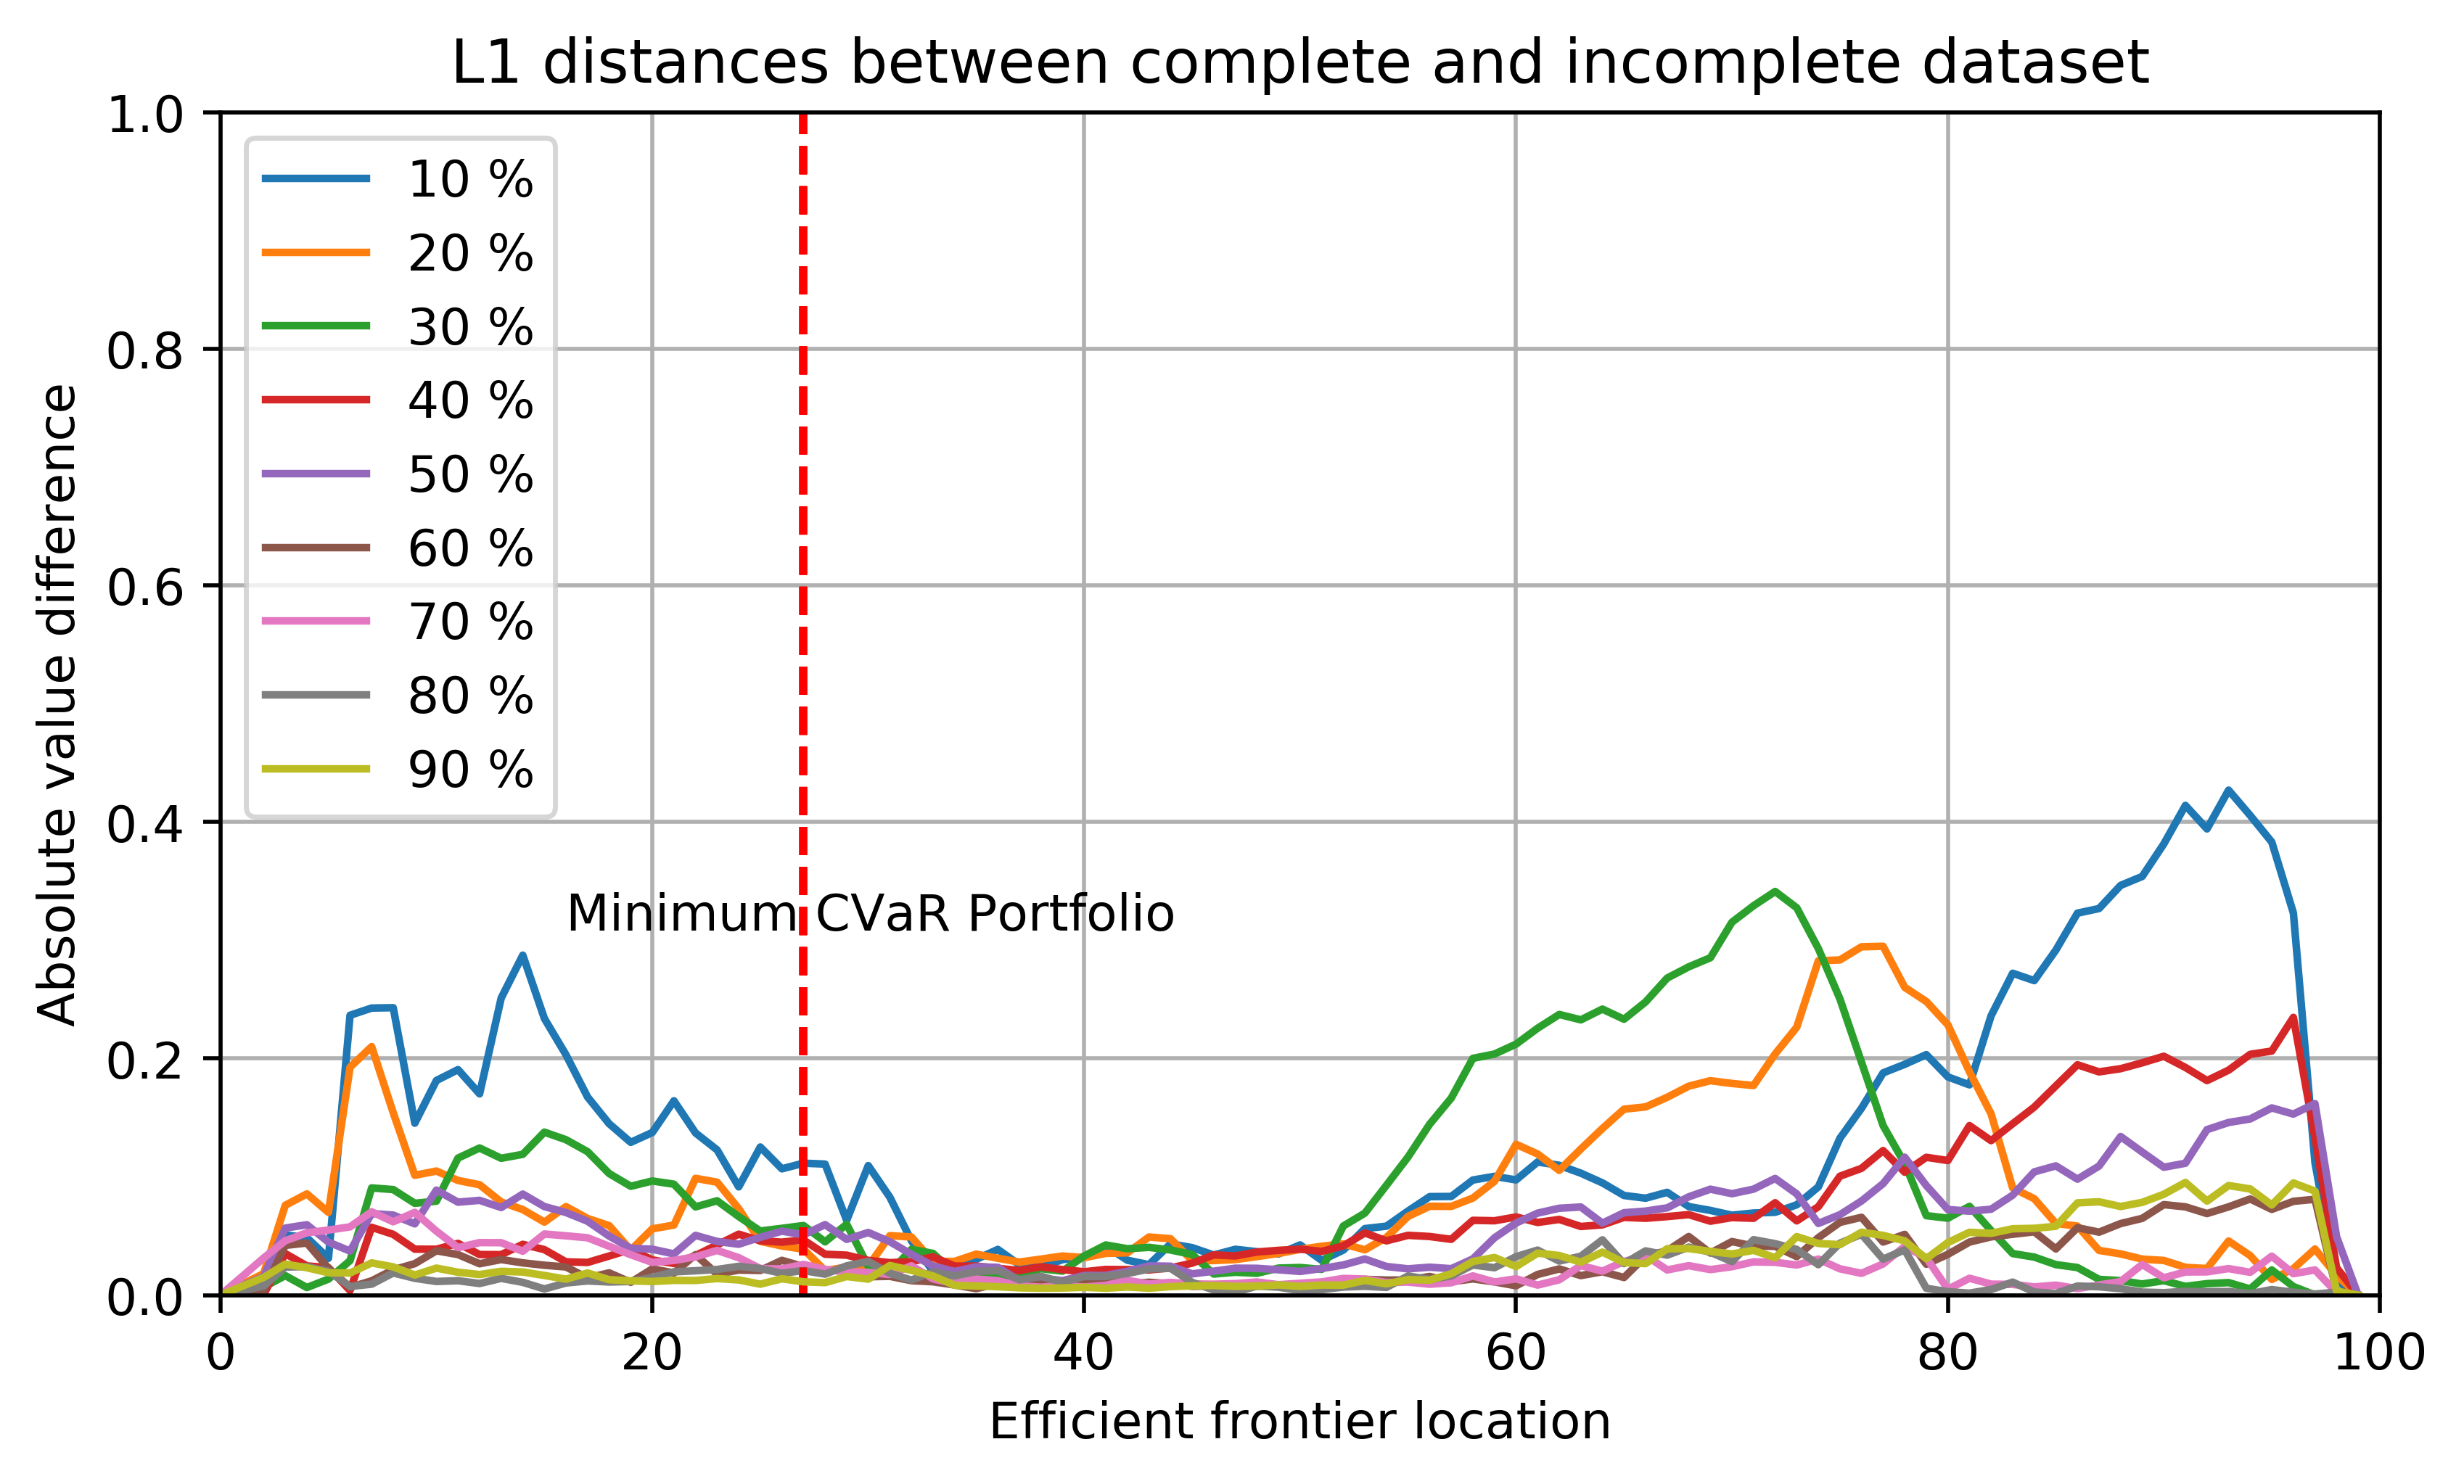

In [62]:
# Plot volatility versus expected return for individual stocks
my_dpi = 500
plt.figure(figsize=(3840/my_dpi, 2160/my_dpi), dpi=my_dpi)
ax = plt.gca()

colors = ["blue","red","green"]

for i,frac in enumerate(test_percentages):

    # Plot volatility versus expected return for minimum risk portfolio
    ax.axvline(x=np.argmin(frontiers[1,:]), color='r', linestyle="--")
    ax.plot(np.arange(approx_diffs.shape[1]),approx_diffs[i,:], label= str(int(100*frac))+' %' )
    if i == 0:
        ax.annotate('Minimum CVaR Portfolio', (16, 0.3),verticalalignment='bottom',horizontalalignment="left")
        
# Format and display the final plot
ax.axis([0.0, 100, 0.0, 1.0])
ax.set_xlabel('Efficient frontier location')
ax.set_ylabel('Absolute value difference')
ax.set_title("L1 distances between complete and incomplete dataset")

ax.legend()
ax.grid()

plt.savefig('frontier_varying_N.jpg', dpi=my_dpi)

In this graph, the differences in $L_1$ norm between the allocations computed with only $k\, \%$ of the dataset and the full dataset are shown. We observe that with exception of a sample size of $10\, \%$, the solutions are fairly similar to the full dataset solution, especially at the global optimum. Again, the performance seems to degrade for higher CVaRs, i.e. points toward the end of the efficient frontier.

In [39]:
print("Summary statistics for L1 norm allocation differences for parts of the dataset:")
print("Percentages compared: 10 - 90% in steps of 10%.")
print("Mean:")
print(np.mean(approx_diffs,axis=1))
print("25th percentile:")
print(np.quantile(approx_diffs,0.25,axis=1))
print("Median:")
print(np.median(approx_diffs,axis=1))
print("75th percentile:")
print(np.quantile(approx_diffs,0.75,axis=1))
print("L1 distance at the optimal solution:")
print(approx_diffs[:,np.argmin(cvar_frontier)])

Summary statistics for L1 norm allocation differences for parts of the dataset:
Percentages compared: 10 - 90% in steps of 10%.
Mean:
[0.13386319 0.08633608 0.09051622 0.06746881 0.06088496 0.02811249
 0.02285614 0.01647187 0.02898297]
25th percentile:
[0.04312065 0.03334069 0.0193912  0.02910265 0.02457818 0.01127259
 0.01059078 0.00637336 0.0103324 ]
Median:
[0.09892278 0.05900727 0.05742549 0.04534648 0.05957073 0.02112763
 0.01955254 0.01421359 0.01915081]
75th percentile:
[0.18858136 0.1089432  0.12206989 0.06974074 0.08347864 0.0415969
 0.03070737 0.02331611 0.03925462]
L1 distance at the optimal solution:
[0.11155147 0.0388374  0.05883873 0.04668462 0.05096239 0.02411714
 0.02592467 0.02077318 0.01129429]


We see that contrary to intuition, the error does not decrease as we use a larger part of the dataset. This could imply that the convergence to the underlying probability distribution is very slow.

# Testing the performance as a function of $N$

In [64]:
#gives 50 data points to calculate in our performance analysis
perf_num_points = 50
num_runs = 10
num_scen = data.shape[0]

#gives an equidistant partition of our range from 0 to number of scenarios (50000 in our case)
points_range = int((num_scen / perf_num_points)) * np.arange(1,perf_num_points+1) + (num_scen % perf_num_points) - 1 #arrays start at zero
print(points_range)

[  999  1999  2999  3999  4999  5999  6999  7999  8999  9999 10999 11999
 12999 13999 14999 15999 16999 17999 18999 19999 20999 21999 22999 23999
 24999 25999 26999 27999 28999 29999 30999 31999 32999 33999 34999 35999
 36999 37999 38999 39999 40999 41999 42999 43999 44999 45999 46999 47999
 48999 49999]


In [65]:
#Initialize empty containers to hold our performance means and standard deviations
means = []
stddevs = []

for num_rows in points_range:

    #select the first n columns
    model_data = data.head(num_rows)
    times = []
    
    #this builds our model
    m, x = build_cvar_model(model_data)
    
    #for loop for different runs 
    for k in range(num_runs):
            
        m.setParam('OutputFlag', 0)

        start = time.time()
        m.optimize()
        end = time.time()

        times.append(end-start)
        m.reset(1)

    mean = np.mean(times)
    std = np.std(times)

    means.append(mean)
    stddevs.append(std)

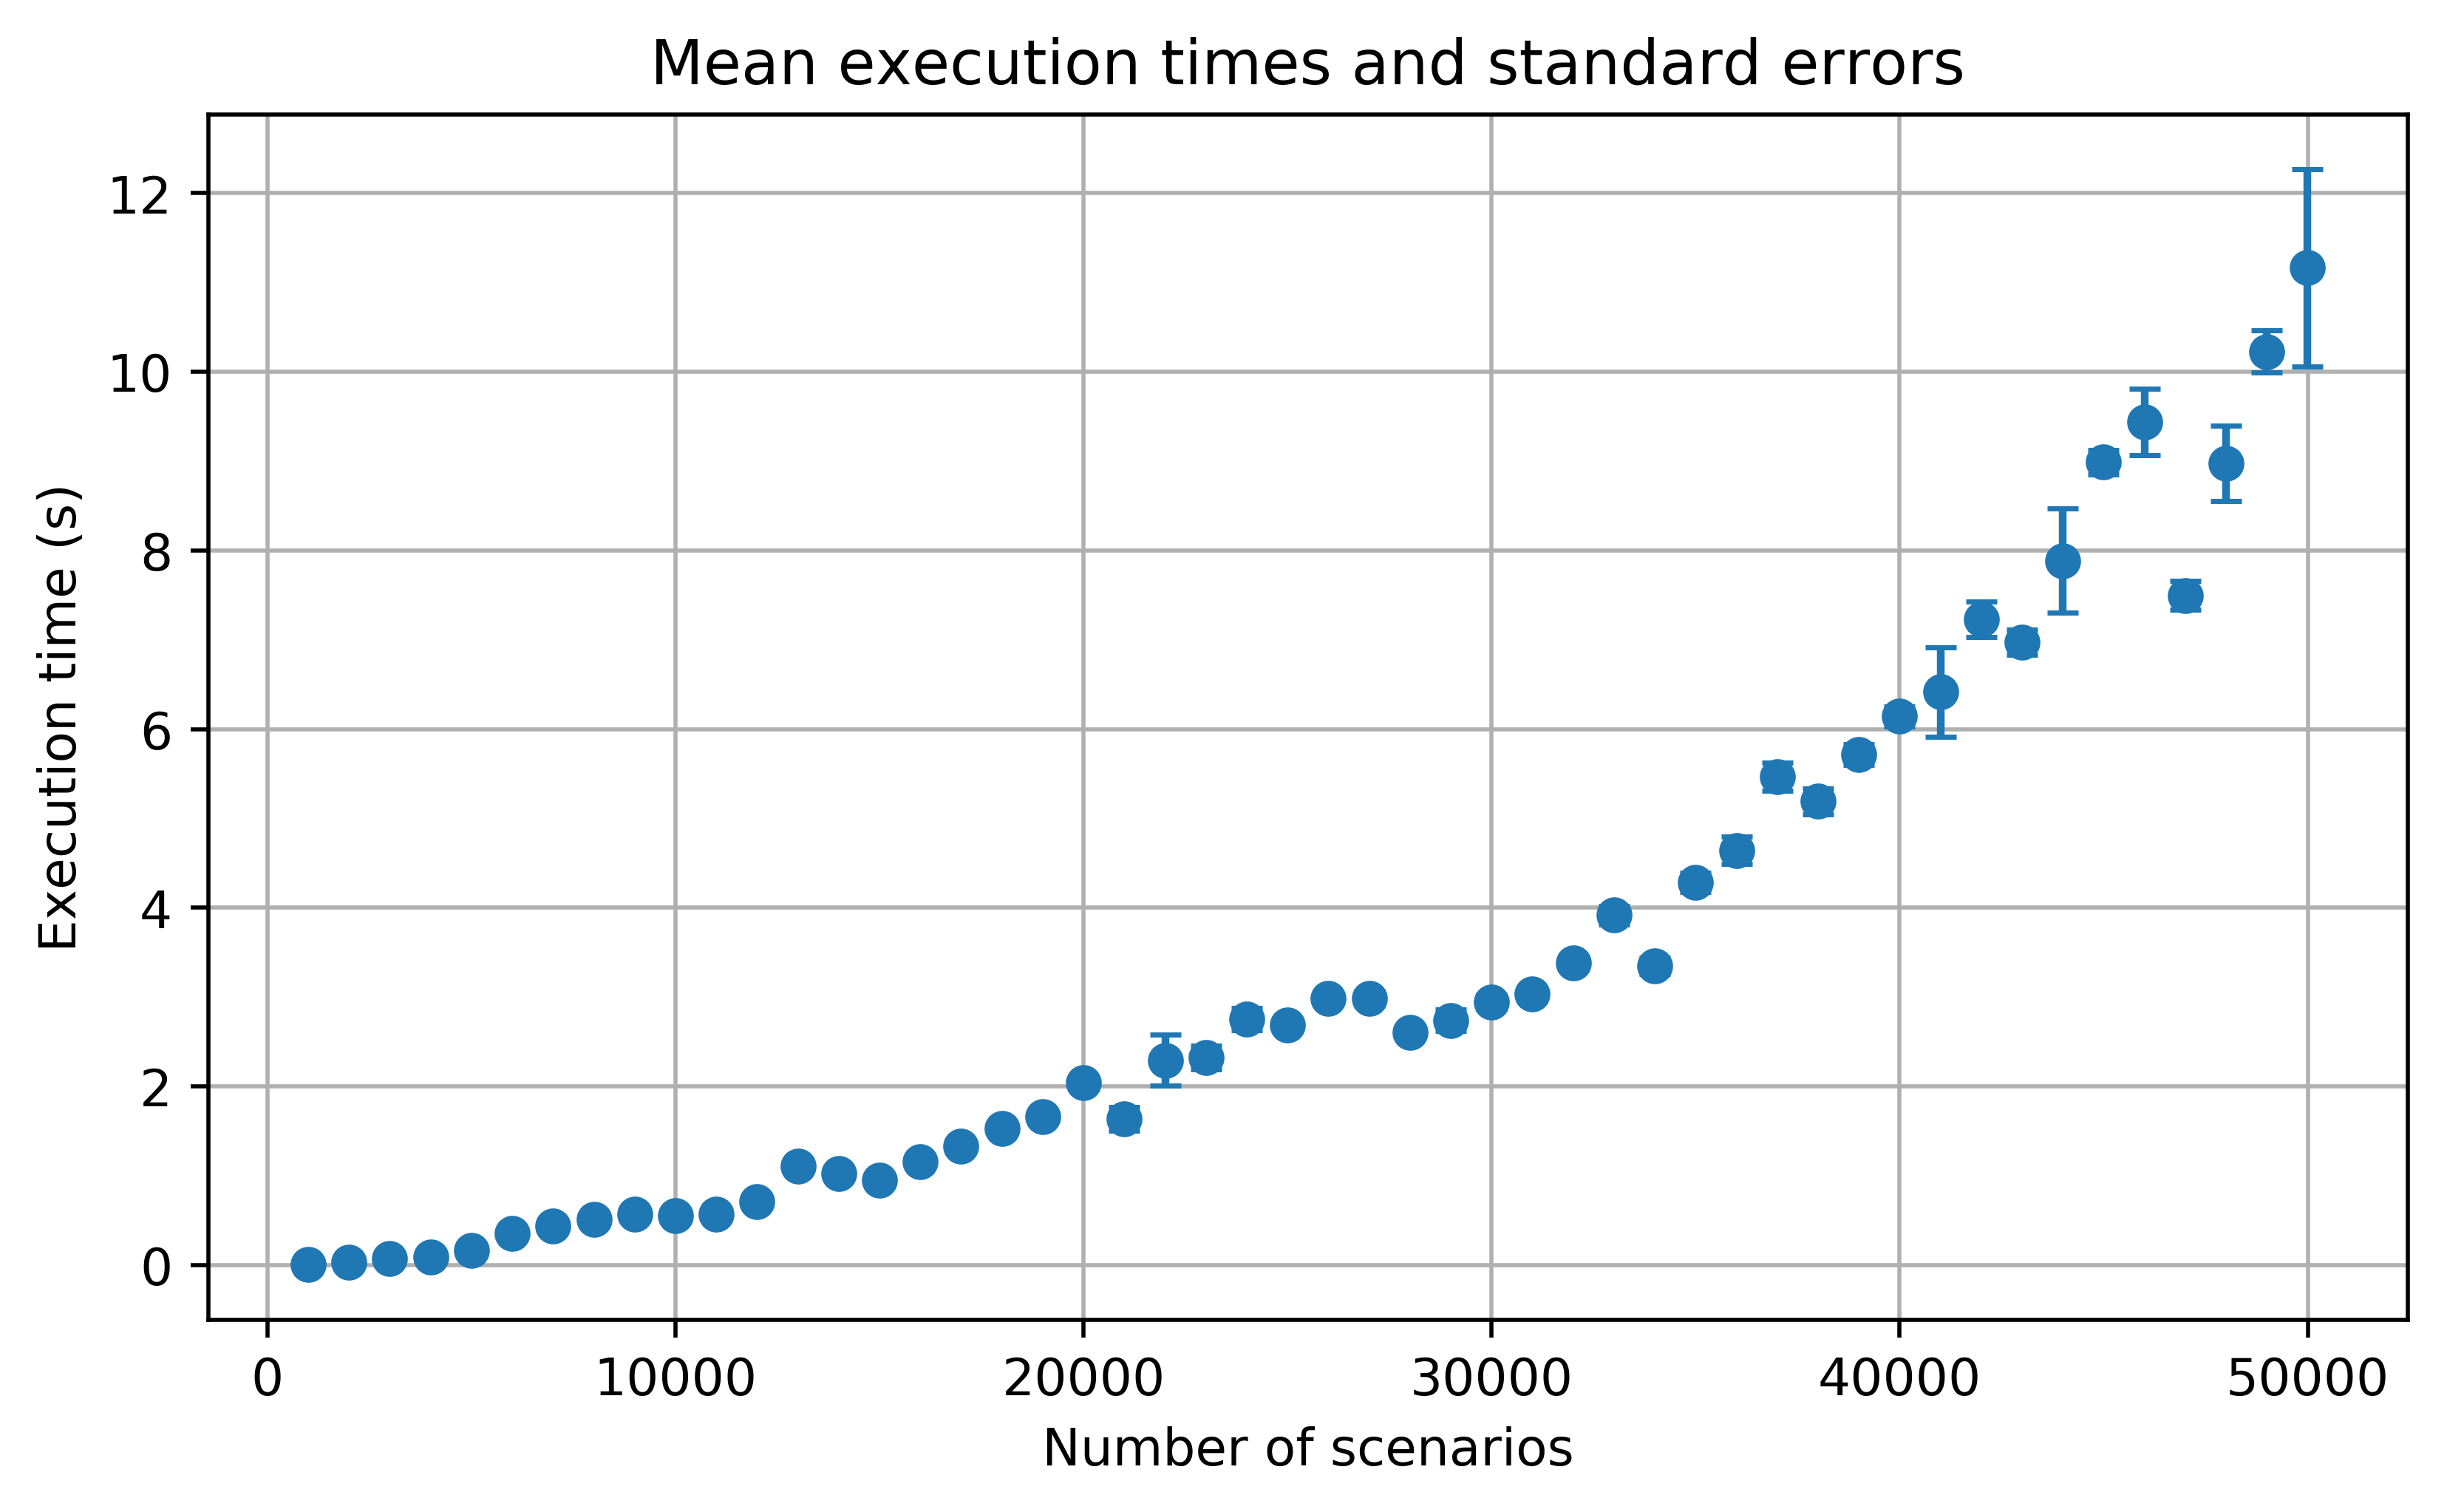

In [75]:
my_dpi = 500
plt.figure(figsize=(3840/my_dpi, 2160/my_dpi), dpi=my_dpi)
plt.xlabel('Number of scenarios')
plt.ylabel('Execution time (s)')
#plt.yscale("log")
plt.grid(True)
plt.errorbar(points_range, means, yerr=stddevs, fmt='o',capsize=3)
plt.title("Mean execution times and standard errors")
plt.savefig('cvar_runtime.jpg', dpi=my_dpi)

Except for a few points, the standard errorbars are smaller than the points themselves. We observe that the execution time scales nonlinearly with the size of the dataset $N$. This indicates that if we can model the probability distribution underlying the assets better, we can save a lot of computation time in the process.

# Including diversity by adding penalty terms

The issue of adding diversity still has to be addressed, as we required it to be a solution property of a good model. However, with the normal CVaR linear program, many of the portfolios on the efficient frontier seem to allocate the investments into very few assets. To counteract this, we will add $L_1$ and $L_2$-norm penalty terms $\left\lVert x - x_0 \right\rVert_1$ and $\left\lVert x - x_0 \right\rVert_2$ to the objective function that promote portfolios closer to the equally distributed solution $x_0 = (1,1,...,1) / n$. 

First, we look exclusively at $L_1$ norm penalization. From a few tries, we see that the penalization has no effect up until a value of about $\rho_1 = 10^{-3}$, and that the solution has converged to the equally weighted portfolio at the value $\rho_1 = 0.15$ within reasonable precision bounds.

We observe that the curve is concave this time. Also, the penalization constant $\rho_2$ can be set in different orders of magnitude than the constant $\rho_1$, since in this case, the solution has not converged against the equal weight portfolio. Therefore, we will rerun the whole process with regularization values $\rho_1 \in [0.001,0.15]$ and $\rho_2 \in [0.001,10000]$.

In [76]:
equal_weight_portfolio = np.ones(len(assets)) / len(assets)

In [77]:
l1_num_points = 50
l1_rhos = np.linspace(0.01,0.15,num=l1_num_points)

#initialize containers for portfolios, CVaR values, return values, and L1 distances to equal weight portfolio
l1_portfolio_matrix = np.zeros((len(assets),l1_num_points+1))
l1_penalized_cvar_sols = np.zeros(l1_num_points+1)
l1_penalized_return_values = np.zeros(l1_num_points+1)
l1_distances_to_equal = np.zeros(l1_num_points+1)

#first point is unconstrained optimal 
l1_portfolio_matrix[:,0] = unconstrained_optimal
l1_penalized_cvar_sols[0] = unconstrained_mincvar
l1_penalized_return_values[0] = unconstrained_mincvar_return
l1_distances_to_equal[0] = np.sum(np.abs(unconstrained_optimal - equal_weight_portfolio))

In [78]:
for i,rho_1 in enumerate(l1_rhos):
    penalized_model, penalized_portfolio = build_cvar_model(data, beta=0.95)
    penalized_model.setParam('OutputFlag', 0) #verbose mode off
    add_penalization(penalized_model, penalized_portfolio, rho=[rho_1,0.0])
    penalized_model.optimize()
    
    #assigning values and metrics 
    optimal_portfolio = np.array([v.x for v in penalized_portfolio])
    l1_portfolio_matrix[:,i+1] = optimal_portfolio
    l1_penalized_cvar_sols[i+1] = calculate_portfolio_cvar(data,penalized_portfolio,beta=0.95)
    l1_penalized_return_values[i+1] = mean_returns.dot(penalized_portfolio).getValue()  
    l1_distances_to_equal[i+1] = np.sum(np.abs(optimal_portfolio - equal_weight_portfolio))

Now we investigate the effect of $L_2$ penalization exclusively.

In [79]:
#L2 penalization exclusively
#log-linear linspace
l2_num_points = 50
l2_rhos = np.exp(np.linspace(np.log(0.001),np.log(10000),num=l2_num_points))

#containers for portfolios, CVaR values, return values and L1 distances to the equal weight portfolio
l2_portfolio_matrix = np.zeros((len(assets),l2_num_points+1))
l2_penalized_cvar_sols = np.zeros(l2_num_points+1)
l2_penalized_return_values = np.zeros(l2_num_points+1)
l2_distances_to_equal = np.zeros(l2_num_points+1)

#first point is the unconstrained optimal solution
l2_portfolio_matrix[:,0] = unconstrained_optimal
l2_penalized_cvar_sols[0] = unconstrained_mincvar
l2_penalized_return_values[0] = unconstrained_mincvar_return
l2_distances_to_equal[0] = np.sum(np.abs(unconstrained_optimal - np.ones(len(assets))/len(assets)))

In [80]:
for i,rho_2 in enumerate(l2_rhos):
    penalized_model, penalized_portfolio = build_cvar_model(data, beta=0.95)
    penalized_model.setParam('OutputFlag', 0) #verbose mode off
    add_penalization(penalized_model, penalized_portfolio, rho=[0.0,rho_2])
    penalized_model.optimize()
    
    optimal_portfolio = np.array([v.x for v in penalized_portfolio])
    l2_penalized_cvar_sols[i+1] = calculate_portfolio_cvar(data,penalized_portfolio,beta=0.95)
    l2_penalized_return_values[i+1] = mean_returns.dot(penalized_portfolio).getValue()  
    l2_portfolio_matrix[:,i+1] = optimal_portfolio
    l2_distances_to_equal[i+1] = np.sum(np.abs(optimal_portfolio - equal_weight_portfolio))

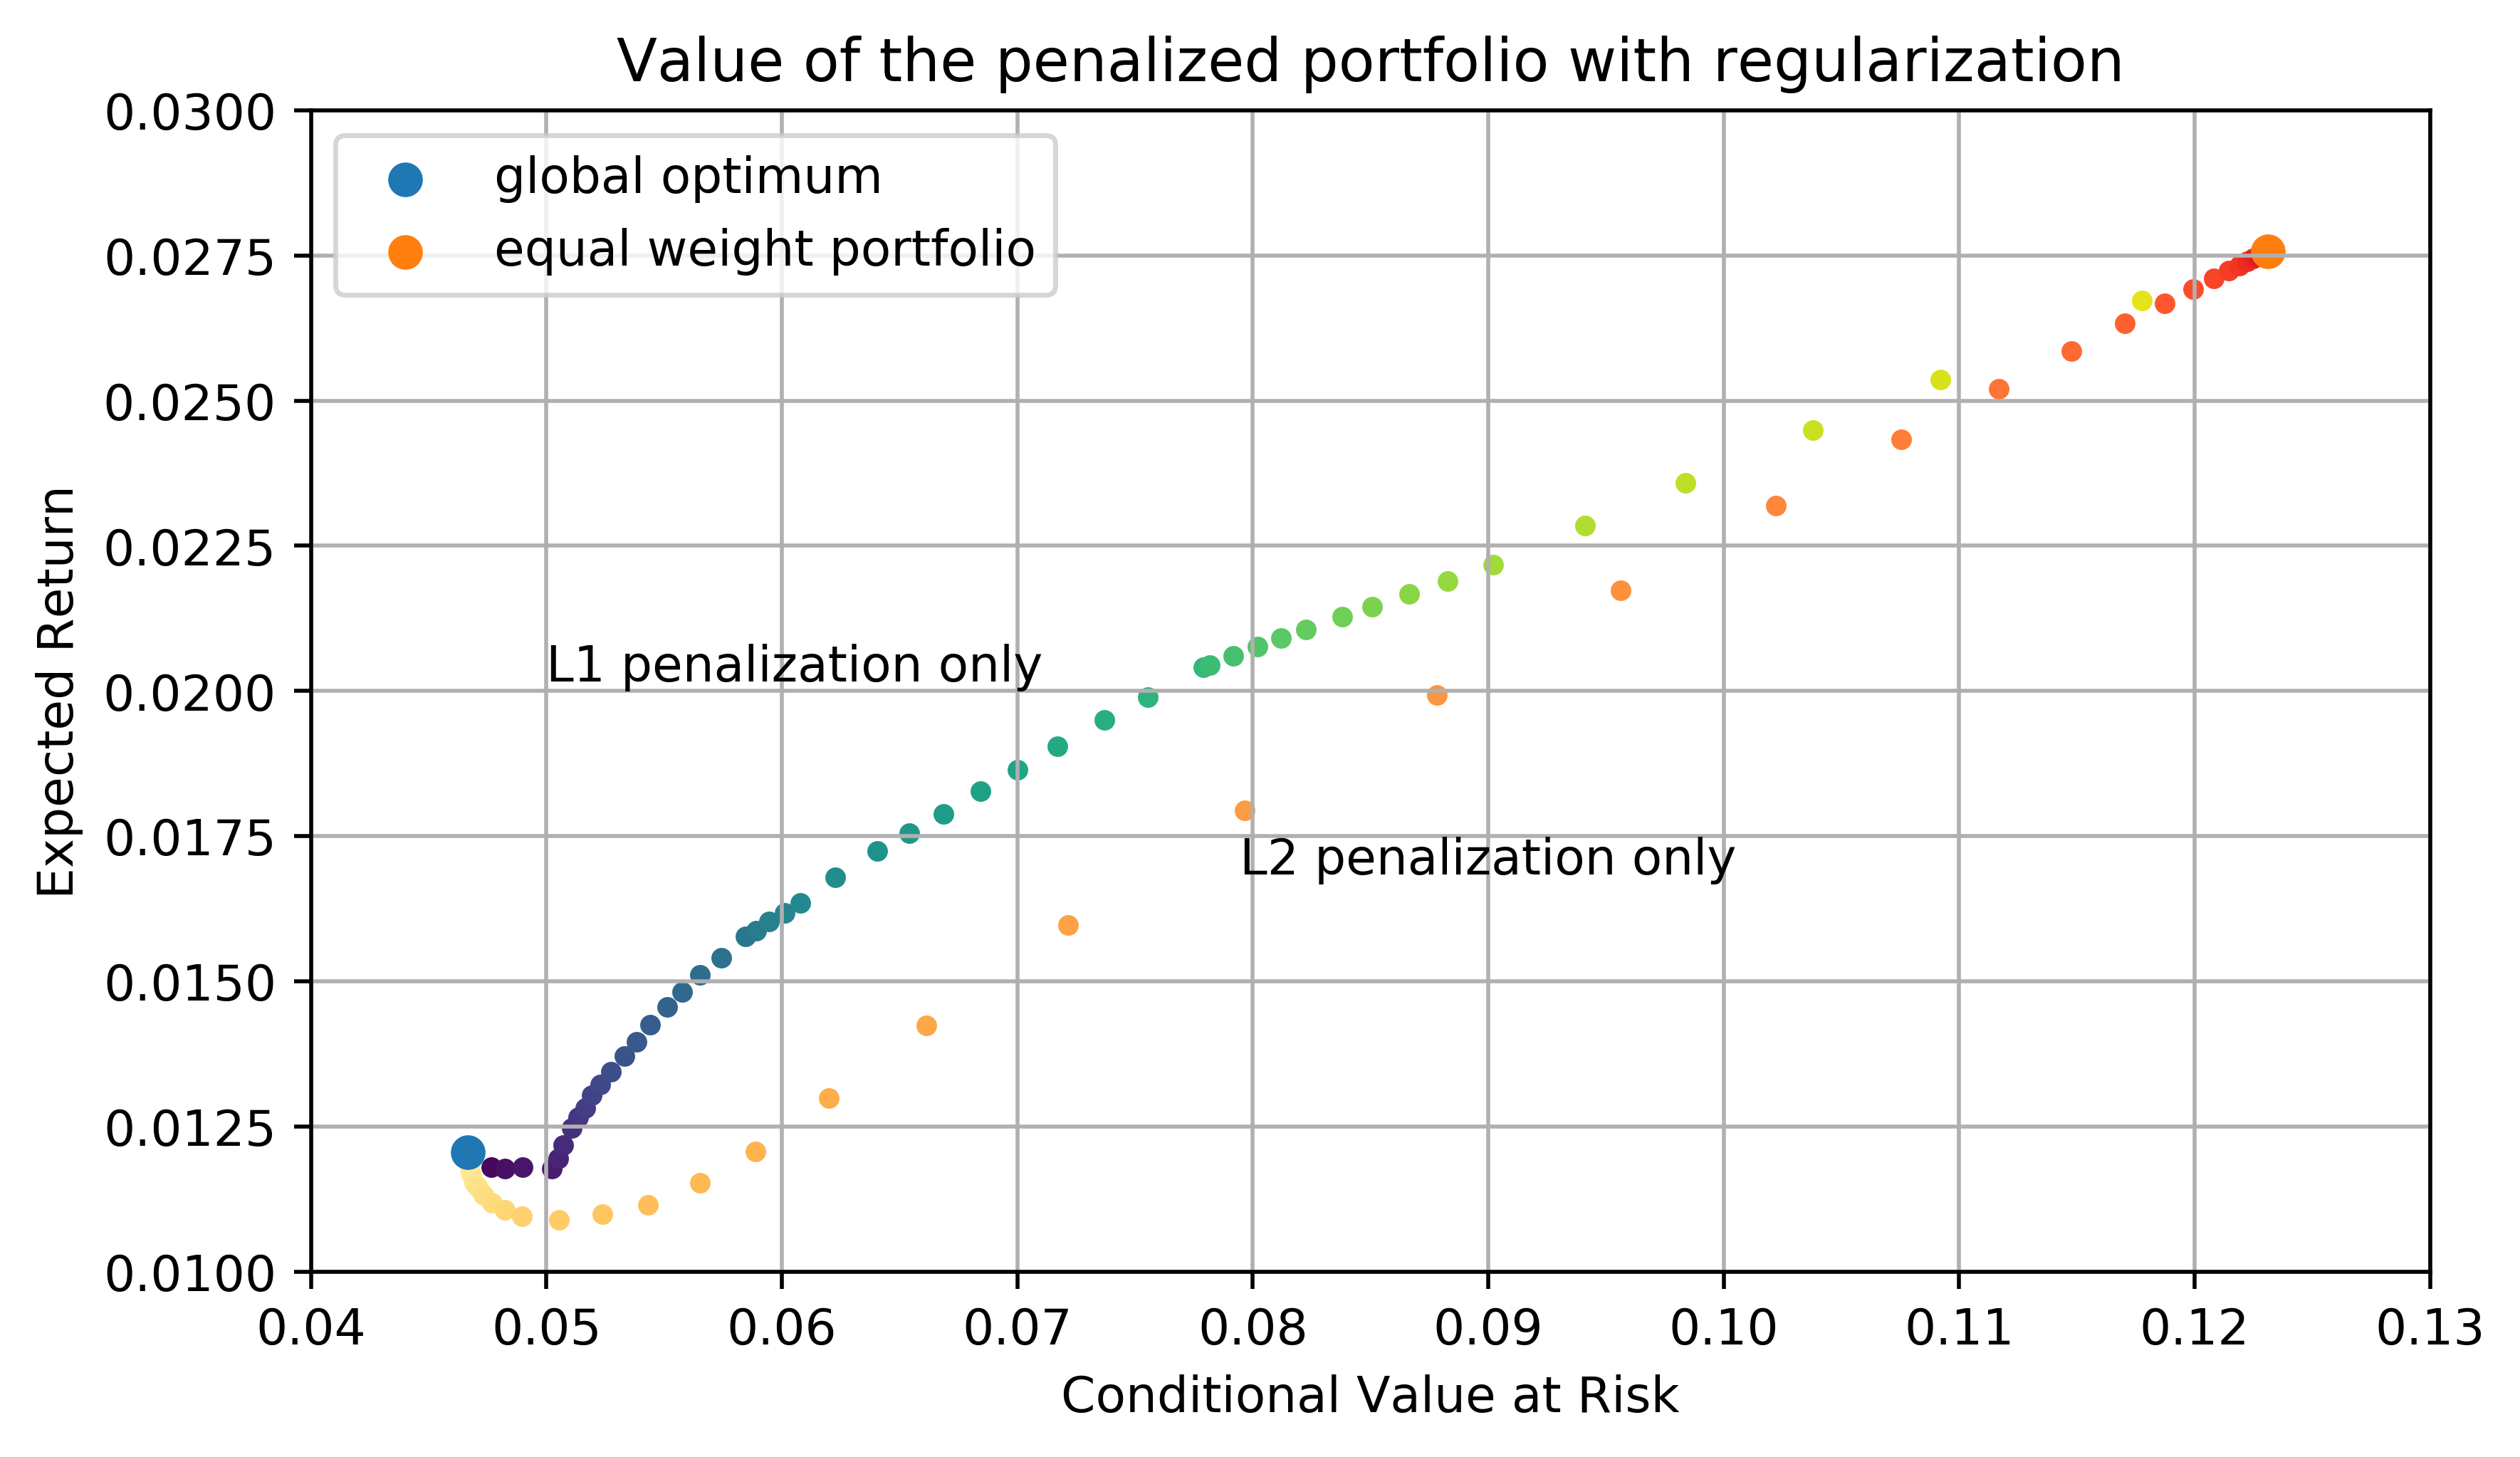

In [81]:
# Plot volatility versus expected return for individual stocks
my_dpi = 500
plt.figure(figsize=(3840/my_dpi, 2160/my_dpi), dpi=my_dpi)
ax = plt.gca()

l1_Ncolors = l1_portfolio_matrix.shape[1]
l2_Ncolors = l2_portfolio_matrix.shape[1]
l1_colormap = plt.cm.viridis
l2_colormap = plt.cm.YlOrRd
l1_Ncolors = min(l1_colormap.N,l1_Ncolors)
l2_Ncolors = min(l2_colormap.N,l2_Ncolors)
l1_mapcolors = [l1_colormap(int(x*l1_colormap.N/l1_Ncolors)) for x in range(l1_Ncolors)]
l2_mapcolors = [l2_colormap(int(x*l2_colormap.N/l2_Ncolors)) for x in range(l2_Ncolors)]

for i,rho in enumerate(l1_rhos):
    
    # Plot CVaR versus expected return for minimum risk portfolio for rho_1 value
    ax.scatter(x=l1_penalized_cvar_sols[i], y=l1_penalized_return_values[i], color=l1_mapcolors[i], s=10)

for i, rho in enumerate(l2_rhos):
    ax.scatter(x=l2_penalized_cvar_sols[i], y=l2_penalized_return_values[i], color=l2_mapcolors[i], s=10)
    
ax.annotate('L1 penalization only', (0.05, 0.02),verticalalignment='bottom',horizontalalignment="left")
ax.annotate('L2 penalization only', (0.09, 0.0175),verticalalignment='top',horizontalalignment="center")
        
ax.scatter(x=calculate_portfolio_cvars(data, l1_portfolio_matrix[:,0].reshape(-1,1), beta=0.95), y=mean_returns.dot(l1_portfolio_matrix[:,0]), label="global optimum")
ax.scatter(x=calculate_portfolio_cvars(data, equal_weight_portfolio[:,np.newaxis], beta=0.95), y=mean_returns.dot(equal_weight_portfolio), label="equal weight portfolio")
# Format and display the final plot
ax.axis([0.04, 0.13, 0.01, 0.03])
ax.set_xlabel('Conditional Value at Risk')
ax.set_ylabel('Expected Return')
ax.set_title("Value of the penalized portfolio with regularization")

ax.legend(loc="upper left")
ax.grid()

plt.savefig('l1_l2_regularization.jpg', dpi=my_dpi)

Now we plot how the distance to the equal weight portfolio $x_0$ changes with the penalization constant. 

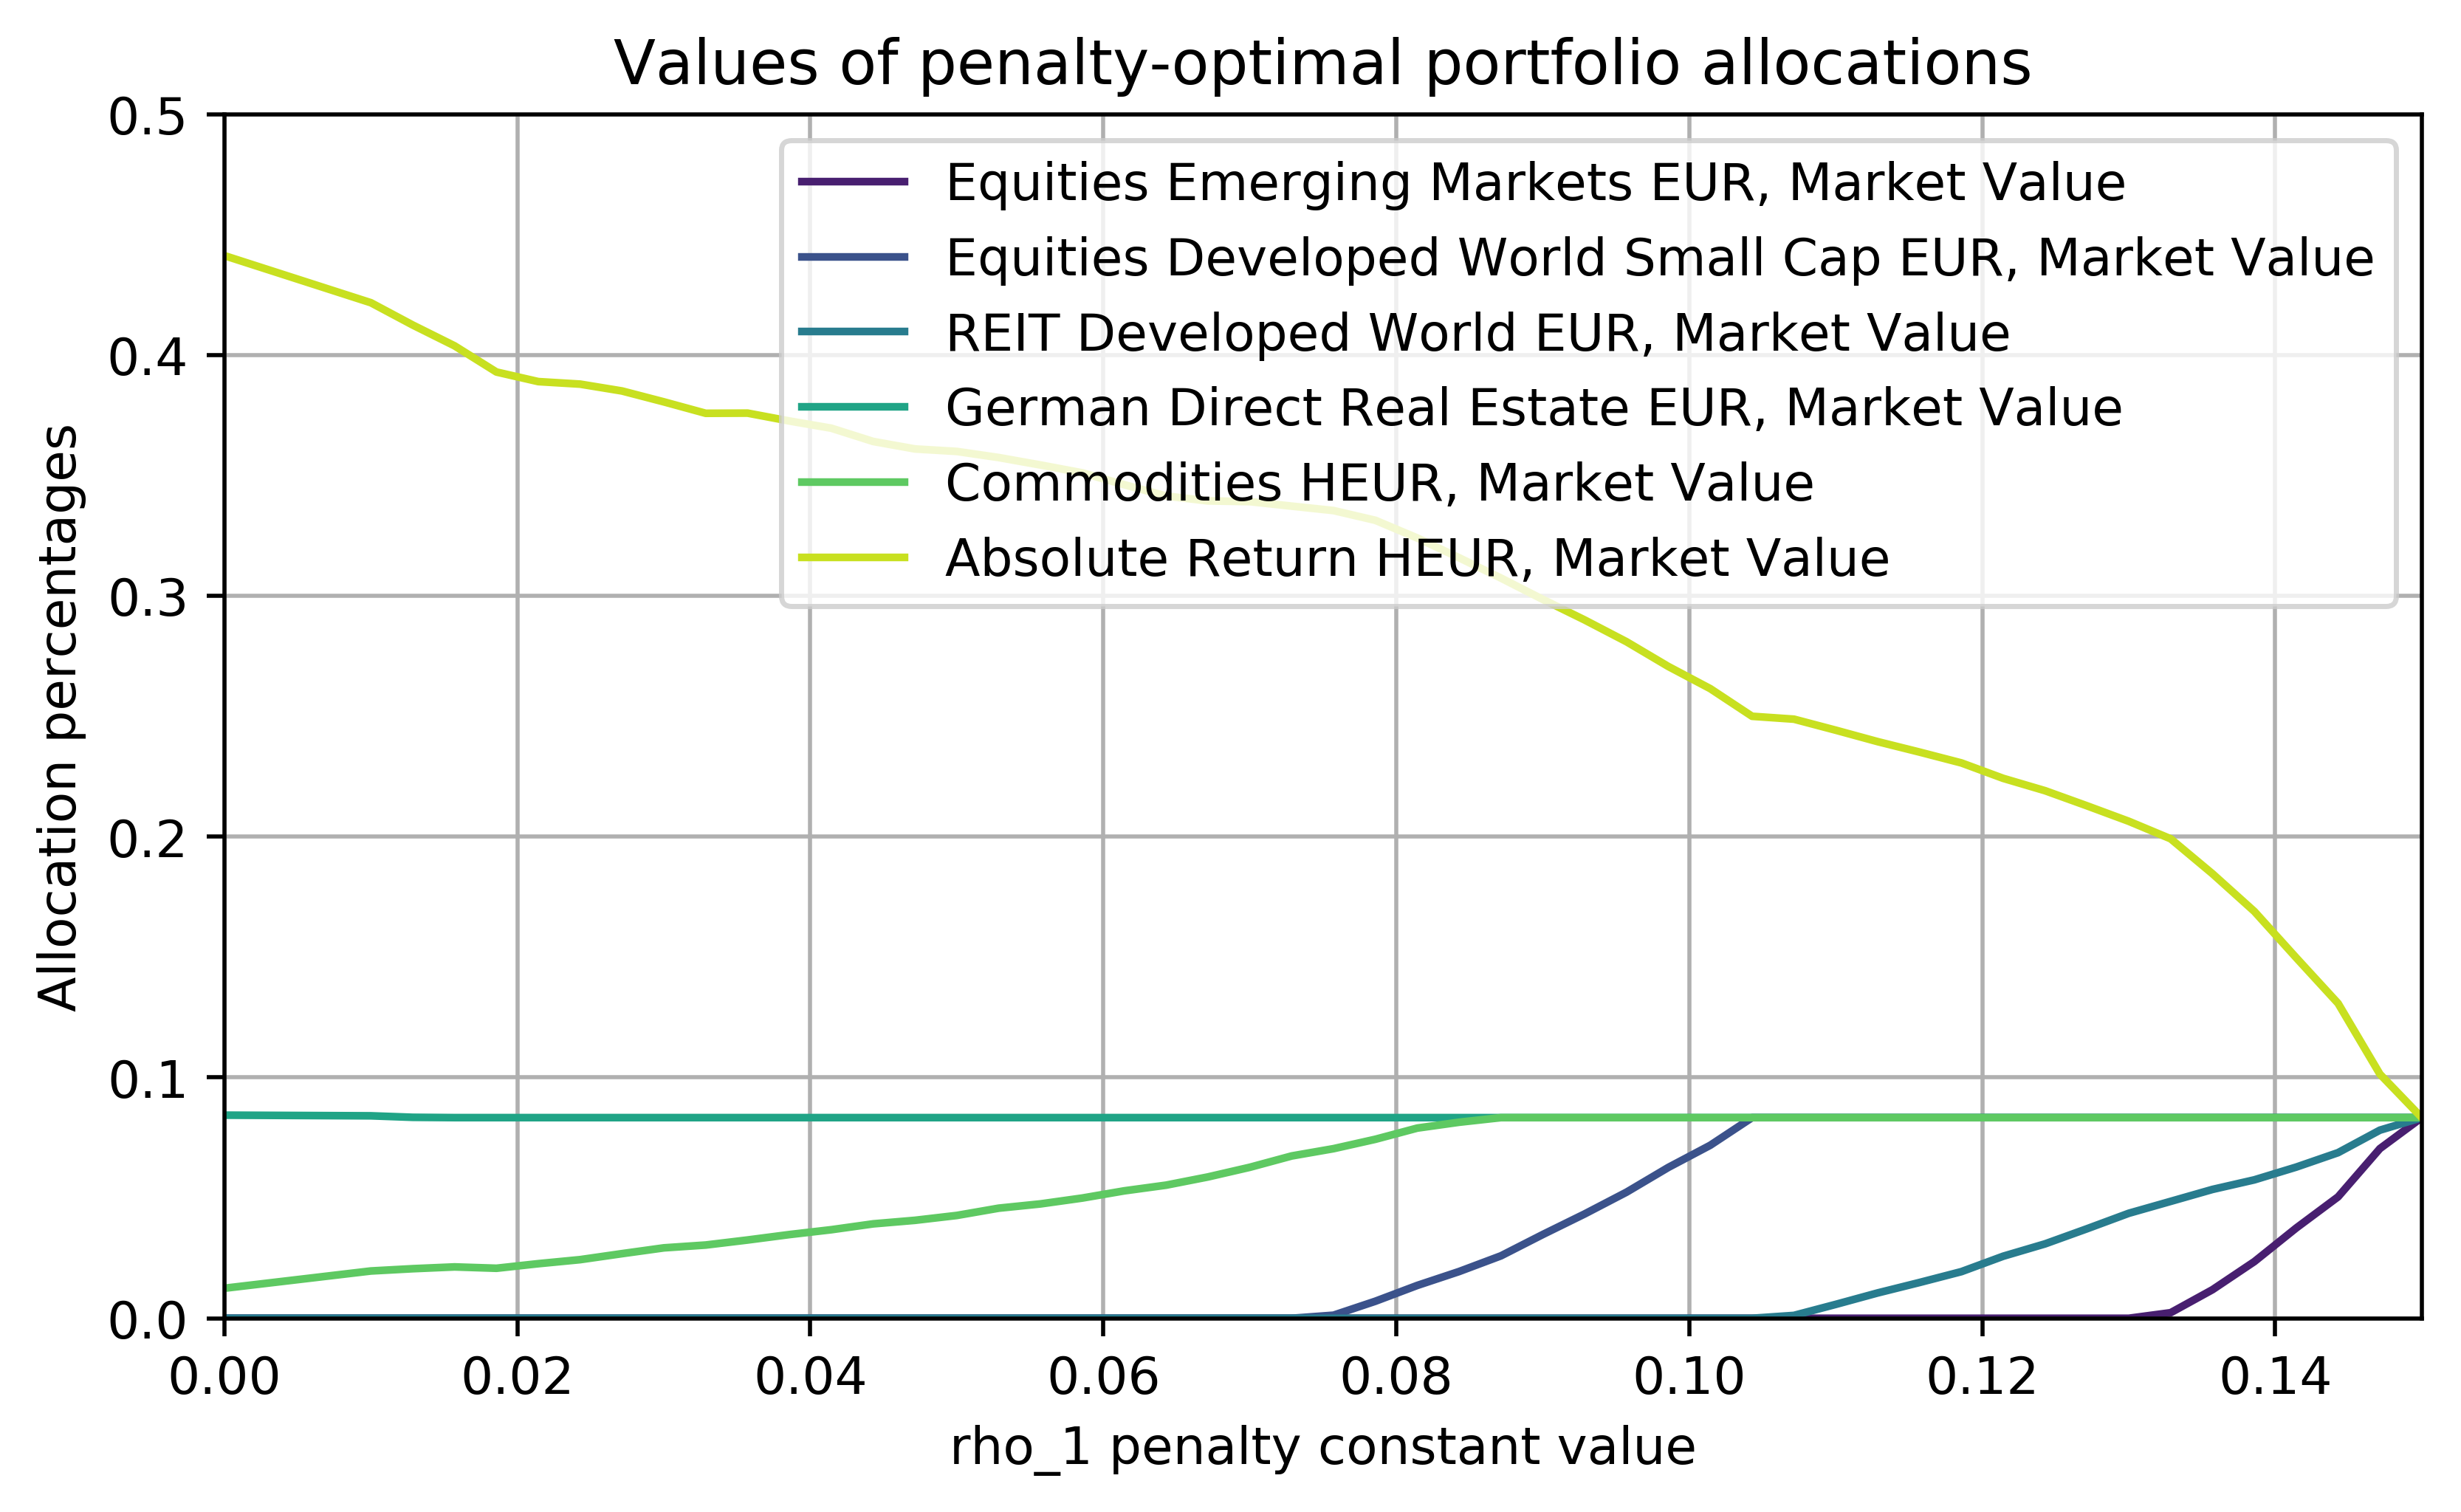

In [82]:
# Plot volatility versus expected return for individual stocks
my_dpi = 500
plt.figure(figsize=(3840/my_dpi, 2160/my_dpi), dpi=my_dpi)
ax = plt.gca()

Ncolors = l1_portfolio_matrix.shape[0]
colormap = plt.cm.viridis
Ncolors = min(colormap.N,Ncolors)
mapcolors = [colormap(int(x*colormap.N/Ncolors)) for x in range(Ncolors)]

#add zero point in front which corresponds to no penalization
l1_rhos_aug = [0.0] + list(l1_rhos)

for i in range(l1_portfolio_matrix.shape[0] // 2, l1_portfolio_matrix.shape[0]):
    # Plot volatility versus expected return for minimum risk portfolio 
    ax.plot(l1_rhos_aug,l1_portfolio_matrix[i,:], label= assets[i] , color=mapcolors[2*(i - l1_portfolio_matrix.shape[0] // 2)+1])
    
# Format and display the final plot
ax.axis([0.0, np.max(l1_rhos), 0.0, 0.5])
ax.set_xlabel('rho_1 penalty constant value')
ax.set_ylabel('Allocation percentages')
ax.set_title("Values of penalty-optimal portfolio allocations")

ax.legend(loc='upper right')
ax.grid()

plt.savefig('rho_1_optimal_allocations_2.jpg', dpi=my_dpi)

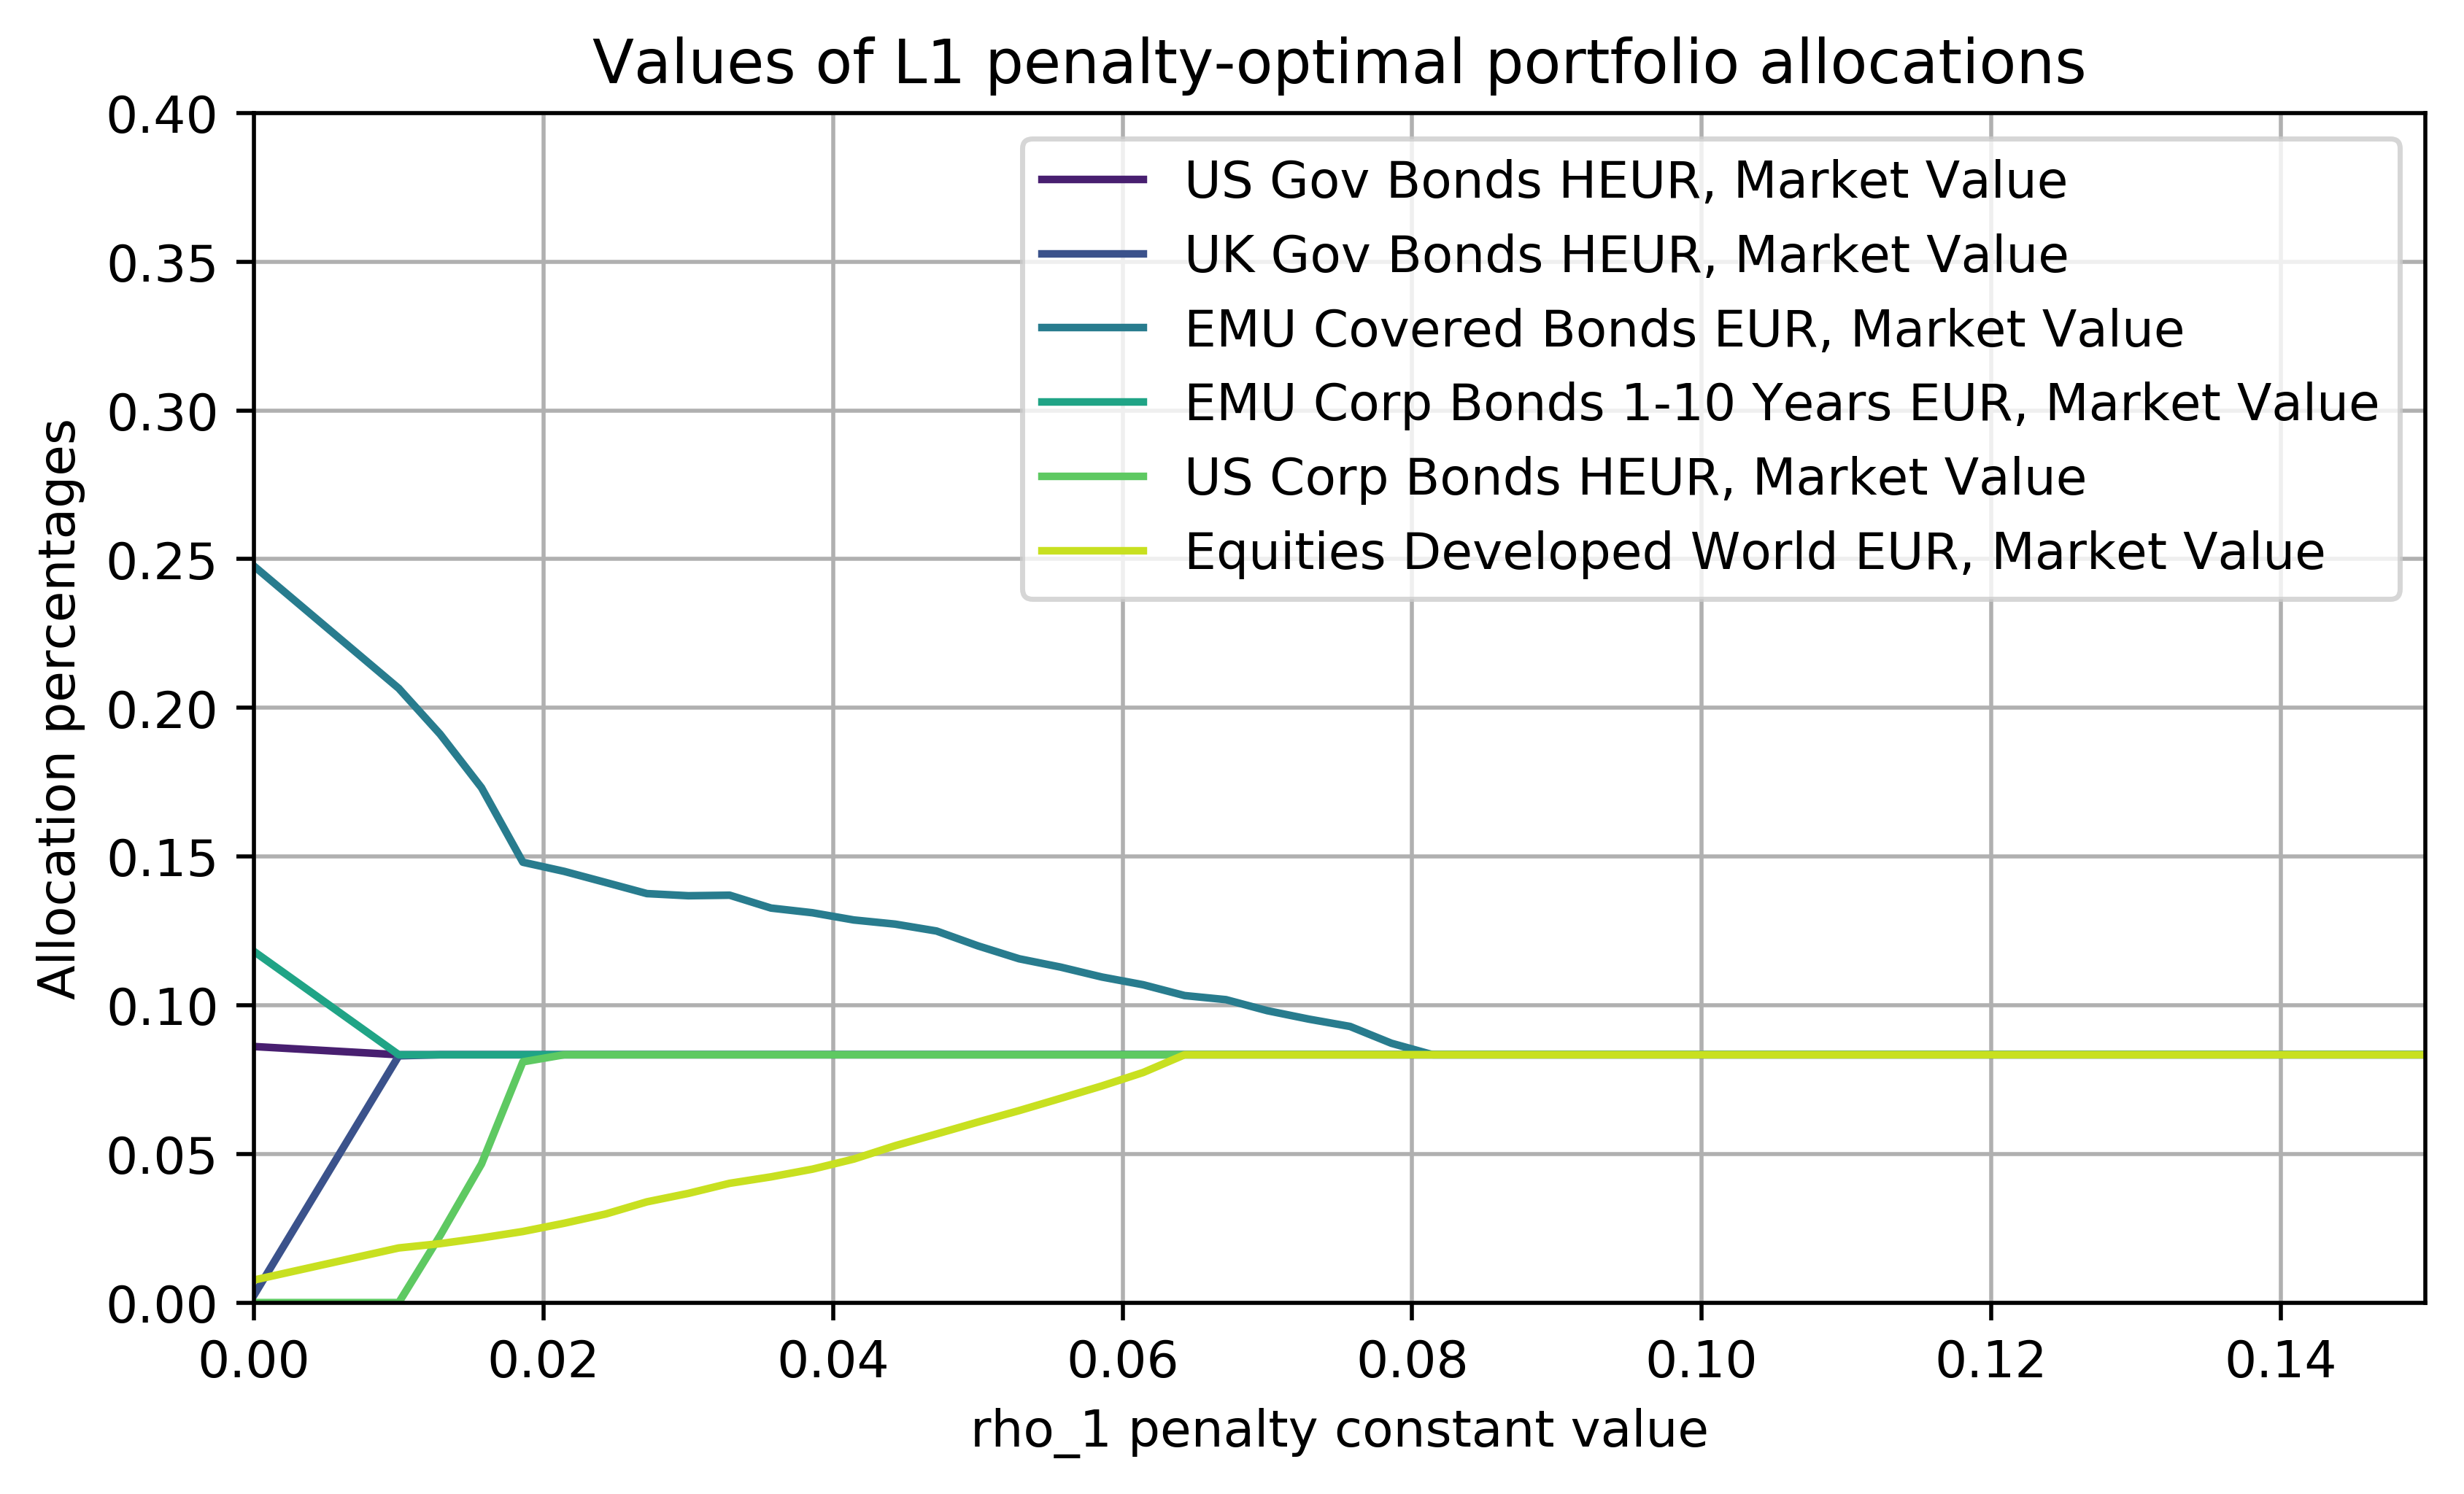

In [83]:
# Plot volatility versus expected return for individual stocks
my_dpi = 500
plt.figure(figsize=(3840/my_dpi, 2160/my_dpi), dpi=my_dpi)
ax = plt.gca()

Ncolors = l1_portfolio_matrix.shape[0]
colormap = plt.cm.viridis
Ncolors = min(colormap.N,Ncolors)
mapcolors = [colormap(int(x*colormap.N/Ncolors)) for x in range(Ncolors)]

for i in range(l1_portfolio_matrix.shape[0] // 2):

    # Plot volatility versus expected return for minimum risk portfolio
    ax.plot(l1_rhos_aug,l1_portfolio_matrix[i,:], label= assets[i], color=mapcolors[2*(i - l1_portfolio_matrix.shape[0] // 2)+1])
    #ax.annotate('Minimum CVaR\nPortfolio', (np.argmin(frontiers[1,:])-2, 0.4),verticalalignment='bottom',horizontalalignment="right")
        
# Format and display the final plot
ax.axis([0.0, np.max(l1_rhos), 0.0, 0.4])
ax.set_xlabel('rho_1 penalty constant value')
ax.set_ylabel('Allocation percentages')
ax.set_title("Values of L1 penalty-optimal portfolio allocations")

ax.legend(loc='upper right')
ax.grid()

plt.savefig('rho_1_optimal_allocations_1.jpg', dpi=my_dpi)

We see that the allocations increase mostly linearly until convergence to $1/n$. The two assets that are allocated above $1/n$ at the unconstrained optimum decrease monotonically and apparently piecewise linearly until convergence. The scale was fixed empirically to $0.15$ because it was observed that the portfolio vector converges with practically infinite speed at a value around $\rho_1 = 0.148$. 

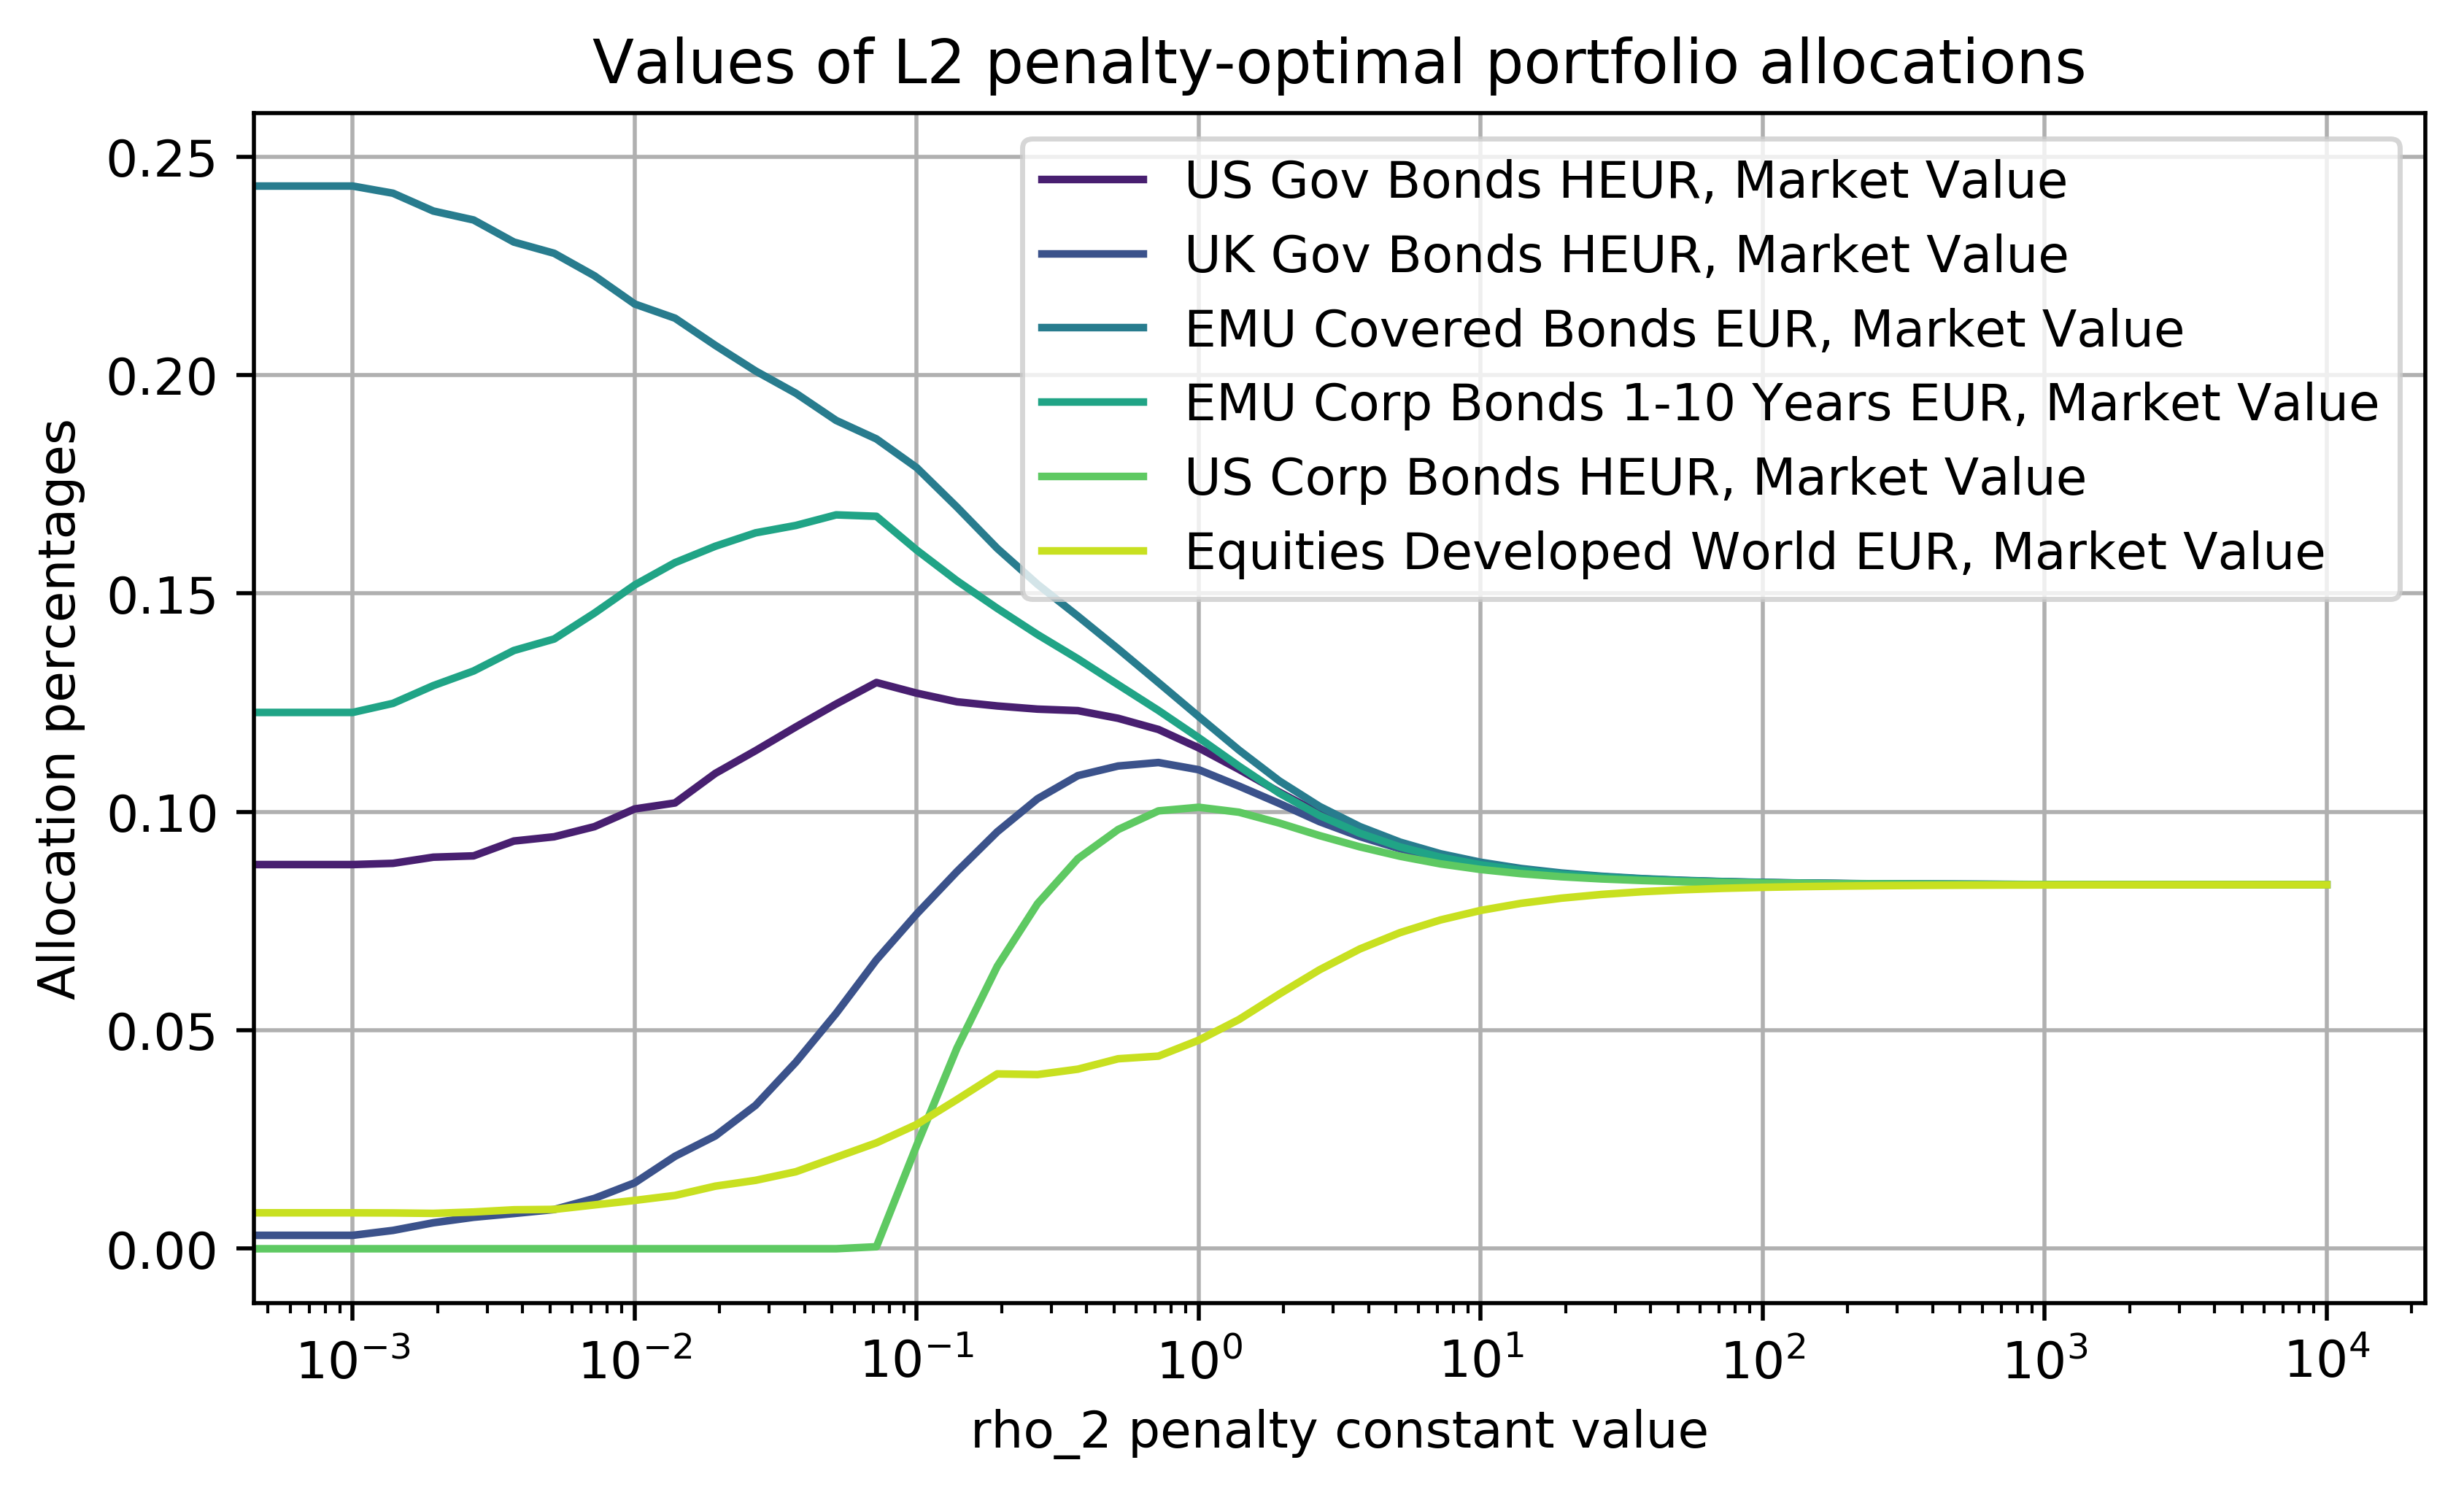

In [84]:
# Plot volatility versus expected return for individual stocks
my_dpi = 500
plt.figure(figsize=(3840/my_dpi, 2160/my_dpi), dpi=my_dpi)
ax = plt.gca()

Ncolors = l2_portfolio_matrix.shape[0]
colormap = plt.cm.viridis
Ncolors = min(colormap.N,Ncolors)
mapcolors = [colormap(int(x*colormap.N/Ncolors)) for x in range(Ncolors)]

#add zero point in front which corresponds to no penalization
l2_rhos_aug = [0.0] + list(l2_rhos)

for i in range(l2_portfolio_matrix.shape[0] // 2):

    # Plot volatility versus expected return for minimum risk portfolio
    ax.plot(l2_rhos_aug,l2_portfolio_matrix[i,:], label= assets[i], color=mapcolors[2*(i - l2_portfolio_matrix.shape[0] // 2)+1])
      
# Format and display the final plot
ax.set_xlabel('rho_2 penalty constant value')
ax.set_ylabel('Allocation percentages')
ax.set_title("Values of L2 penalty-optimal portfolio allocations")

ax.legend(loc='upper right')
ax.grid()
ax.set_xscale("log")

plt.savefig('rho_2_optimal_allocations_1.jpg', dpi=my_dpi)

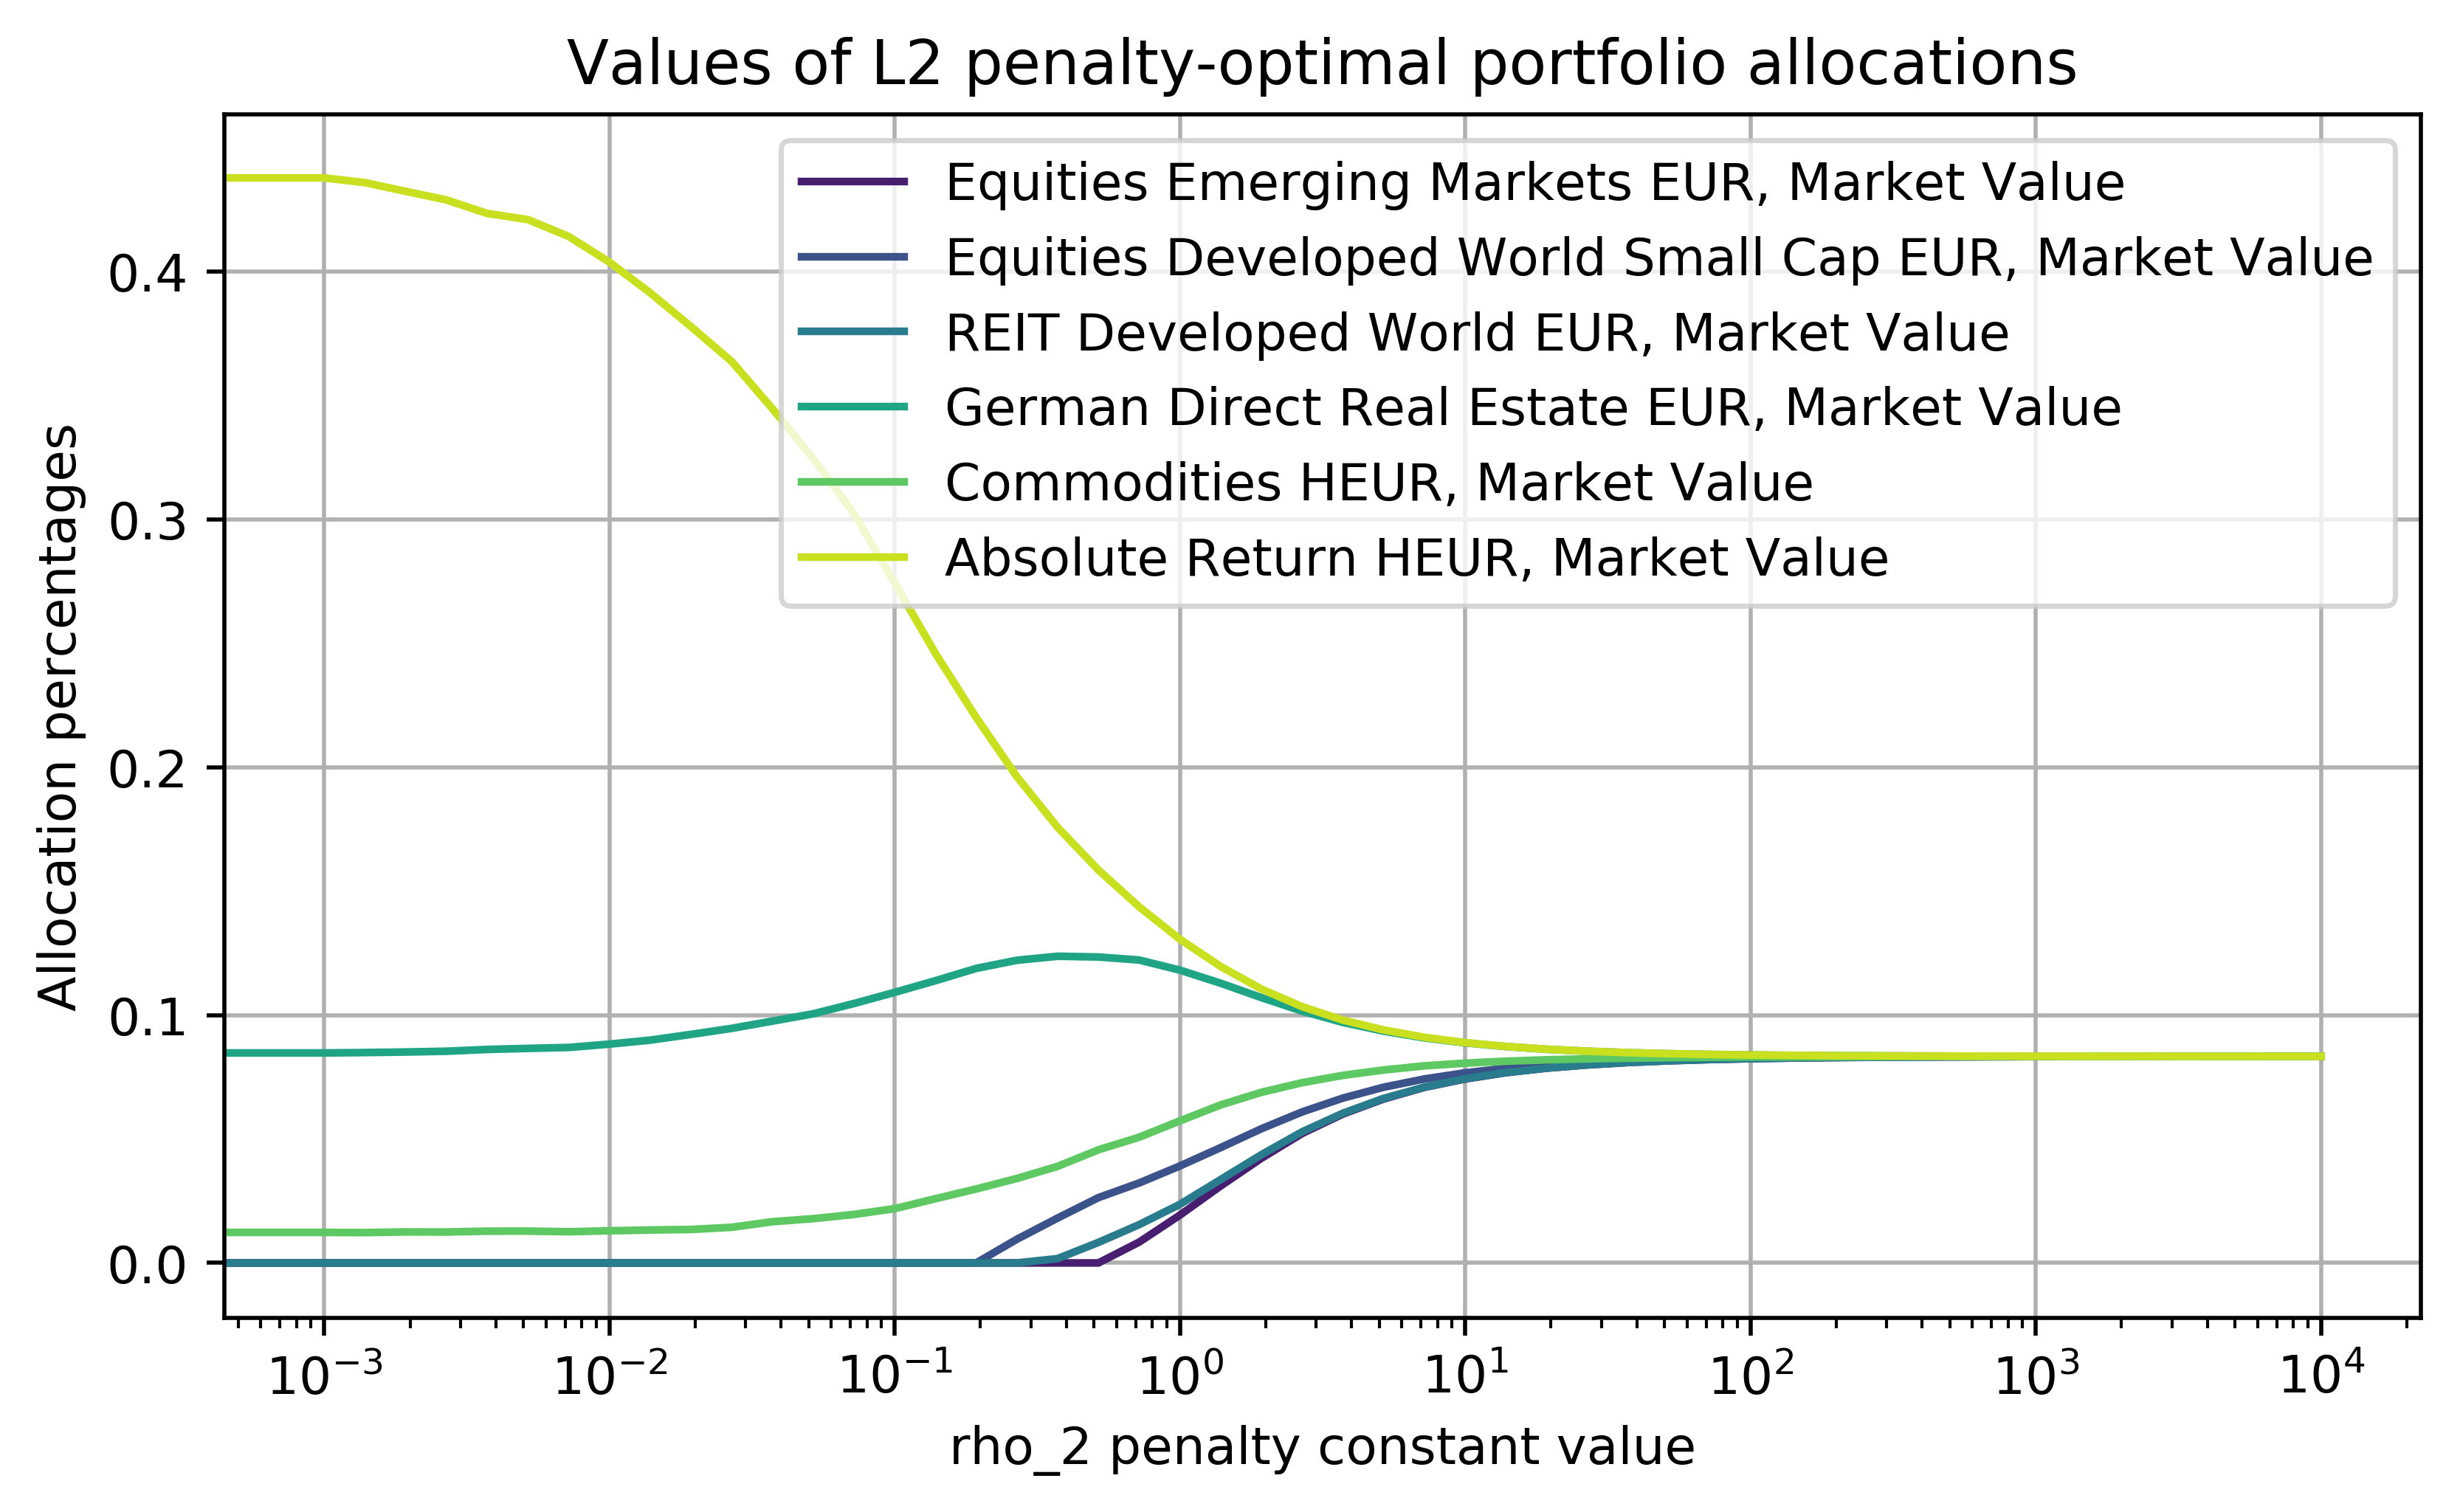

In [85]:
# Plot volatility versus expected return for individual stocks
my_dpi = 500
plt.figure(figsize=(3840/my_dpi, 2160/my_dpi), dpi=my_dpi)
ax = plt.gca()

Ncolors = l2_portfolio_matrix.shape[0]
colormap = plt.cm.viridis
Ncolors = min(colormap.N,Ncolors)
mapcolors = [colormap(int(x*colormap.N/Ncolors)) for x in range(Ncolors)]

for i in range(l2_portfolio_matrix.shape[0] // 2, l2_portfolio_matrix.shape[0]):
    # Plot volatility versus expected return for minimum risk portfolio 
    ax.plot(l2_rhos_aug,l2_portfolio_matrix[i,:], label= assets[i] , color=mapcolors[2*(i - l2_portfolio_matrix.shape[0] // 2)+1])
       
# Format and display the final plot
ax.set_xlabel('rho_2 penalty constant value')
ax.set_ylabel('Allocation percentages')
ax.set_title("Values of L2 penalty-optimal portfolio allocations")

ax.legend(loc='upper right')
ax.grid()
ax.set_xscale("log")

plt.savefig('rho_2_optimal_allocations_2.jpg', dpi=my_dpi)

Here, we see that the allocations change as a nonlinear (possibly quadratic) function. Some of the functions have a clear maximum, others increase monotonically toward $1/n$.

### Distance to the equal weight portfolio as a function of the penalization constant

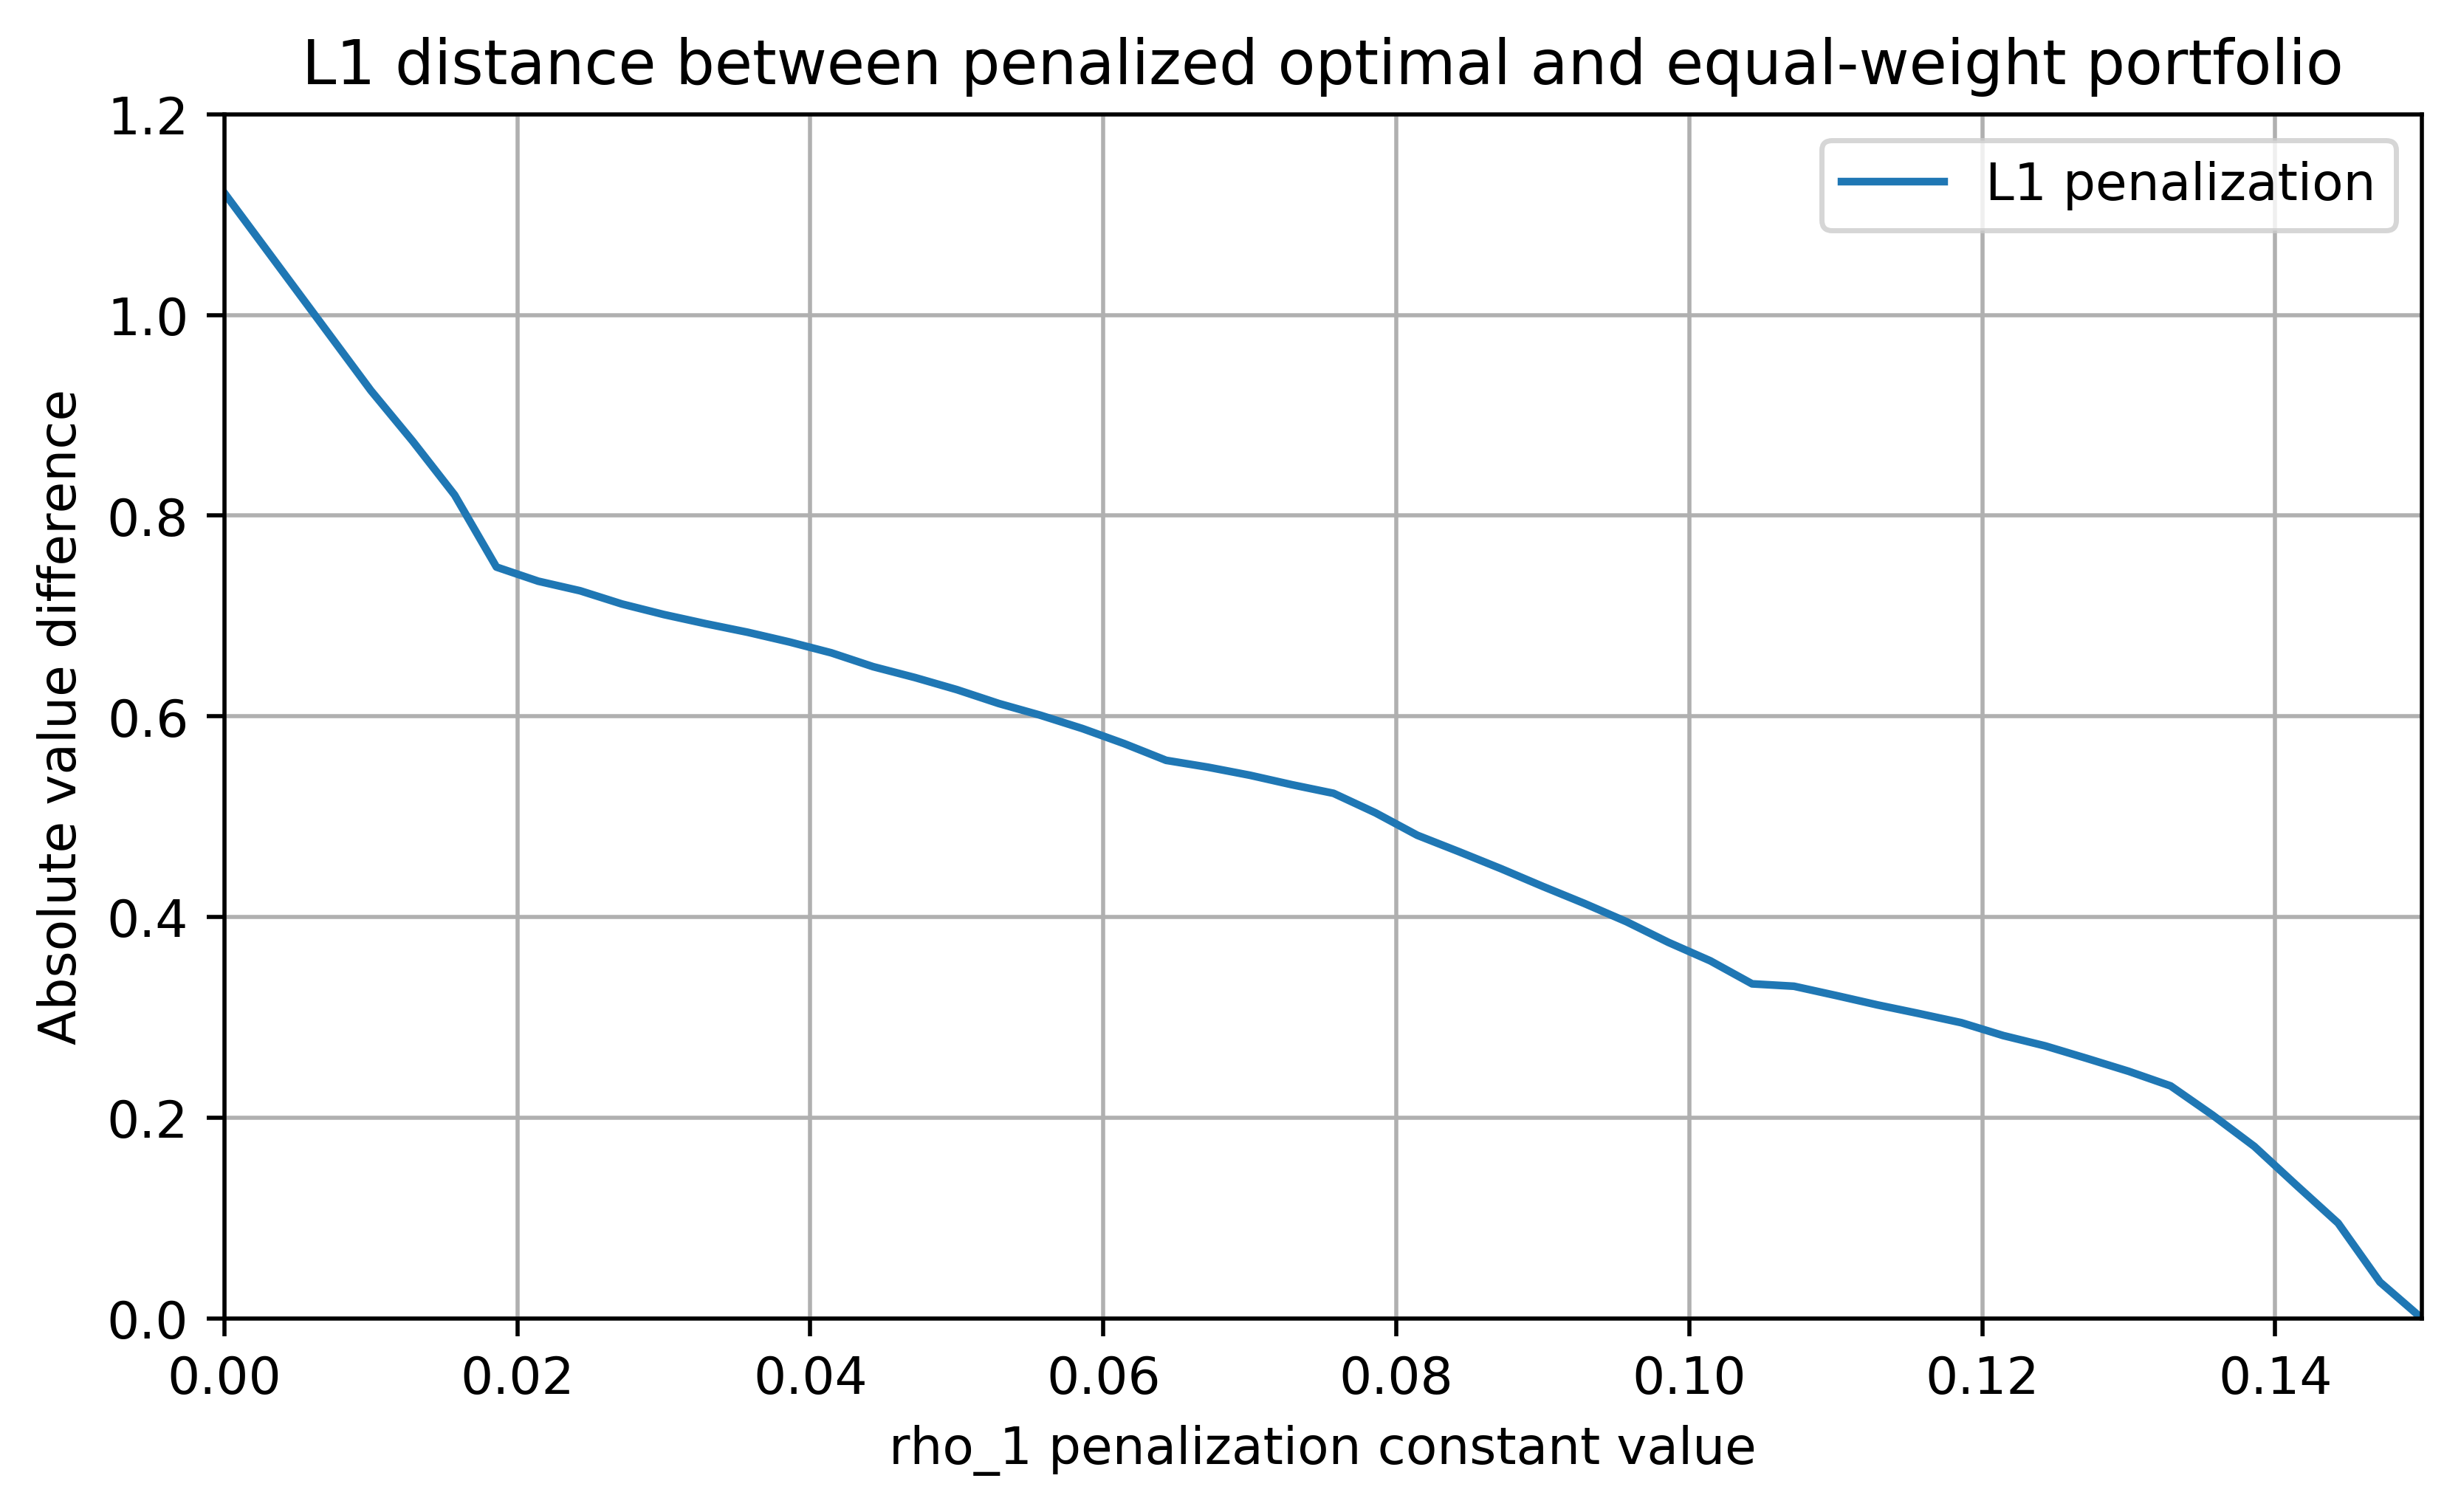

In [86]:
# Plot volatility versus expected return for individual stocks
my_dpi = 500
plt.figure(figsize=(3840/my_dpi, 2160/my_dpi), dpi=my_dpi)
ax = plt.gca()

# Plot volatility versus expected return for minimum risk portfolio
#ax.scatter(x=np.argmin(frontiers[i,:]), y=alloc_diffs[i,np.argmin(frontiers[i,:])], color=colors[i])
ax.plot(l1_rhos_aug,l1_distances_to_equal, label="L1 penalization")

# Format and display the final plot
ax.axis([0.0, np.max(l1_rhos), 0.0, 1.2])
ax.set_xlabel('rho_1 penalization constant value')
ax.set_ylabel('Absolute value difference')
ax.set_title("L1 distance between penalized optimal and equal-weight portfolio")

ax.legend()
ax.grid()

plt.savefig('distance_l1_equal_optimal.jpg', dpi=my_dpi)

In [87]:
print(l1_distances_to_equal)

[1.12153891e+00 9.24677410e-01 8.74127882e-01 8.20616987e-01
 7.48743199e-01 7.34627080e-01 7.25090956e-01 7.11892062e-01
 7.01410776e-01 6.92278041e-01 6.83769778e-01 6.74076701e-01
 6.63259226e-01 6.49439602e-01 6.38594805e-01 6.26552179e-01
 6.12768893e-01 6.00996539e-01 5.87766251e-01 5.72728507e-01
 5.56095152e-01 5.49264093e-01 5.41250262e-01 5.31847779e-01
 5.23223486e-01 5.03817583e-01 4.81427073e-01 4.65002045e-01
 4.48126329e-01 4.30412804e-01 4.13333086e-01 3.95248356e-01
 3.74674786e-01 3.56302673e-01 3.33333333e-01 3.30945867e-01
 3.21771691e-01 3.12284896e-01 3.03611888e-01 2.94599830e-01
 2.81778833e-01 2.71526551e-01 2.58993388e-01 2.46118485e-01
 2.31588260e-01 2.02545574e-01 1.71270413e-01 1.32790898e-01
 9.49089259e-02 3.61232212e-02 8.32667268e-17]


As we can observe from the printed values above, the $L_1$ distance between the $L_1$-penalty-optimal equal weight portfolio and the equal weight portfolio $x_0$ suddenly jumps from $10^{-2}$ to zero (in machine precision) from one point to another. This is the point when the optimization algorithm finds the corner in the feasible set polyhedron which is exactly $x_0$.

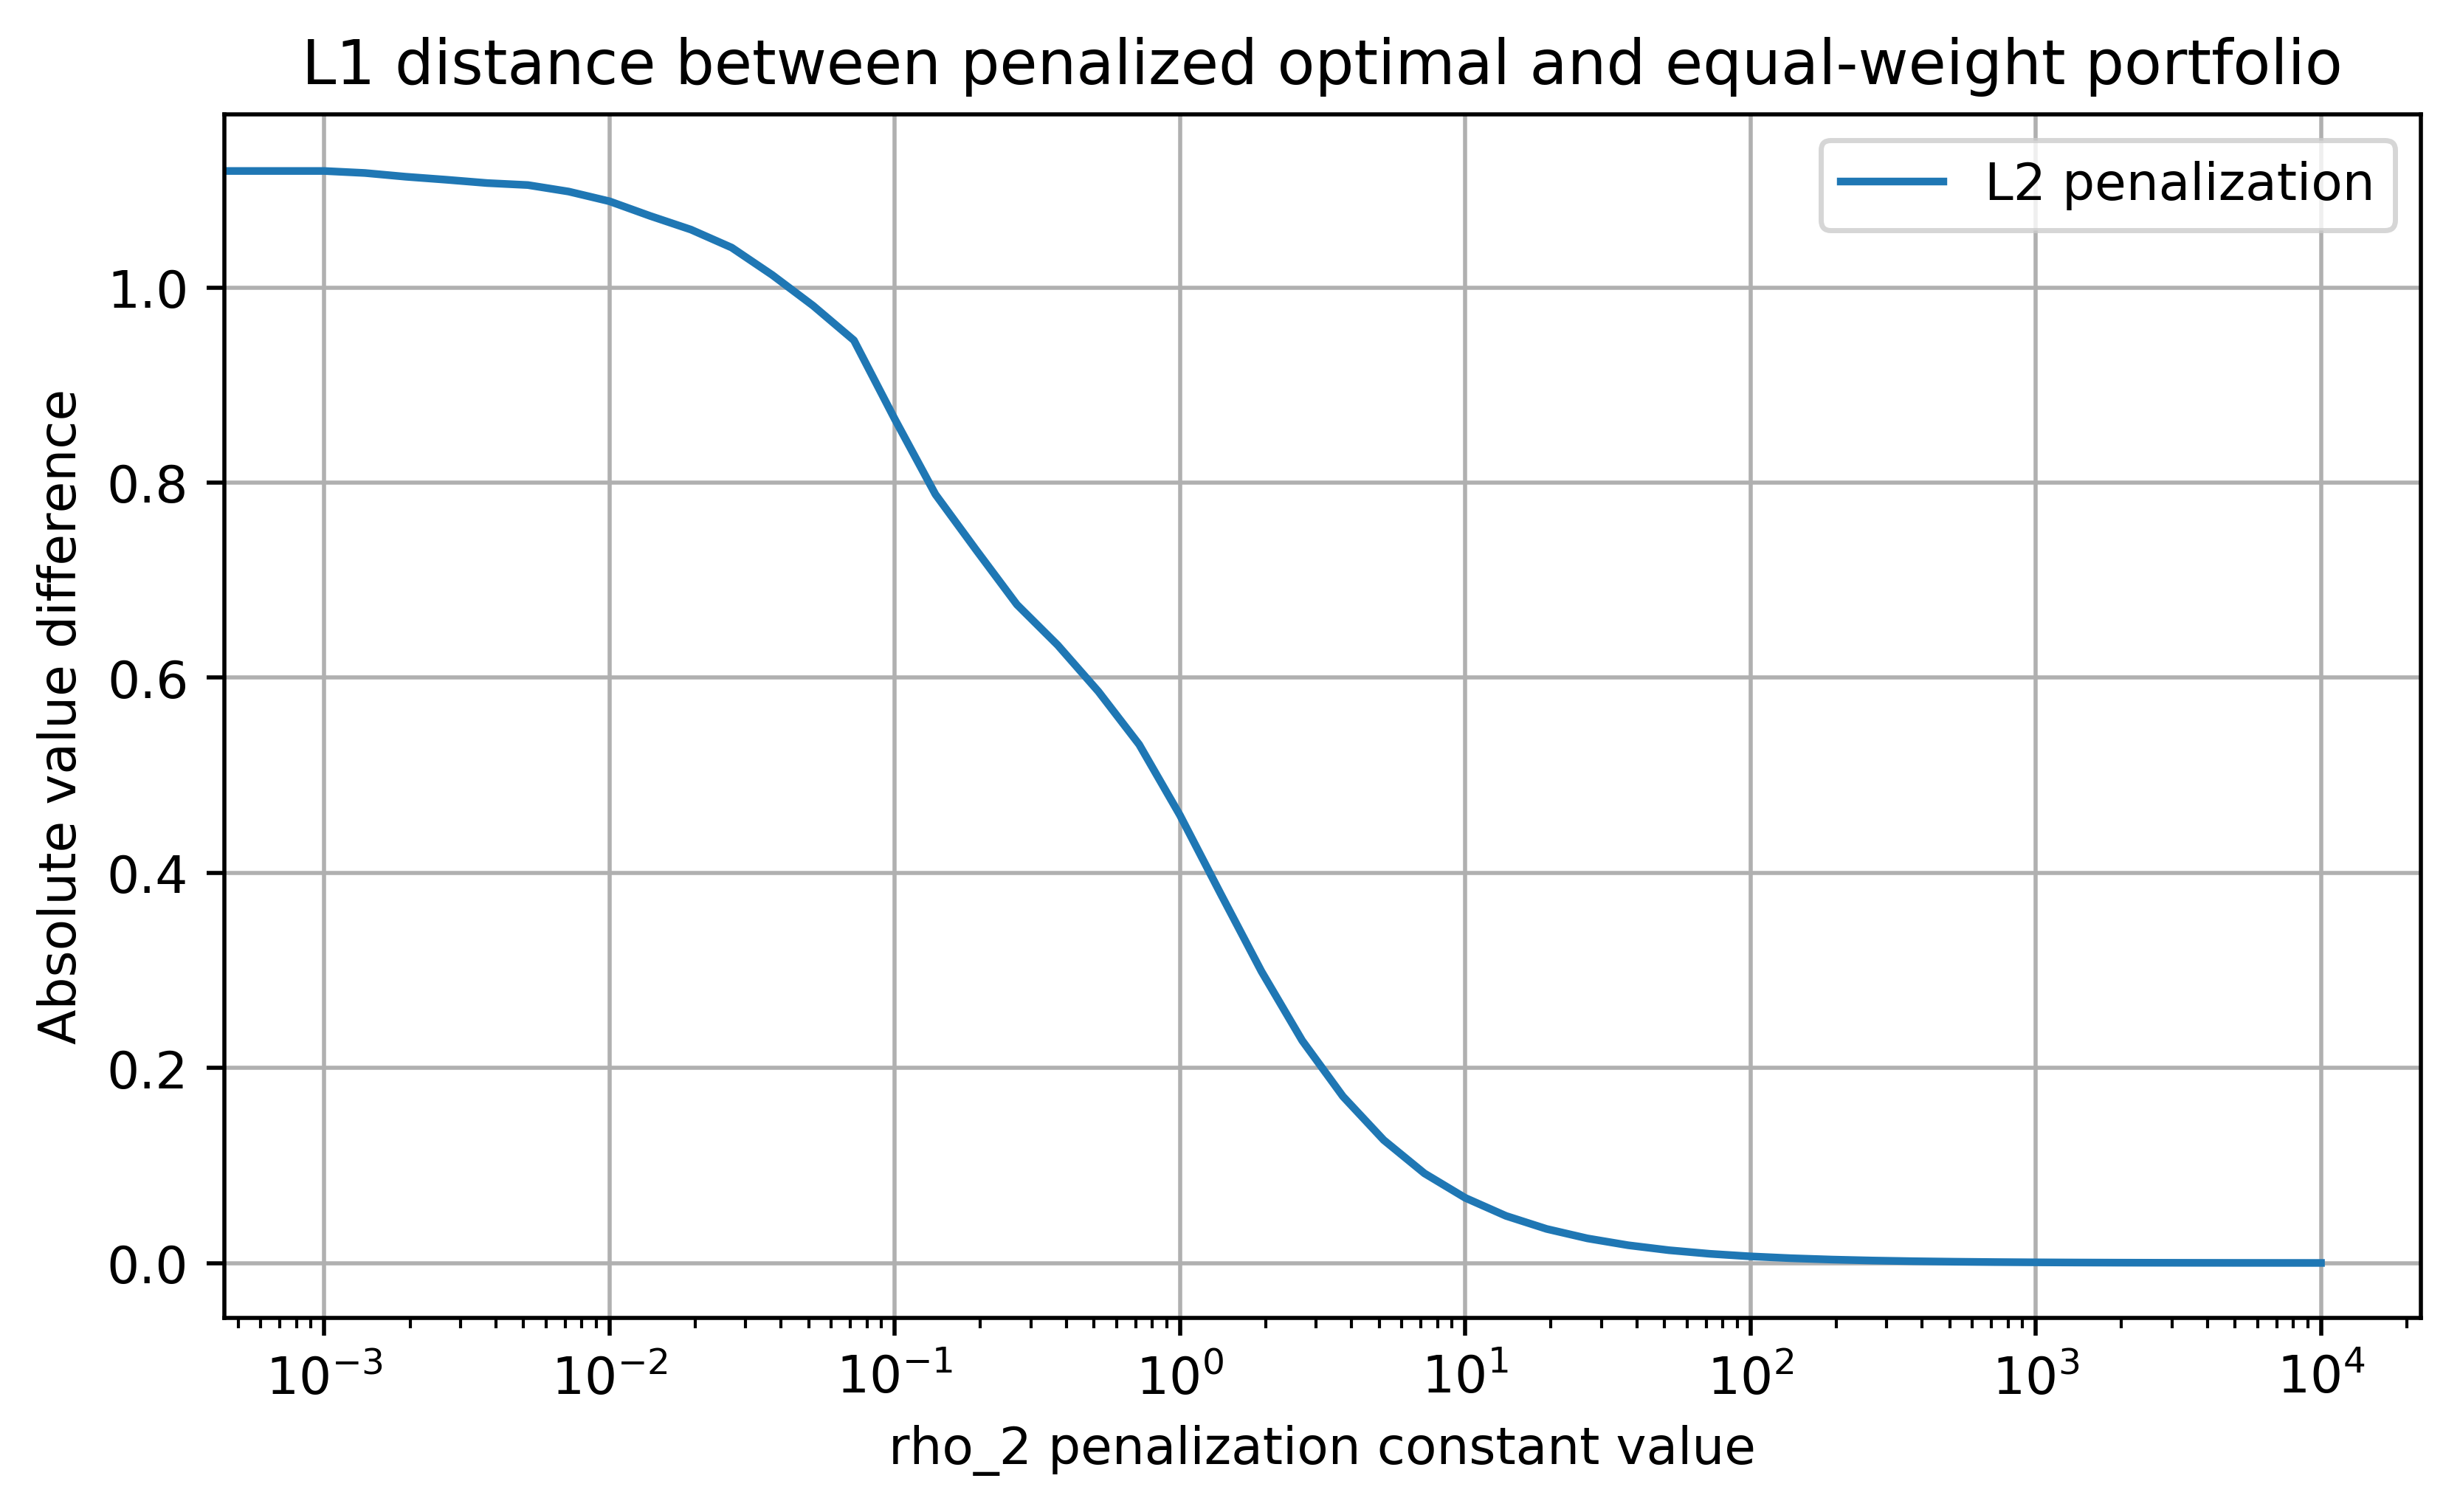

In [88]:
# Plot volatility versus expected return for individual stocks
my_dpi = 500
plt.figure(figsize=(3840/my_dpi, 2160/my_dpi), dpi=my_dpi)
ax = plt.gca()

# Plot volatility versus expected return for minimum risk portfolio
#ax.scatter(x=np.argmin(frontiers[i,:]), y=alloc_diffs[i,np.argmin(frontiers[i,:])], color=colors[i])
ax.plot(l2_rhos_aug,l2_distances_to_equal, label="L2 penalization")

 
# Format and display the final plot
#ax.axis([0.0, np.max(l1_rhos), 0.0, 1.0])
ax.set_xlabel('rho_2 penalization constant value')
ax.set_ylabel('Absolute value difference')
ax.set_title("L1 distance between penalized optimal and equal-weight portfolio")
ax.set_xscale("log")
ax.legend()
ax.grid()

plt.savefig('distance_l2_equal_optimal.jpg', dpi=my_dpi)

We observe a monotonic decline over the different decades of the regularization parameter. In between $\rho_2 = 10^{-1}$ and $\rho_2 = 10$, the decay seems to be log-linear, i.e. exponential in $\rho_2$. Toward the optimal solution and the equal weight portfolio, the absolute value difference decays very slowly. 